In [1]:
import psycopg2
import requests
import nbimporter
import datetime
import collections
import sys
import copy
import operator
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import Init_database as indb
import pdb
import pytz
import matplotlib.cm as cm
from calendar import monthrange
from googletrans import Translator
from dateutil import parser
import warnings
warnings.filterwarnings("ignore")

Importing Jupyter notebook from Init_database.ipynb


In [2]:
sta_list = ['2b3a35d4-cb94-4b8f-a47a-bbb054754066', '1d02640a-7f14-4fc3-baaf-60754a38fff7',
            'ac6cb946-5fff-491b-859e-55cc5f701657', 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66',
            'b134a159-16bd-4f5d-af1b-cd42599a3bab', '33a3c031-0a3a-417d-ba1b-53549bb08dc2', 
            'e4758edb-1183-4c51-887b-a52ca7abef3d', '13bdab71-110b-4448-a3c4-5c3113183546']
interestOFStation = -1

In [13]:
#specify day and date of interest to investigate
offset = datetime.datetime.now(pytz.timezone("US/Pacific")).utcoffset().seconds
if offset == 61200:
    offset_val = -420
elif offset == 57600:
    offset_str = -480

interestOFyear_start = 2018
interestOFmon_start = 4
interestOFday_start = 19

interestOFyear_end = 2018
interestOFmon_end = 4
interestOFday_end = 28

interestOFDate_start = datetime.datetime(interestOFyear_start, 
                                         interestOFmon_start, 
                                         interestOFday_start, 
                                         tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset_val, name=None)) 

interestOFDate_end = datetime.datetime(interestOFyear_end, 
                                       interestOFmon_end, 
                                       interestOFday_end, 
                                       tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset_val, name=None)) 
months = ['January', 'Febuary', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'Octobor', 'November', 'December']

In [14]:
#status indicator
chargingInd = 1.0
idleInd = 0.9
pluggedInInd = 1.1
fullyChargedInd = 0.95

In [15]:
db_name="db_teld"
user_name="postgres"
password = "ecalscraping"
host="169.229.157.40"
port="5432"
conn = indb.init_db(db_name, user_name, password, host, port)

In [16]:
def get_stationID_grand(conn):
    try:
        cur = conn.cursor()
        stmt = "select stationid from tbl_app_eachstations where tbl_app_eachstations.location && \
    ST_MakeEnvelope(113.85955, 22.50563, 114.17335, 22.69960, 4326) intersect select distinct stationid\
    from tbl_app_useract_newDetailed;"
        cur.execute(stmt)
        sta_list_Grand = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)

    return sta_list_Grand

In [17]:
#select shenzhen stationID
# sta_list_Grand = get_stationID_grand(conn)
sta_userAct_freq_dict = dict()
# for staid in sta_list_Grand:
for staid in sta_list:
    cur = conn.cursor()
    stmt = "select count(*) from tbl_app_useract_0423 where stationid = '{}'".format(staid)
    cur.execute(stmt)
    userAct_count = cur.fetchall()
    cur.close()
    sta_userAct_freq_dict[staid] = userAct_count

In [18]:
sta_userAct_freq_orderDict = collections.OrderedDict(sorted(sta_userAct_freq_dict.items(), 
                                                            key=lambda t: t[1], reverse=True))

In [19]:
sta_userAct_freq_orderDict

OrderedDict([('33a3c031-0a3a-417d-ba1b-53549bb08dc2', [(365L,)]),
             ('13bdab71-110b-4448-a3c4-5c3113183546', [(251L,)]),
             ('e4758edb-1183-4c51-887b-a52ca7abef3d', [(220L,)]),
             ('b134a159-16bd-4f5d-af1b-cd42599a3bab', [(156L,)]),
             ('1d02640a-7f14-4fc3-baaf-60754a38fff7', [(122L,)]),
             ('2b3a35d4-cb94-4b8f-a47a-bbb054754066', [(54L,)]),
             ('ac6cb946-5fff-491b-859e-55cc5f701657', [(32L,)]),
             ('dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66', [(6L,)])])

In [20]:
#Request user activity from a station
def get_staUserAct(conn, staid):
    try:
        cur = conn.cursor()
        stmt = "select starttime, cartypename, usernickname, pilename \
        from tbl_APP_useract_0423 where stationid = '{}' order by starttime".format(staid)
        cur.execute(stmt)
        station_userAct = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
        
    print("Number of user activities: ", len(station_userAct))
    
    return station_userAct

In [21]:
station_userAct_uncleaned = get_staUserAct(conn, sta_list[interestOFStation]) 
# station_userAct = get_staUserAct(conn, sta_list[interestOFStation])

('Number of user activities: ', 251)


In [22]:
#fix timezone problem in user data. - Apr.25 Currently user data time is in Chinese time but timezone is in US
station_userAct = list()
for idx, useract in enumerate(station_userAct_uncleaned):
    
    if useract[0].tzinfo._offset.seconds == 61200:
        temp_time = useract[0] + datetime.timedelta(hours=15)
    elif useract[0].tzinfo._offset.seconds == 57600:
        temp_time = useract[0] + datetime.timedelta(hours=16)
    station_userAct.append((temp_time, useract[1], useract[2], useract[3]))

# Visualization of User Activities

## Visualization of Frequncy

In [23]:
pilename_dict = dict()
pile_user_dict = dict()
unique_user_list = list()
#AC charger
ac = '\xe5\x8f\xb7\xe4\xba\xa4\xe6\xb5\x81'
dc = '\xe5\x8f\xb7\xe7\x9b\xb4\xe6\xb5\x81'

for idx, act in enumerate(station_userAct):
    #add indicator of dc charger to the end of 
    if act[-1][3:] == ac:
        pilename = act[-1][:3] + "0"
    elif act[-1][3:] == dc:
        pilename = act[-1][:3] + "1"
    username = act[2]
    if pilename in pilename_dict:
        pilename_dict[pilename] += 1
    else:
        pilename_dict[pilename] = 1
    
    if pilename in pile_user_dict:
        pile_user_dict[pilename].append(username)
    else:
        pile_user_dict[pilename] = [username]
    
    if username not in unique_user_list:
        unique_user_list.append(username)

In [24]:
np.unique(pile_user_dict.values()[0], return_counts=True)

(array(['1***0', '1***6', '1***8', 'F***\xe6\x81\x92', 'R***y', 'b***w',
        'j***y', 'm***k', 'v***s', '\xe4\xb8\xad***\xe7\x8c\xaa',
        '\xe5\x85\x89***', '\xe6\x88\xb4***\xe7\x94\x9f', '\xe7\x8e\x8b***',
        '\xe8\x80\x81***\xe6\x9c\xba', '\xe8\xa6\x83***',
        '\xe8\xbe\x89***\xe5\x93\xa5'],
       dtype='|S9'), array([1, 2, 1, 1, 2, 5, 4, 1, 1, 2, 4, 2, 1, 1, 1, 2]))

In [25]:
pile_user_dict

{'1021': ['1***0',
  '1***4',
  '\xe8\x80\x81***\xe6\x9c\xba',
  'm***k',
  '\xe7\xa7\xb0***\xe5\x8f\xb7',
  '1***0',
  '1***9',
  None,
  '\xe7\x8e\x8b***\xe5\xbf\x97',
  'm***k',
  '1***5',
  '1***5',
  '\xe7\xa7\xb0***\xe5\x8f\xb7',
  'm***k',
  '\xe7\xa7\xb0***\xe5\x8f\xb7',
  None,
  '\xe7\xa7\xb0***\xe5\x8f\xb7',
  '\xe5\x88\x98***\xe5\x86\x9b',
  '\xe8\xa6\x83***',
  '\xe8\x80\x81***\xe6\x9c\xba',
  '1***8',
  None,
  '\xe7\x8e\x8b***\xe5\xbf\x97',
  '1***0',
  'm***k',
  '\xe9\xa1\xba***\xe8\xbe\x89',
  '\xe7\x8e\x8b***\xe5\xbf\x97',
  '\xe7\xa7\xb0***\xe5\x8f\xb7',
  'm***k',
  '\xe7\x8e\x8b***\xe5\xbf\x97',
  '\xe8\x80\x81***\xe6\x9c\xba',
  '1***8',
  '1***8',
  '\xe5\xba\x84***',
  '\xe9\x99\x88***\xe9\x83\x81',
  '1***1',
  '\xe9\xa1\xba***\xe8\xbe\x89',
  '1***3',
  '\xe9\xa1\xba***\xe8\xbe\x89',
  '\xe7\xa7\xb0***\xe5\x8f\xb7',
  '1***3',
  'm***k',
  '1***3',
  'm***k',
  '1***3',
  '\xe7\xa9\xbf***\xe7\x8c\xab',
  '1***3',
  '\xe8\x80\x81***\xe6\x9c\xba',
  '\xe7\x8e\x

In [26]:
pile_user_dict.keys()

['1050', '1090', '1080', '1060', '1070', '1110', '1021']

In [27]:
def get_uniqueUser_pileUsage(pile_user_dict):
    """
        return n by m np.array where n is the number of different users 
            and m is the number of piles
    """
    uniqueUser_pileUsage = list()
    key_list = pile_user_dict.keys()
    for idx, username in enumerate(unique_user_list):
        user_pileUsage = np.zeros(len(key_list))
        for i, key in enumerate(pile_user_dict.keys()):
            unique, counts = np.unique(pile_user_dict[key], return_counts=True)
            if username in unique:
                user_pileUsage[i] = counts[unique.tolist().index(username)]
        if idx == 0:
            uniqueUser_pileUsage.append(np.array(user_pileUsage))
        else:
            uniqueUser_pileUsage.append(np.array(user_pileUsage) + uniqueUser_pileUsage[idx-1])
            
    return key_list, uniqueUser_pileUsage

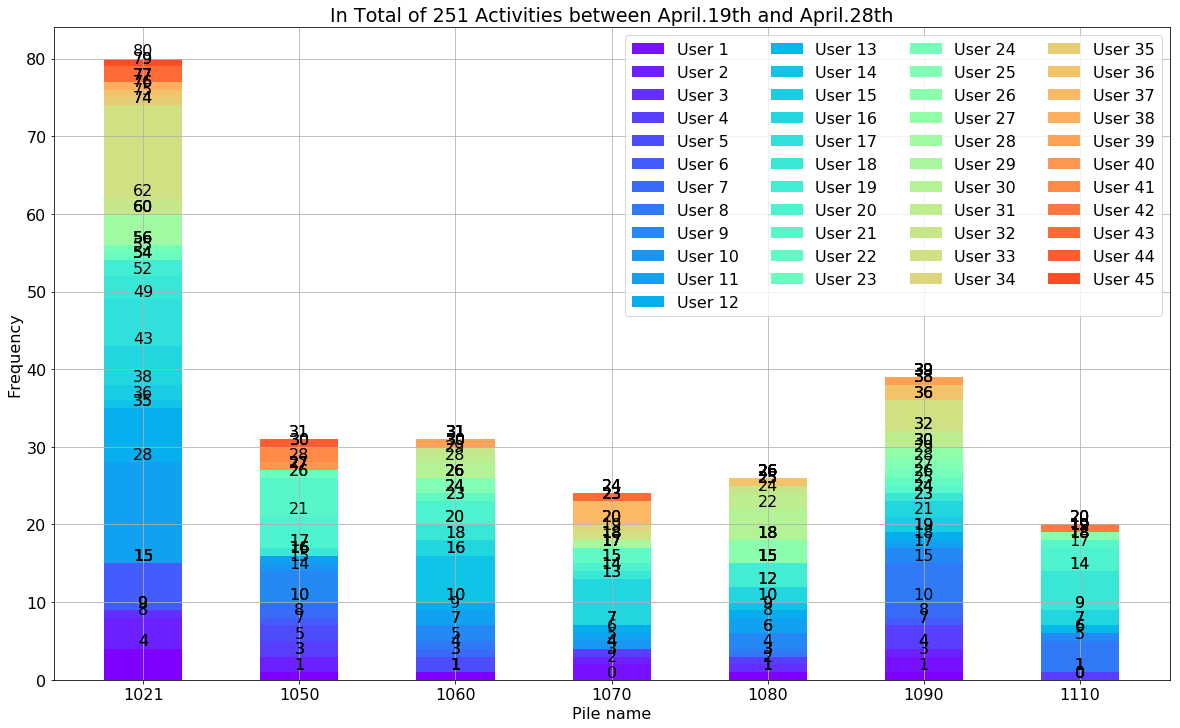

In [28]:
plt.figure(figsize=(20, 12))
plt.rc('font',size=16)
key_list, uniqueUser_pileUsage = get_uniqueUser_pileUsage(pile_user_dict)
colors = cm.rainbow(np.linspace(0, 0.9, len(uniqueUser_pileUsage)))

for idx, elem in enumerate(uniqueUser_pileUsage):
    if idx == 0:
        plt.bar(key_list, elem, width=0.5, color=colors[idx])
    else:
        plt.bar(key_list, elem-uniqueUser_pileUsage[idx-1], bottom=uniqueUser_pileUsage[idx-1], 
                width=0.5, color=colors[idx], label="User "+str(idx))
    
plt.xlabel("Pile name")
plt.ylabel("Frequency")
plt.title("In Total of {0} Activities between {3}.{1}th and {3}.{2}th".format(len(station_userAct), 
                                                                           interestOFDate_start.day, 
                                                                           interestOFDate_end.day, 
                                                                           months[interestOFDate_start.month-1]))
plt.legend(ncol=len(unique_user_list)/10)
for idx, elem in enumerate(uniqueUser_pileUsage):
    for i, num in enumerate(elem):
        plt.annotate(int(num), (key_list[i], num), 
                     horizontalalignment='center', verticalalignment='bottom')
plt.grid()

In [29]:
uniqueUser_pileUsage[-1]

array([ 31.,  39.,  26.,  31.,  24.,  20.,  80.])

In [30]:
# def clean_stationAct(station_userAct):
#     """
#         Collect datetime info is in string format, need to convert to datetime object
#         Check "date.tzinfo._offset.seconds" if is 61200, then offset is -420 (-07)；
#          Otherwise, should be 57600, -480 (-08)
#     """
    
#     station_userAct_cleaned = []
#     for idx, act in enumerate(station_userAct):
# #         date = parser.parse(act[0])
#         other_info = act[1:]
#         station_userAct_cleaned.append((date,) + other_info)
#     return station_userAct_cleaned

In [31]:
#Clean data, convert string format date to datetime object
# station_userAct = clean_stationAct(station_userAct)

In [32]:
def extract_useful(station_userAct, interestOFDate_start, interestOFDate_end):

    station_userAct_cleaned = []
    for i in range(len(station_userAct)):
        
        if station_userAct[i][0] > interestOFDate_start \
        and station_userAct[i][0] < interestOFDate_end:
            station_userAct_cleaned.append(station_userAct[i])
            
    return station_userAct_cleaned

In [33]:
station_userAct = extract_useful(station_userAct, interestOFDate_start, interestOFDate_end)
ac = '\xe5\x8f\xb7\xe4\xba\xa4\xe6\xb5\x81'
dc = '\xe5\x8f\xb7\xe7\x9b\xb4\xe6\xb5\x81'

#Extract user acticities to x and y
x_user = list()
for idx, act in enumerate(station_userAct):
    if act[-1][3:] == ac:
        pilename = act[-1][:3] + "0"
    elif act[-1][3:] == dc:
        pilename = act[-1][:3] + "1"
    x_user.append((act[0], pilename, act[2]))
    
y_user = list()

for i in range(len(x_user)):
    y_user.append(unique_user_list.index(x_user[i][-1])+1)

In [34]:
x_user[0]

(datetime.datetime(2018, 4, 19, 3, 22, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
 '1021',
 '1***0')

In [35]:
colors = cm.rainbow(np.linspace(0, 1, len(unique_user_list)))

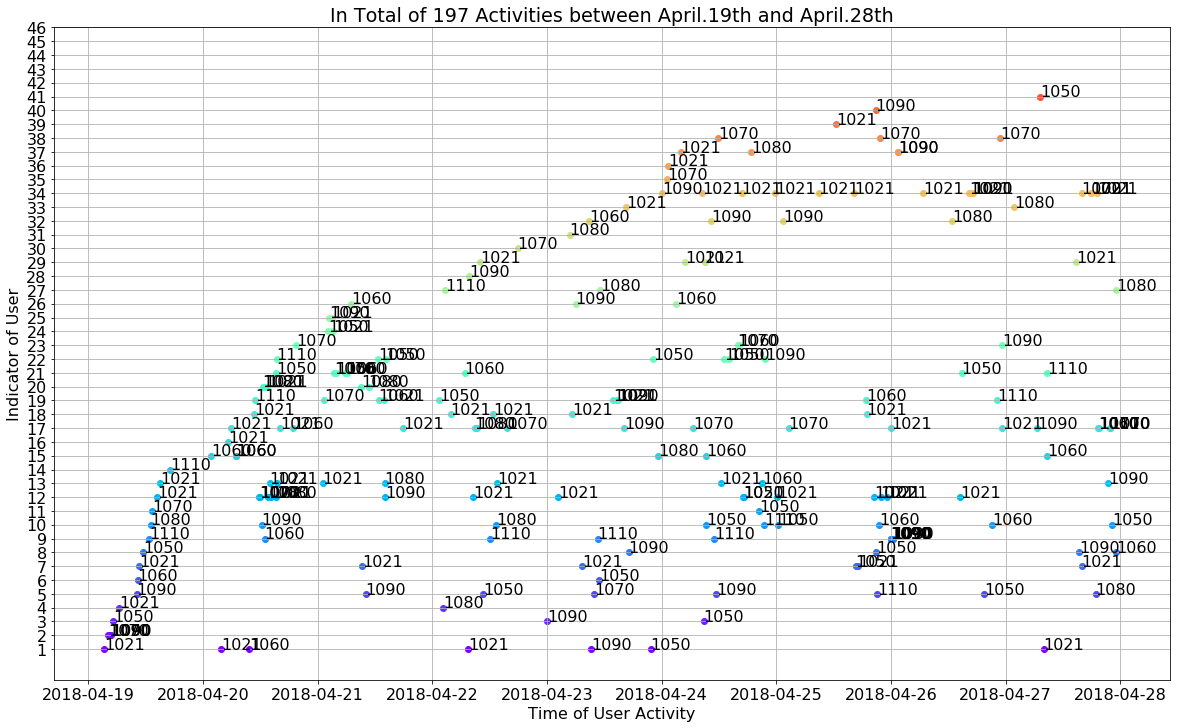

In [36]:
plt.figure(figsize=(20, 12))
plt.rc('font',size=16)
matplotlib.use('nbagg')
for i in range(len(x_user)):
    idx = unique_user_list.index(x_user[i][-1])
    plt.scatter(x_user[i][0], y_user[i], color=colors[idx])
for idx in range(len(x_user)):
    plt.annotate(x_user[idx][1], (x_user[idx][0], y_user[idx]))
plt.xlabel("Time of User Activity")
plt.ylabel("Indicator of User")
plt.yticks(np.linspace(1, len(unique_user_list), len(unique_user_list), dtype="int"))
plt.title("In Total of {0} Activities between {3}.{1}th and {3}.{2}th".format(len(station_userAct), 
                                                                           interestOFDate_start.day, 
                                                                           interestOFDate_end.day, 
                                                                           months[interestOFDate_start.month-1]))
plt.grid()

# Visuliazation of Pile Utilization

In [37]:
try:
    cur = conn.cursor()
#     stmt = "select pilecode from tbl_APP_pilecode where staid in %s"
#     cur.execute(stmt, (tuple(sta_list),))
    stmt = "select pilecode from tbl_APP_pilecode where staid = '{}'".format(sta_list[interestOFStation])
    cur.execute(stmt)
    pillcode_list = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print("Nubmer of pills: ", len(pillcode_list))

('Nubmer of pills: ', 10)


In [38]:
class Station(object):
    "This is a station object"
    num_pills = 0
    def __init__(self, stationid, score, pricescore, servicescore, 
                 stationname, stationaddress, location):
        self.id = stationid
        self.score = score
        self.pricescore = pricescore
        self.servicescore = servicescore
        self.name = stationname
        self.addr = stationaddress
        self.GPS = location
        self.pills = []
        self.ult_data = []
    def add_Pill(self, pill_obj):
        self.pills.append(pill_obj)
        self.num_pills += 1
    def delete_numPills(self):
#         if self.pills >= 1:
#             self.pills -= 1
        pass
    def check_pill(self, pillcode):
        for pill in self.pills:
            #if exist return True
            if pill.pillcode == pillcode:
                return True
        return False
    def get_maxPower(self):
        maxPower = 0
        for pill in self.pills:
            if pill.isfast == "Y":
                maxPower += 60 #kw
            else:
                maxPower += 7 #kw
        return maxPower
    def get_stationName_Eng(self):
        translator = Translator()
        return translator.translate(self.name).text

In [39]:
class Pill(Station):
    ult_data = None
    def __init__(self, pillcode, voltage, description, isfast, chargingport, power, 
                 pricedesc, prices, station):
        self.pillcode = pillcode
        self.voltage = voltage
        self.description = description
        self.isfast = isfast
        self.chargingport = chargingport
        self.power = power
        self.pricedesc = pricedesc
        self.prices = prices
        self.station = station
    def update_ultData(self, ult_data_new):
        self.ult_data = ult_data_new

In [40]:
# #------- Request one pill daily utilization data from db -------#
def get_pill_daily(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select statecodev3, statenamev3, time from tbl_APP_state where pillcode='{}' \
        order by time".format(pillcode)
        cur.execute(stmt)
        ult_data = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return ult_data

In [41]:
# #------- Request the pill details from db -------#
def get_pill_details(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select voltage, description, isfast, chargingport, power, pricedesc, \
        prices from tbl_app_piles where pillcode='{}'".format(pillcode)
        cur.execute(stmt)
        pill_details = cur.fetchall()
        cur.close()
        return pill_details
    except psycopg2.Error as e:
        print(e)

In [42]:
# #------- Request the station details from db -------#
def get_sta_details(stationid):
    try:
        cur = conn.cursor()
        stmt = "select servicescore, score, pricescore, stationname, stationaddress, ST_X(location), \
        ST_Y(location) from tbl_app_eachstations where stationid='{}'".format(stationid)
        cur.execute(stmt)
        sta_details = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return sta_details

In [43]:
# #------- Request pillcodes from same station from db -------#
def get_pillcodes(stationid=sta_list[0]):
    try:
        cur = conn.cursor()
        stmt = "select pillcode from tbl_app_piles where staid='{}'".format(stationid)
        cur.execute(stmt)
        pillcode_list = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return pillcode_list

In [44]:
def get_pill_station_details(sta_list):
    pillcode_list = []
    pill_details_list = []
    sta_details_list = []
    for staid in sta_list:
        pillcode_list.append(get_pillcodes(staid))
        pill_details_list.append(get_pill_details(pillcode_list[0][0][0]))
        sta_details_list.append(get_sta_details(staid))
    return pillcode_list, pill_details_list, sta_details_list

In [45]:
def init_sta(stationid, score, pricescore, 
               servicescore, stationname, stationaddress, x, y):
    """
    Data cleansing + passing into Station object to initiate
    """
    location  = (x, y)
    station = Station(stationid, score, pricescore, servicescore, stationname, stationaddress, location)
    return station

In [46]:
def constr_pill(pillcode, voltage, description, isfast, 
                chargingport, power, pricedesc, prices, station):
    """
    Data cleansing + passing into Pill object to initiate
    """
    pill = Pill(pillcode, voltage, description, isfast, chargingport, power, pricedesc, prices, station)
    return pill

In [47]:
def constr_sta(pillcode_list, station):
    """
    Construct full station and pills included
    """
    for pillcode in pillcode_list:
        pill_details = get_pill_details(pillcode=pillcode[0])
        if not station.check_pill(pillcode[0]):
            pill = constr_pill(pillcode[0], pill_details[0][0], pill_details[0][1], pill_details[0][2],
                  pill_details[0][3], pill_details[0][4], pill_details[0][5], pill_details[0][6], station)
            station.add_Pill(pill)
    return station

In [48]:
def update_ultData(station):
    for pill in station.pills:
        pillcode = pill.pillcode
        ult_data = get_pill_daily(pillcode)
        pill.update_ultData(ult_data)
    return station

In [49]:
def init_station_obj(sta_list, sta_details_list):
    staObject_list = []
    for i, staid in enumerate(sta_list):
        station_obj = init_sta(staid, sta_details_list[i][0][0], sta_details_list[i][0][1], 
                               sta_details_list[i][0][2], sta_details_list[i][0][3], 
                               sta_details_list[i][0][4], sta_details_list[i][0][5], 
                               sta_details_list[i][0][6])
        staObject_list.append(station_obj)
    return staObject_list

In [50]:
def constr_station_objFull(staObject_list, pillcode_list):
    for i, pillcodes in enumerate(pillcode_list):
        staObject_list[i] = constr_sta(pillcodes, staObject_list[i])
    return staObject_list

In [51]:
def update_daily_ultData(staObject_list):
    """
        Takes in a list of station
        Returns a list if list length > 1, a station object if length = 0
    """
    if len(staObject_list) == 1:
        return update_ultData(staObject_list[0])
    else:
        for i in range(len(staObject_list)):
            staObject_list[i] = update_ultData(staObject_list[i])
        return staObject_list

In [52]:
#get the station related details
pillcode_list, pill_details, sta_details = get_pill_station_details([sta_list[interestOFStation]])

In [53]:
#Initialize the station
station_obj =init_sta(sta_list[interestOFStation], sta_details[0][0], sta_details[0][0][1], sta_details[0][0][2], 
                      sta_details[0][0][3], sta_details[0][0][4], sta_details[0][0][5], sta_details[0][0][6])

In [54]:
#Construct the full station
station_obj = constr_station_objFull([station_obj], pillcode_list)
station_obj = constr_sta(pillcode_list[0], station_obj[0])
##-----YinXing_IndustrialPark_sta is a station object now not a list.
print(station_obj.num_pills)

10


In [55]:
station_obj = update_daily_ultData([station_obj])
station_obj = update_ultData(station_obj)
print(station_obj.name)
print(station_obj.pills[0].ult_data[0])

深圳景元大厦充电站
('01', '\xe7\xa9\xba\xe9\x97\xb2', datetime.datetime(2017, 9, 10, 23, 35, 25, 307209, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)))


In [56]:
x_pile = []
y_pile = []

for p in range(len(station_obj.pills)):
    for i in range(len(station_obj.pills[p].ult_data)):
        
        if station_obj.pills[p].ult_data[i][2] > interestOFDate_start \
        and station_obj.pills[p].ult_data[i][2] < interestOFDate_end \
        and station_obj.pills[p].ult_data[i][0] == '02':
            #Charging
            x_pile.append((station_obj.pills[p].ult_data[i][2], 
                           station_obj.pills[p].pillcode[-3:]))
            y_pile.append(chargingInd)
            
        elif station_obj.pills[p].ult_data[i][2] > interestOFDate_start \
        and station_obj.pills[p].ult_data[i][2] < interestOFDate_end \
        and station_obj.pills[p].ult_data[i][0] == '01':
            #Idle
            x_pile.append((station_obj.pills[p].ult_data[i][2], 
                           station_obj.pills[p].pillcode[-3:]))
            y_pile.append(idleInd)
            
        elif station_obj.pills[p].ult_data[i][2] > interestOFDate_start \
        and station_obj.pills[p].ult_data[i][2] < interestOFDate_end \
        and station_obj.pills[p].ult_data[i][0] in ['05', '06']:
            #04:fully charged, 05:plugged in, 06:paused
            x_pile.append((station_obj.pills[p].ult_data[i][2], 
                           station_obj.pills[p].pillcode[-3:]))
            y_pile.append(pluggedInInd)   
            
        elif station_obj.pills[p].ult_data[i][2] > interestOFDate_start \
        and station_obj.pills[p].ult_data[i][2] < interestOFDate_end \
        and station_obj.pills[p].ult_data[i][0] == '04':
            #Idle
            x_pile.append((station_obj.pills[p].ult_data[i][2], 
                           station_obj.pills[p].pillcode[-3:]))
            y_pile.append(fullyChargedInd)

Text(0.5,1,u'Time vs Station Utilization')

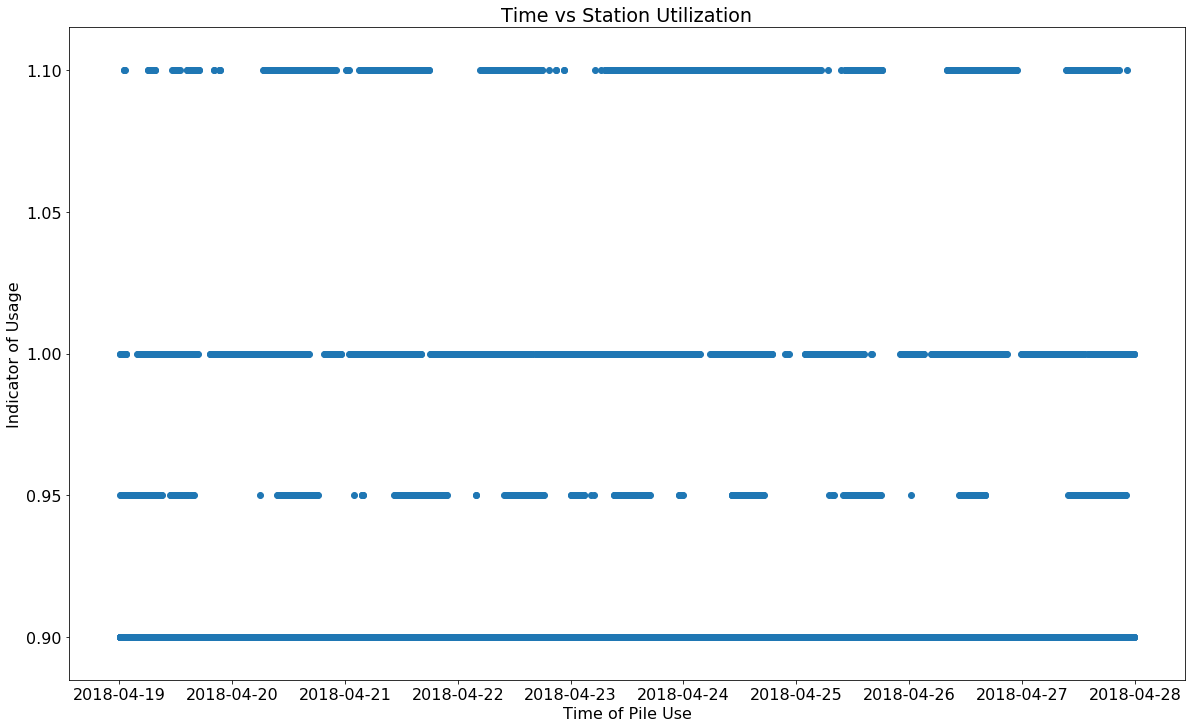

In [57]:
plt.figure(figsize=(20, 12))
plt.rc('font',size=16)
plt.scatter([x_pile[i][0] for i in range(len(x_pile))], y_pile)
plt.xlabel("Time of Pile Use")
plt.ylabel("Indicator of Usage")
plt.title("Time vs Station Utilization")

# Superimposing user and pile utilization

In [58]:
x_pile[0]

(datetime.datetime(2018, 4, 19, 0, 28, 17, 171054, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
 '102')

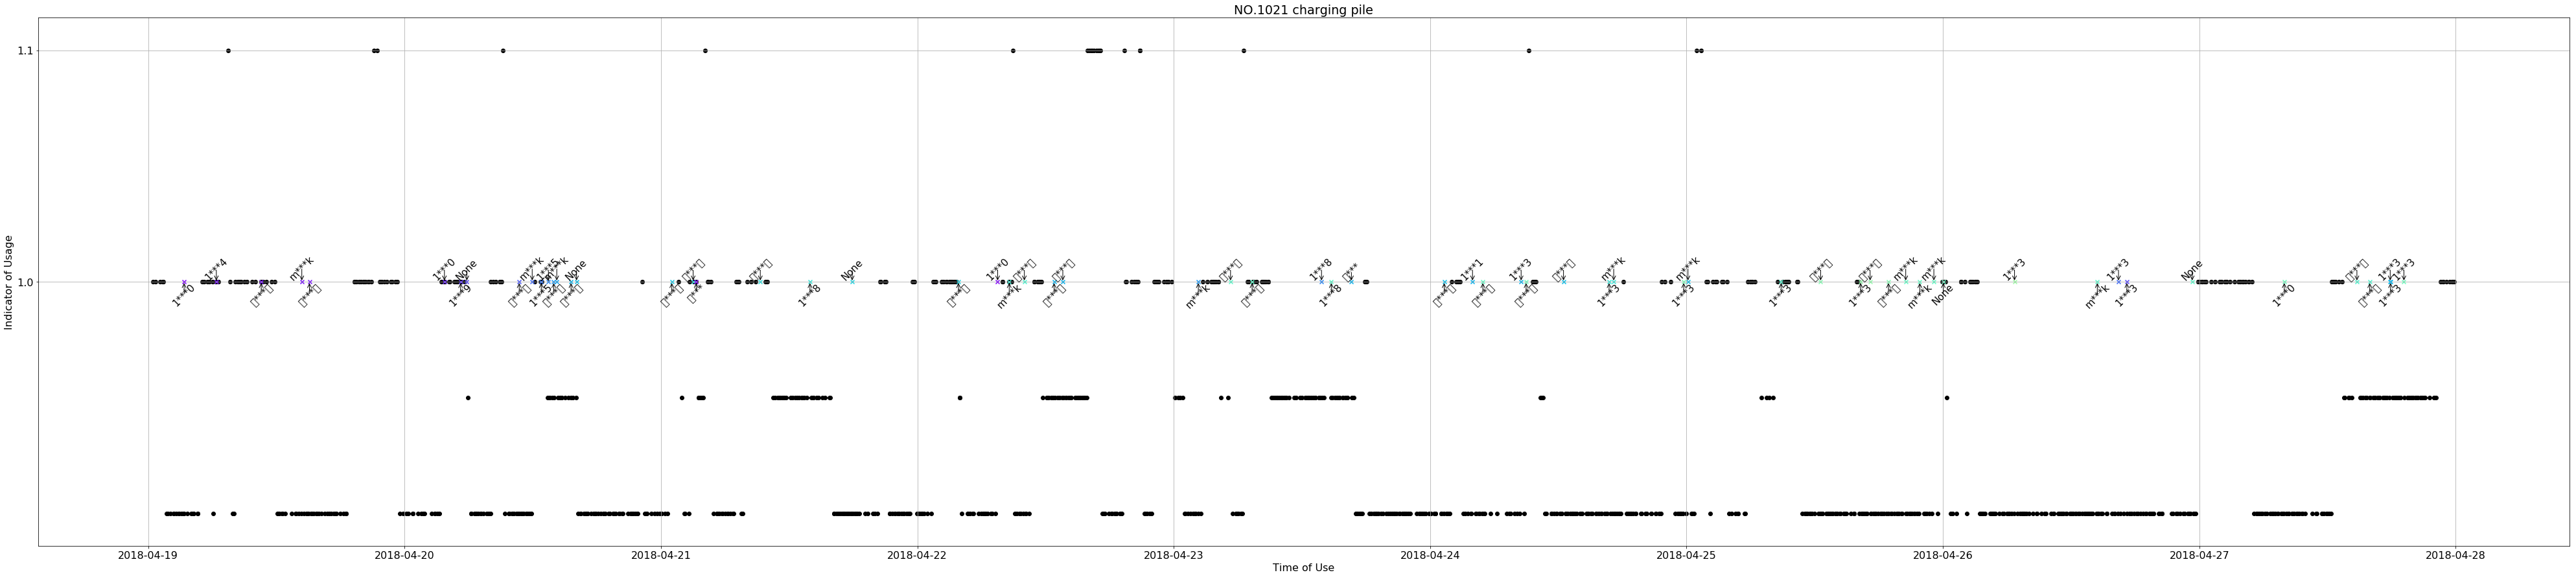

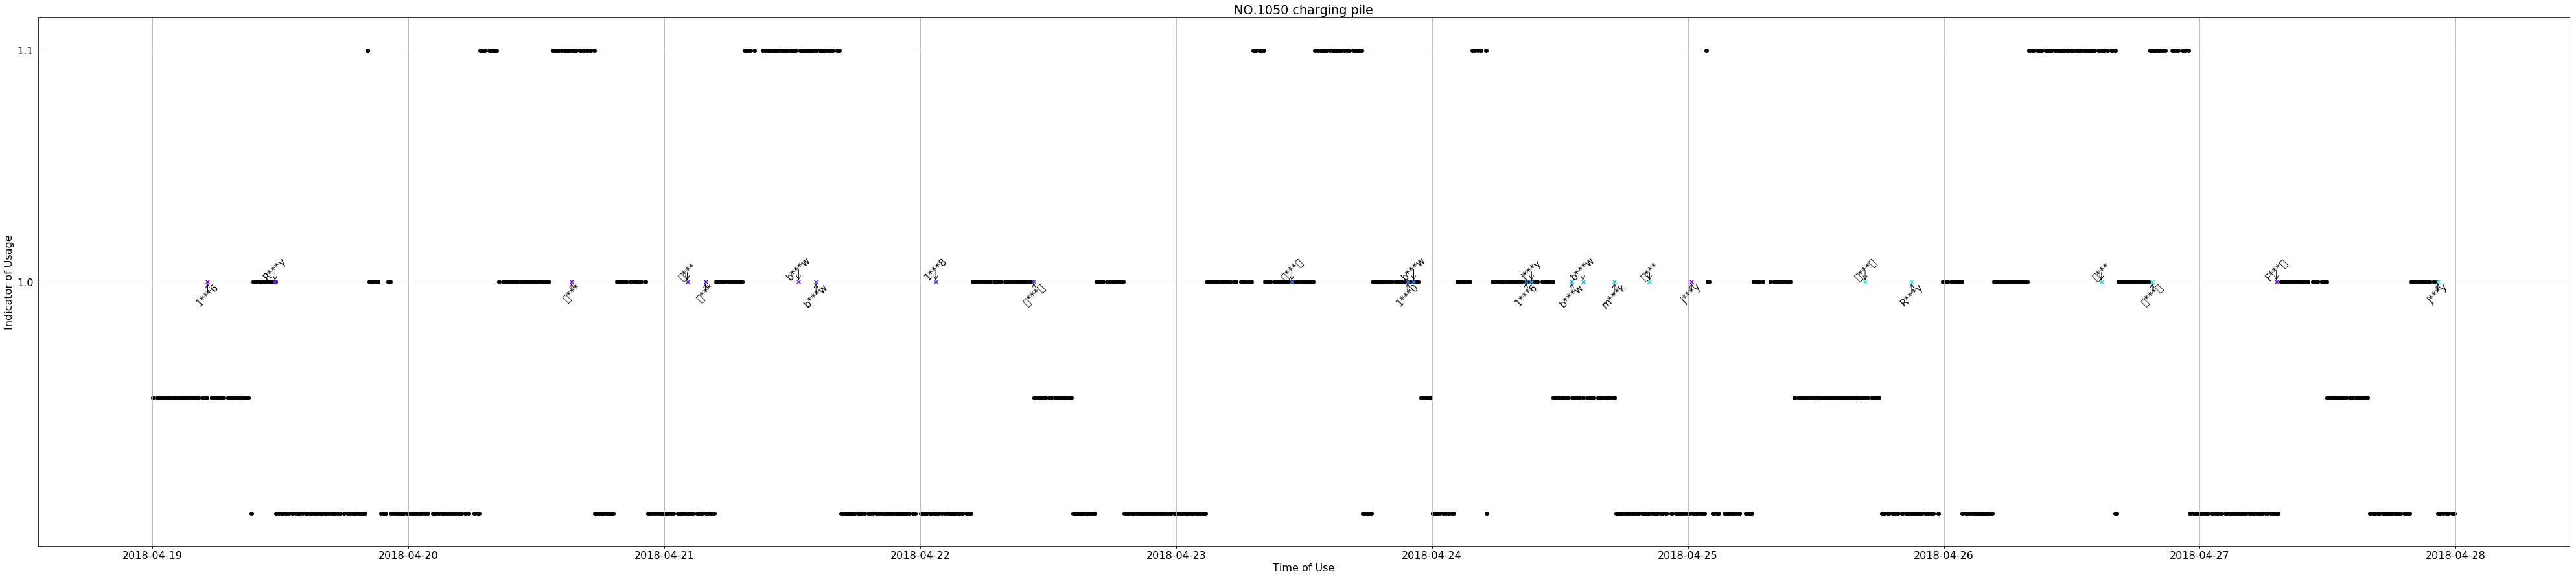

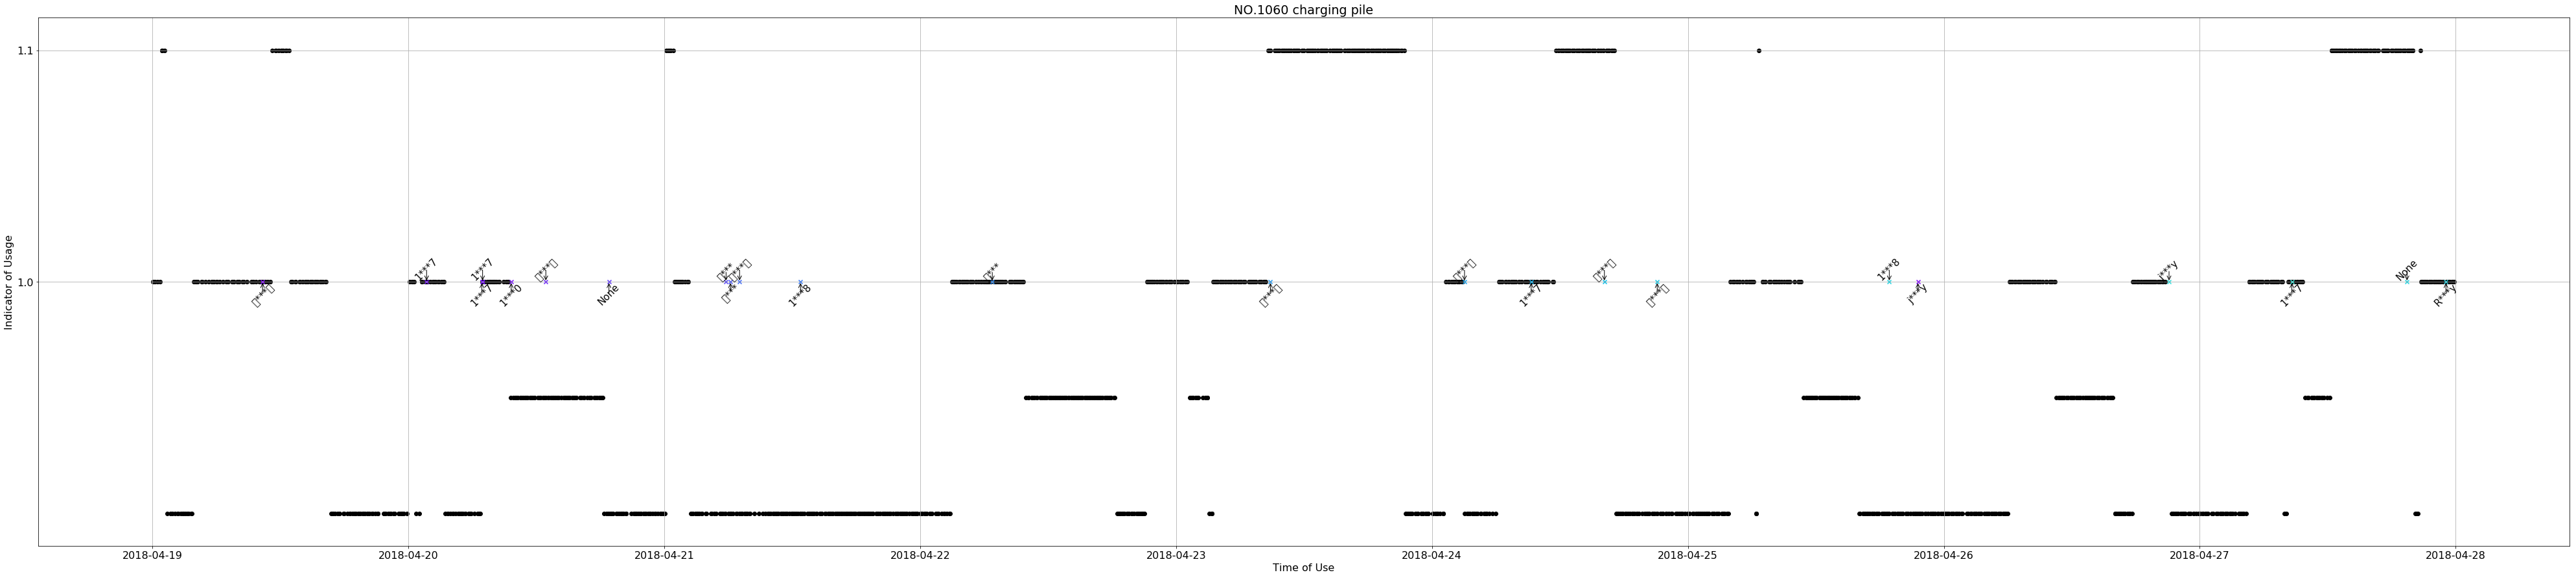

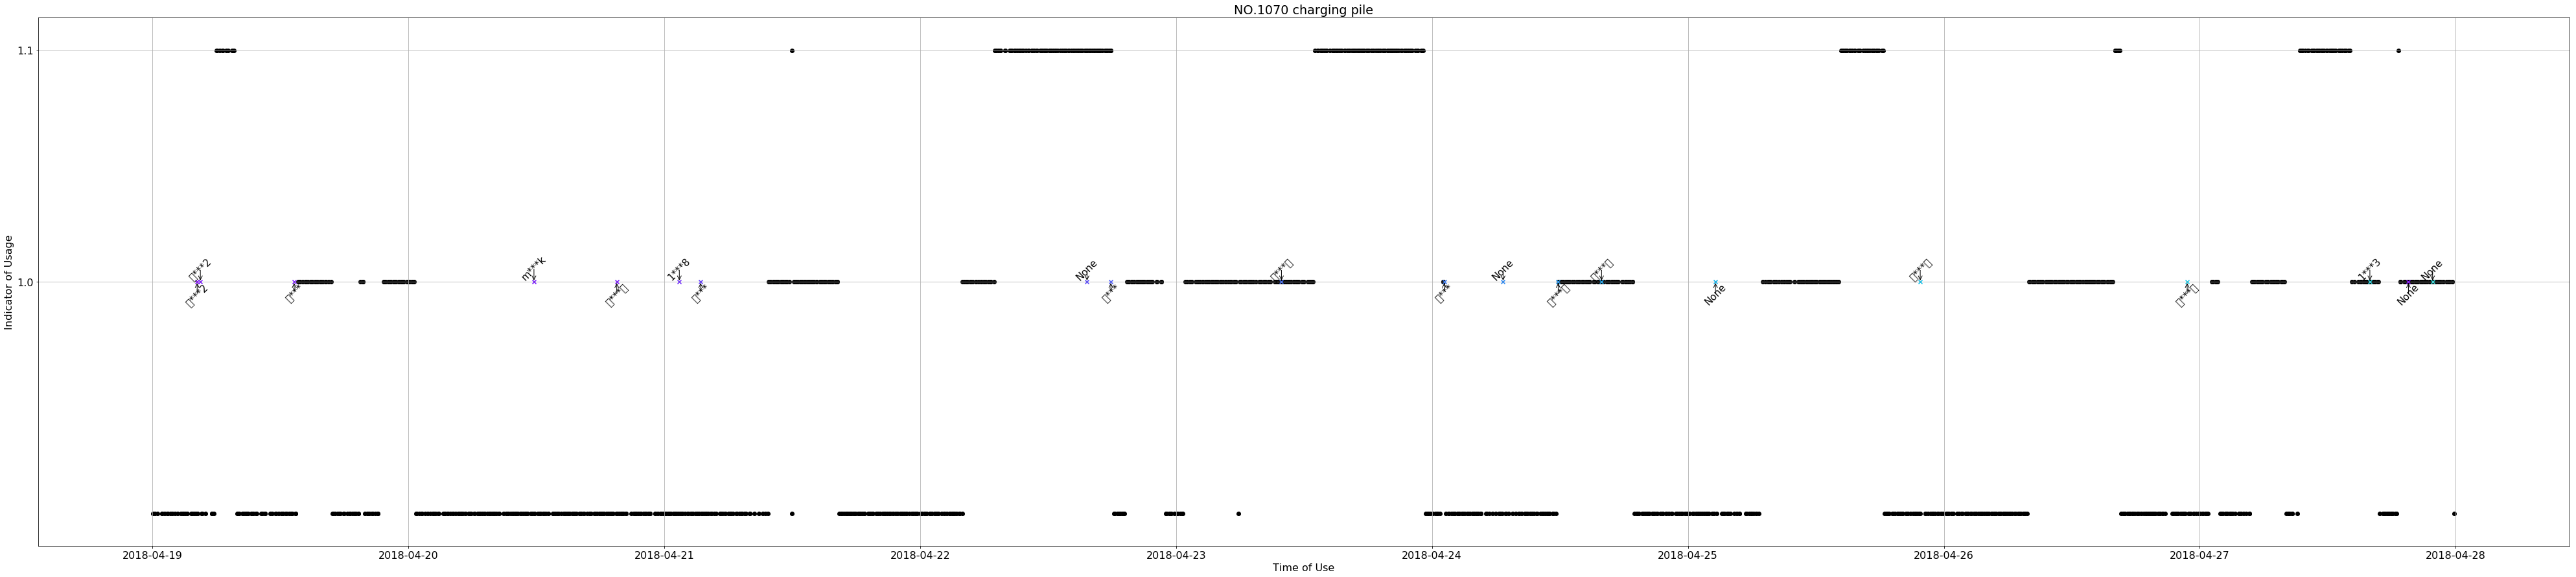

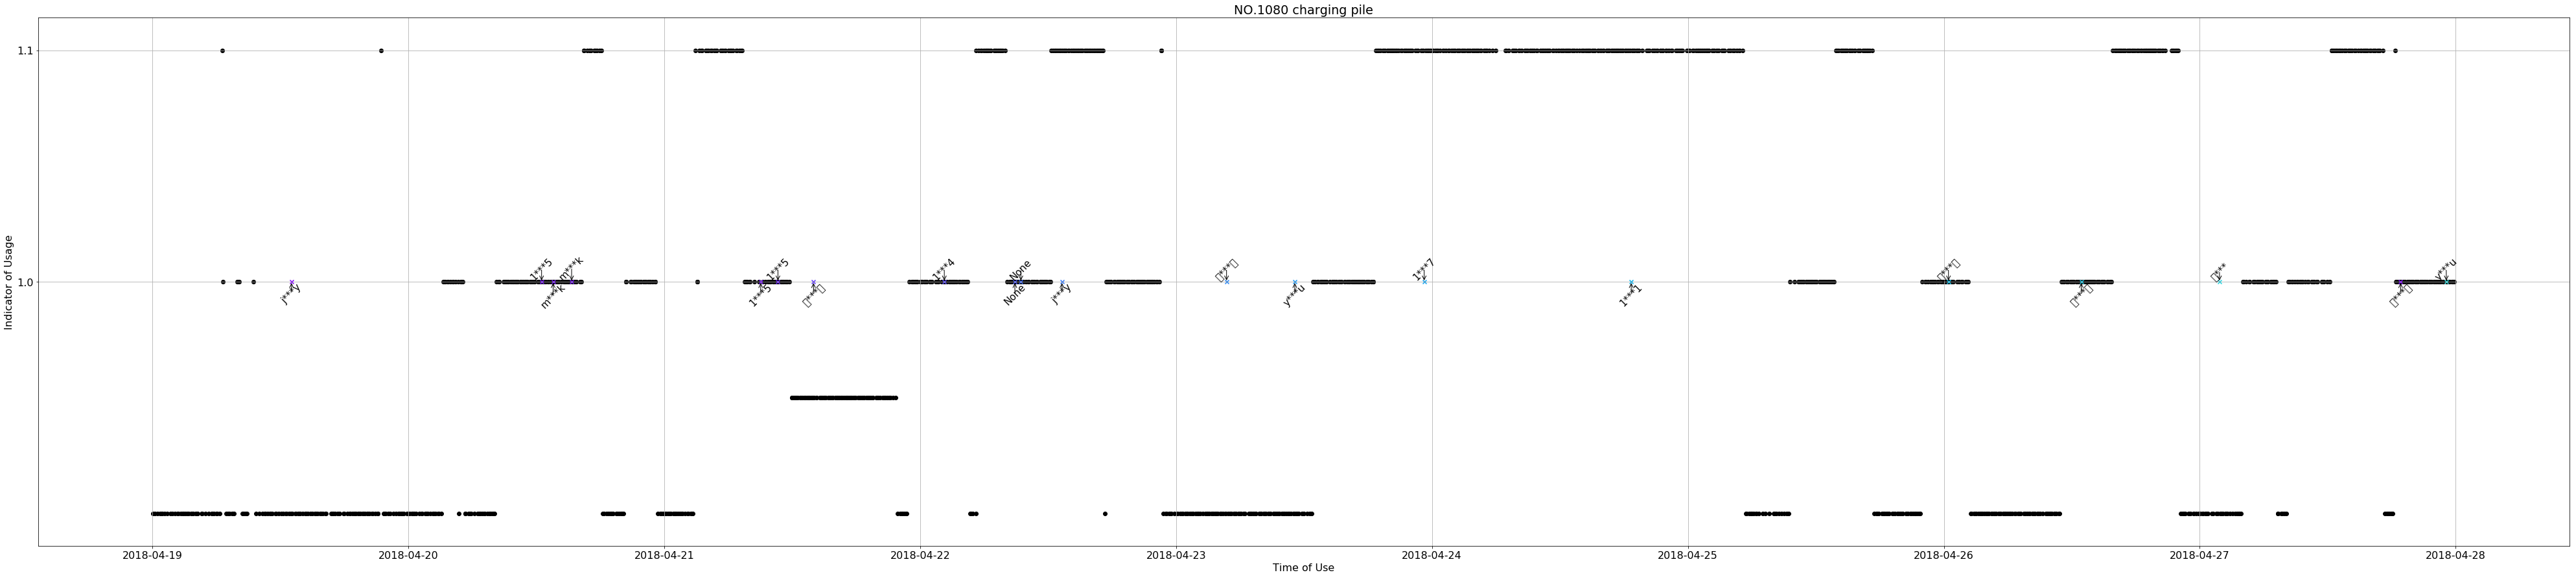

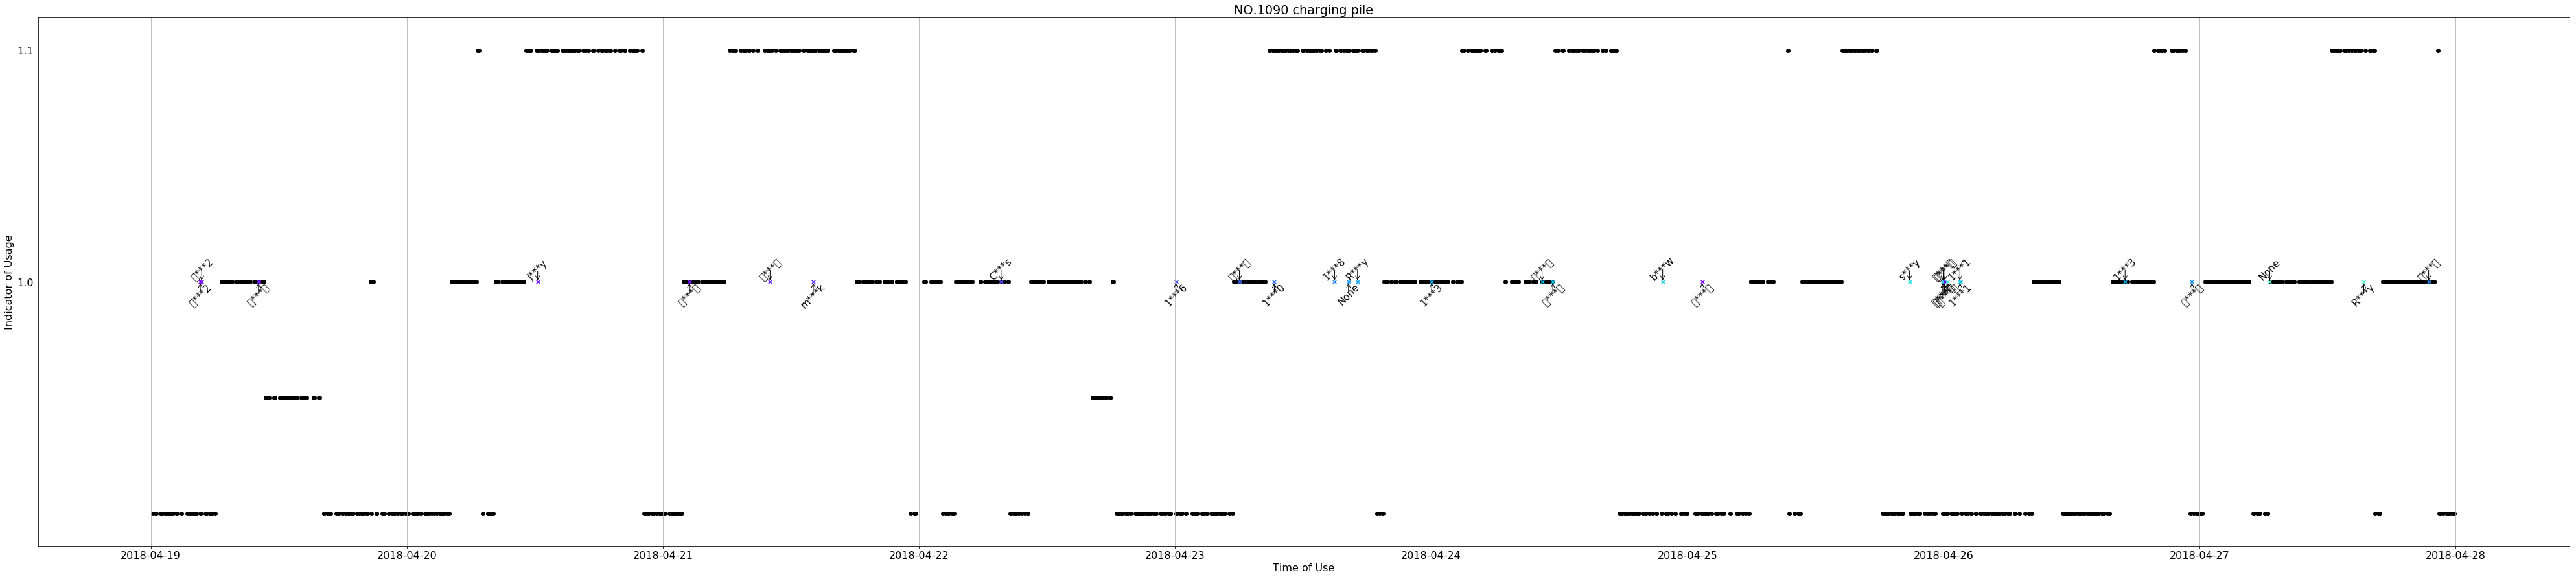

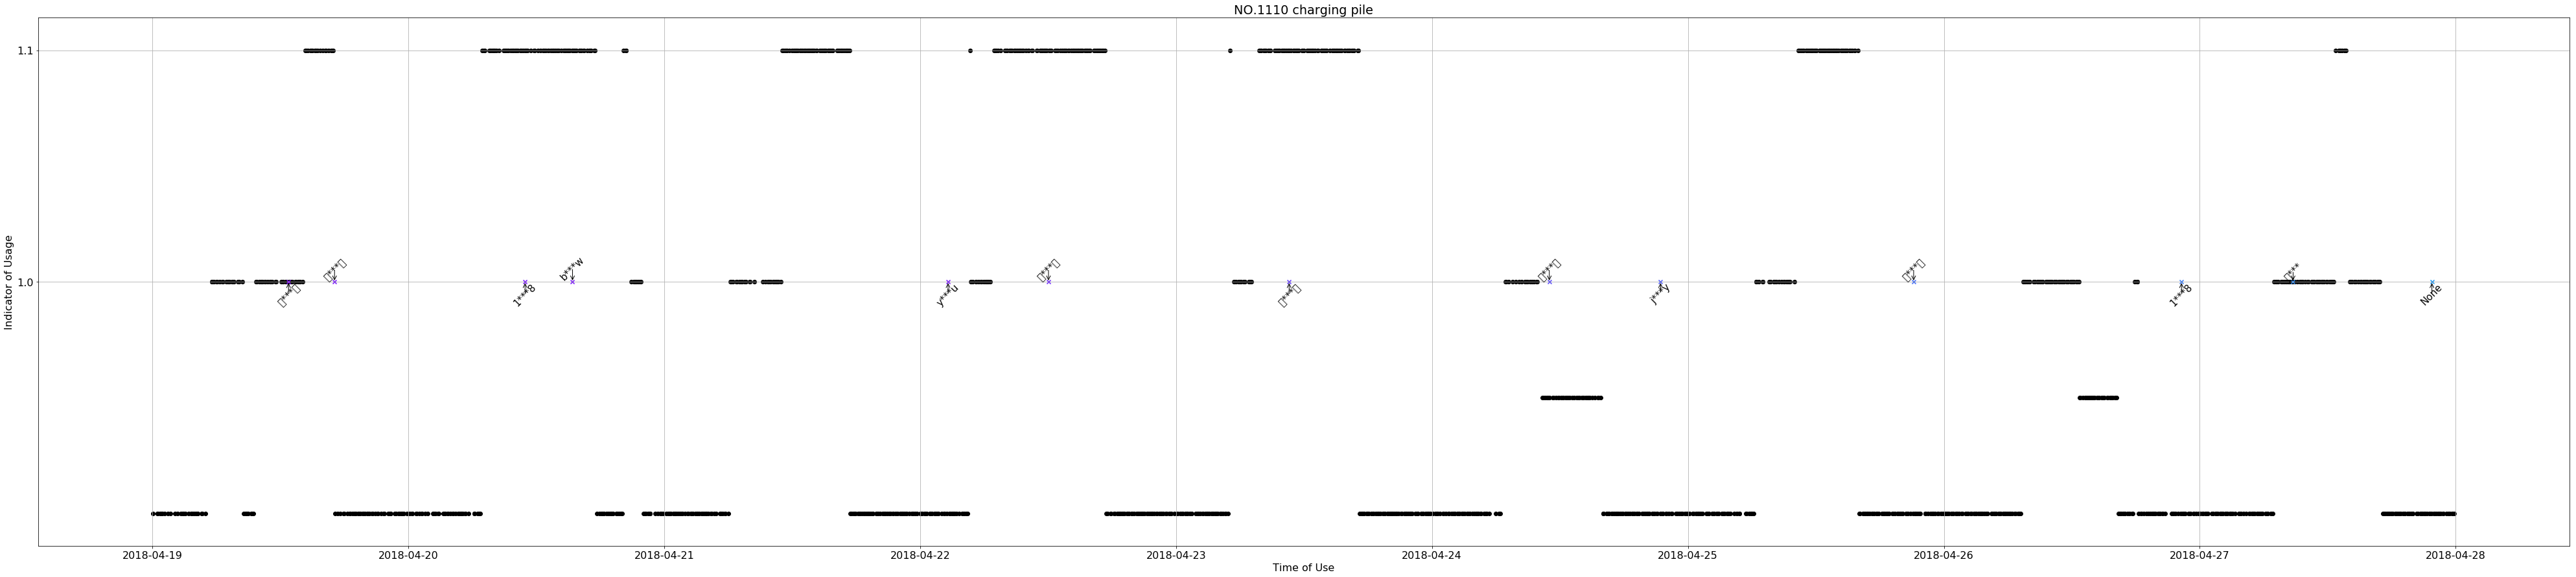

In [60]:
interestOFPile_list = np.unique([x_user[i][1] for i in range(len(x_user))])
for interestOFPile in interestOFPile_list:
    
    plt.figure(figsize=(70, 15))
#     plt.figure(figsize=(20, 12))
    plt.rc('font',size=16)
    
    #extract time data and indicator of usage data from x_pile
    x_pile_interestOF = list()
    y_pile_interestOF = list()
    for i in range(len(x_pile)):
        if x_pile[i][1] == interestOFPile[:-1]:
            x_pile_interestOF.append(x_pile[i][0])
            y_pile_interestOF.append(y_pile[i])
    
    #extract time data from user
    x_user_interestOF = [(x_user[i][0], x_user[i][-1]) for i in range(len(x_user)) \
                         if x_user[i][1] == interestOFPile]
    
    #plot pile utilization information
    plt.scatter(x_pile_interestOF, y_pile_interestOF, label="Pile", c='k')

    #plot user specific usage information
    for i in range(len(x_user_interestOF)):
        username = x_user[i][-1]
        user_idx = unique_user_list.index(username)
        plt.scatter(x_user_interestOF[i][0], chargingInd, label="User "+str(user_idx), 
                    c=colors[user_idx], marker="x")
        
    #add user name note to each point
    va_list = ["top", "bottom"]
    va_idx = 0
    va_func = lambda x: 1 if x == 0 else 0
    for idx in range(len(x_user_interestOF)):
        if x_user_interestOF[idx][1] is None:
            plt.annotate(x_user_interestOF[idx][1], (x_user_interestOF[idx][0], 1), 
                         ha="center", va=va_list[va_idx], rotation=45, 
                         size=15, arrowprops=dict(arrowstyle="->"))
            va_idx = va_func(va_idx)
        else:
            plt.annotate(x_user_interestOF[idx][1].decode("utf8"), (x_user_interestOF[idx][0], 1), 
                         ha="center", va=va_list[va_idx], rotation=45, 
                         size=15, arrowprops=dict(arrowstyle="->"))
            va_idx = va_func(va_idx)
    plt.xlabel("Time of Use")
    plt.ylabel("Indicator of Usage")
    plt.yticks([1, 1.1])
    plt.title("NO.{} charging pile".format(interestOFPile))
#     plt.legend()
    plt.grid()
    plt.show()

# Unique user usage profile

In [61]:
def check_consecUser(x_user_interestOF):
    """
        Return a numpy array of 
            names that appear consecutively
            number of times the name appear in consecutive
    """
    
    username_list = [x_user_interestOF[i][1] for i in range(len(x_user_interestOF))]
    
    #check for consecutive apprearance
    indicator = False
    consec_name_list = np.array([])
    consec_times_list = np.array([])
    current_user = ""
    current_appearance = 0
    
    for username in username_list:
        if current_user == username:
            current_appearance += 1
        elif current_appearance > 0:
            consec_name_list.append(current_user)
            consec_times_list.append(current_appearance)
            current_user = username
            current_appearance = 0
    return consec_name_list, consec_times_list

In [307]:
#user usage dictionary, 
#{'UserID': [(starttime, endtime, piletype/power) ...]} - v1.0 
# important to find the endtime of user

#{'UserID': [({'statusTime':[...], 'statusInd': : [...]}, piletype/power), (...), ...]} - v1.1
# do not identify charging time in this run

#{'UserID': [({'statusTime':[...], 'statusInd': : [...]}, pile), (...), ...]} - v1.2
# do not identify charging time in this run

#initiate the userUsage dictionary
userUsage_dict = dict()
for user in unique_user_list:
    userUsage_dict[user] = list()

interestOFPile_list = np.unique([x_user[i][1] for i in range(len(x_user))])
for interestOFPile in interestOFPile_list:
    
    x_pile_interestOF = list()
    y_pile_interestOF = list()
    
    #pile type'0'means AC 7kW, '1'means DC 40kW
    #pileType = interestOFPile[-1] - v1.1
    
    for i in range(len(x_pile)):
        
        if x_pile[i][1] == interestOFPile[:-1]:
            x_pile_interestOF.append(x_pile[i][0])
            y_pile_interestOF.append(y_pile[i])
    
    #extract time data from user
    x_user_interestOF = [(x_user[i][0], x_user[i][-1]) for i in range(len(x_user)) \
                         if x_user[i][1] == interestOFPile]
    
    #check for consecutive username appearance
    consec_name_list, consec_times_list = check_consecUser(x_user_interestOF)
    
    idxIgnore = list()
    #iterate through all user usage data
    for s_idx, s_usage in enumerate(x_user_interestOF):
        
        #check if idx belongs to one of the consec appearance
        if s_idx not in idxIgnore:
                
            starttime = s_usage[0]
            username = s_usage[1]

            #NOTE: assuming same name does not appear consecutively in multiple different time period
            if username in consec_name_list:
                appearTime = consec_times_list[consec_name_list.index(username)]
            else:
                appearTime = 0
            
            statusTime_list = list()
            statusInd_list = list()

            if s_idx < len(x_user_interestOF)-appearTime-1:
                #find the loosest constraint, endtime is when next user come and plug in
                nextUser_starttime = x_user_interestOF[s_idx+appearTime+1][0]
            else:
                nextUser_starttime = interestOFDate_end
            #look for endtime
            for p_idx, p_time in enumerate(x_pile_interestOF):
                #look for the period in between current user and next user
                if p_time < starttime:
                    pass
                elif p_time > nextUser_starttime:
                    pass
                else:
                    statusTime_list.append(p_time)
                    statusInd_list.append(y_pile_interestOF[p_idx])

            usageDict_temp = {"statusTime": np.array(statusTime_list), "statusInd": np.array(statusInd_list)}
            userUsage_dict[username].append((usageDict_temp, interestOFPile))

# Calculate low resolution of charging activity profiles for users

In [136]:
for _ in unique_user_list:
    print(_)

1***0
新***2
1***6
1***4
戴***生
辉***哥
老***机
R***y
黄***喜
j***y
王***
m***k
称***号
朱***哥
1***7
1***9
None
王***志
1***8
1***5
光***
b***w
仲***文
覃***
刘***军
刘***泘
y***u
C***s
顺***辉
温***
破***园
深***区
庄***
1***3
杨***
陈***郁
1***1
刘***飞
穿***猫
s***y
F***恒
中***猪
夏***柜
.***.
v***s
A***n


In [308]:
# (arrialTime, chargingStarttime, chargingDuration, plugInTime, plugInduration, leaveTime, pile)
userUsage_dict_lowresol = dict()
for user in unique_user_list:
    userUsage_dict_lowresol[user] = list()

for user in unique_user_list:
    for idx, session in enumerate(userUsage_dict[user]):
        
        chargingIdx_list = np.where(session[0]["statusInd"] == chargingInd)[0]
        pluggedInIdx_list = np.where(session[0]["statusInd"] == pluggedInInd)[0]
        fullyChargedInd_list = np.where(session[0]["statusInd"] == fullyChargedInd)[0]
        totConnected_list = fullyChargedInd_list.tolist() + pluggedInIdx_list.tolist()
        
        if len(session[0]["statusTime"]) > 0:
            arrialTime = session[0]["statusTime"][0]
            
            if len(chargingIdx_list) > 0:
                chargingStartTime = session[0]["statusTime"][chargingIdx_list][0]
            else:
                chargingStartTime = None

            chargingDuration = len(chargingIdx_list) * datetime.timedelta(minutes=15)

            plugInduration = (len(pluggedInIdx_list) + len(fullyChargedInd_list)) \
            * datetime.timedelta(minutes=15) + chargingDuration

            #find the most recent index of activity, taking both charging and plugged in into account.
            if len(chargingIdx_list) > 0 and len(totConnected_list) > 0:
                plugIdx = min(min(chargingIdx_list), min(totConnected_list))
                leaveIdx = max(max(chargingIdx_list), max(totConnected_list))
            elif len(chargingIdx_list) > 0 and len(totConnected_list) == 0:
                plugIdx = min(chargingIdx_list)
                leaveIdx = max(chargingIdx_list)
            elif len(chargingIdx_list) == 0 and len(totConnected_list) > 0:
                plugIdx = min(totConnected_list)
                leaveIdx = max(totConnected_list)
            else:
                plugIdx = -1
                plugInTime = None
                leaveIdx = -1
            
            #specify plug in time
            if plugIdx != -1:
                plugInTime = session[0]["statusTime"][plugIdx]
                
            #specify leave time
            if leaveIdx == -1:
                leaveTime = chargingStartTime
            elif leaveIdx < len(session[0]["statusTime"])-1:
                leaveTime = session[0]["statusTime"][leaveIdx+1]
            else:
                leaveTime = session[0]["statusTime"][leaveIdx]

    #         session = session+(chargingStartTime, chargingDuration, plugInTime_total, leaveTime,)
            userUsage_dict_lowresol[user].append((arrialTime, chargingStartTime, chargingDuration, 
                                                  plugInTime, plugInduration, leaveTime, session[1]))
        

### Charging duration visualization

In [124]:
def calc_chargingSession(userUsage_dict_lowresol):
    sixHour = datetime.timedelta(0, 3600*6, 0)
    fiveHour = datetime.timedelta(0, 3600*5, 0)
    fourHour = datetime.timedelta(0, 3600*4, 0)
    threeHour = datetime.timedelta(0, 3600*3, 0)
    twoHour = datetime.timedelta(0, 3600*2, 0)
    oneHour = datetime.timedelta(0, 3600, 0)
    halfHour = datetime.timedelta(0, 1800, 0)
    tenmin = datetime.timedelta(0, 600, 0)
    
    for user in userUsage_dict_lowresol.keys():
        fast_chargingSession = list()
        slow_chargingSession = list()
        
        for session in userUsage_dict_lowresol[user]:
            
            #DC charging session checker
            isDC  = (session[-1] == "1")
            
            if session[1] > sixHour:
                if isDC:
                    fast_chargingSession.append(6)
                else:
                    slow_chargingSession.append(6)
                
            elif session[1] > fiveHour:
                if isDC:
                    fast_chargingSession.append(5)
                else:
                    slow_chargingSession.append(5)
                
            elif session[1] > fourHour:
                if isDC:
                    fast_chargingSession.append(4)
                else:
                    slow_chargingSession.append(4)

            elif session[1] > threeHour:
                if isDC:
                    fast_chargingSession.append(3)
                else:
                    slow_chargingSession.append(3)
                    
            elif session[1] > twoHour:
                if isDC:
                    fast_chargingSession.append(2)
                else:
                    slow_chargingSession.append(2)

            elif session[1] > oneHour:
                if isDC:
                    fast_chargingSession.append(1)
                else:
                    slow_chargingSession.append(1)
            elif session[1] > halfHour:
                if isDC:
                    fast_chargingSession.append(0.5)
                else:
                    slow_chargingSession.append(0.5)

            elif session[1] > tenmin:
                if isDC:
                    fast_chargingSession.append(0.16)
                else:
                    slow_chargingSession.append(0.16)
            else:
                if isDC:
                    fast_chargingSession.append(0)
                else:
                    slow_chargingSession.append(0)

        userUsage_dict_lowresol[user].append(fast_chargingSession) 
        userUsage_dict_lowresol[user].append(slow_chargingSession) 
    return userUsage_dict_lowresol

In [125]:
#get original userUsage_dict_lowresol before running below function
userUsage_dict_lowresol = calc_chargingSession(userUsage_dict_lowresol)

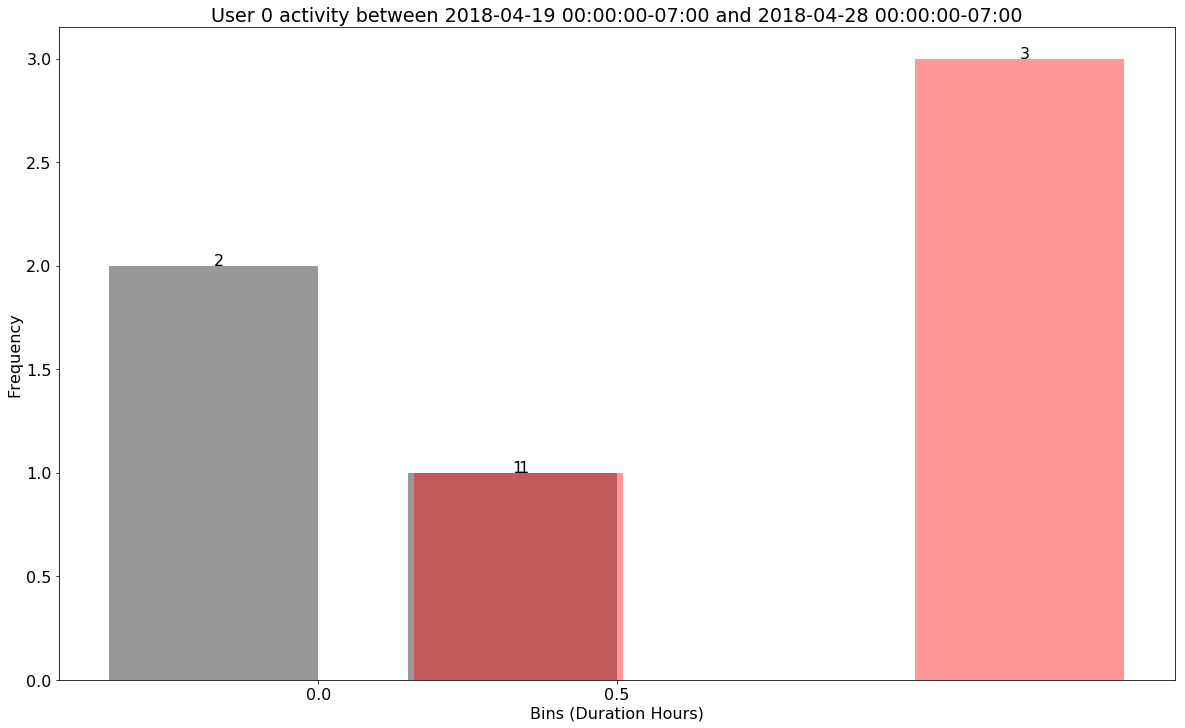

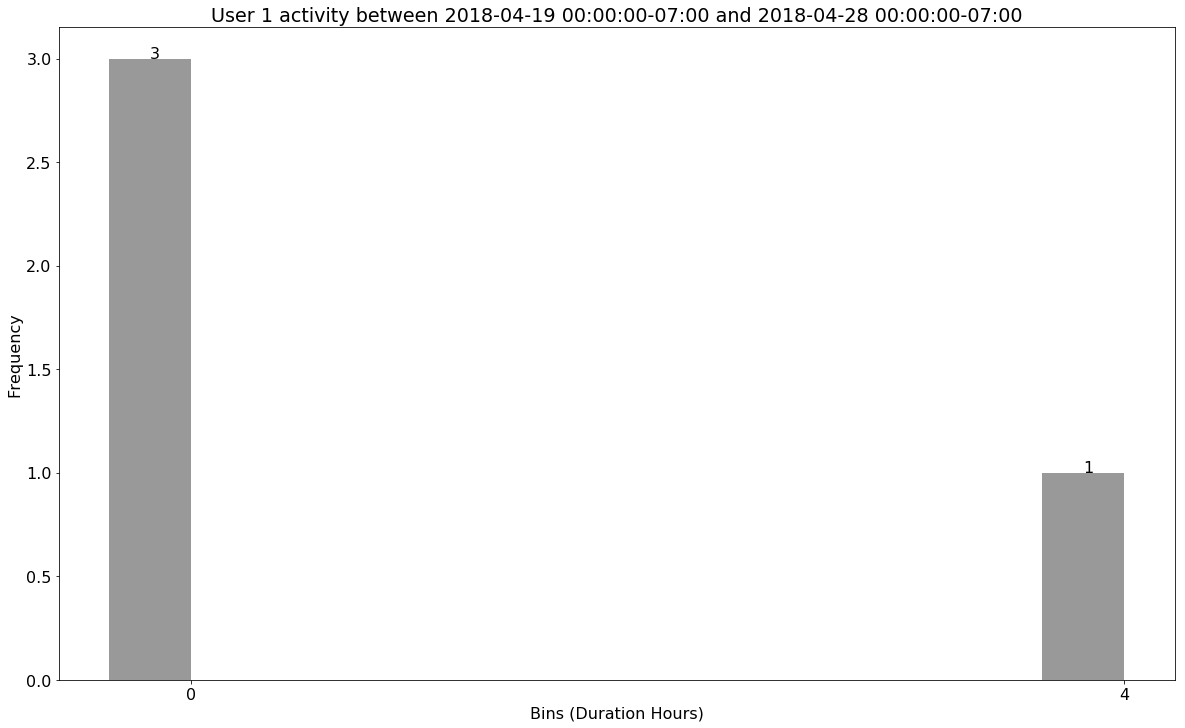

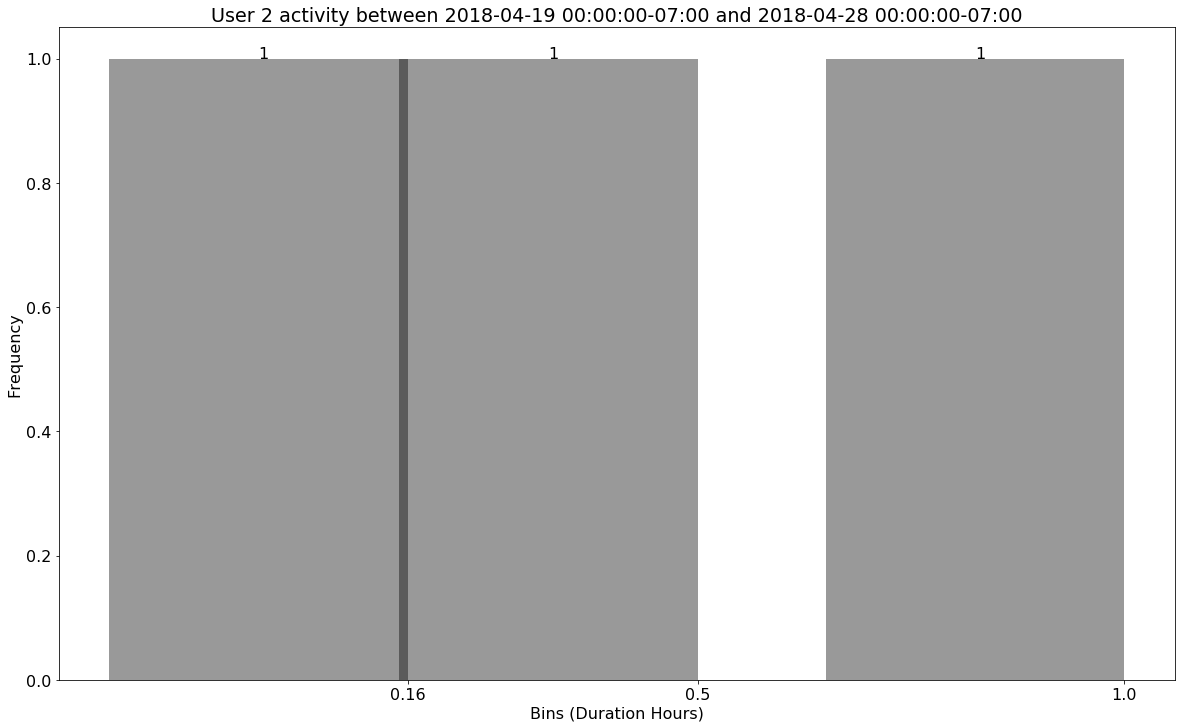

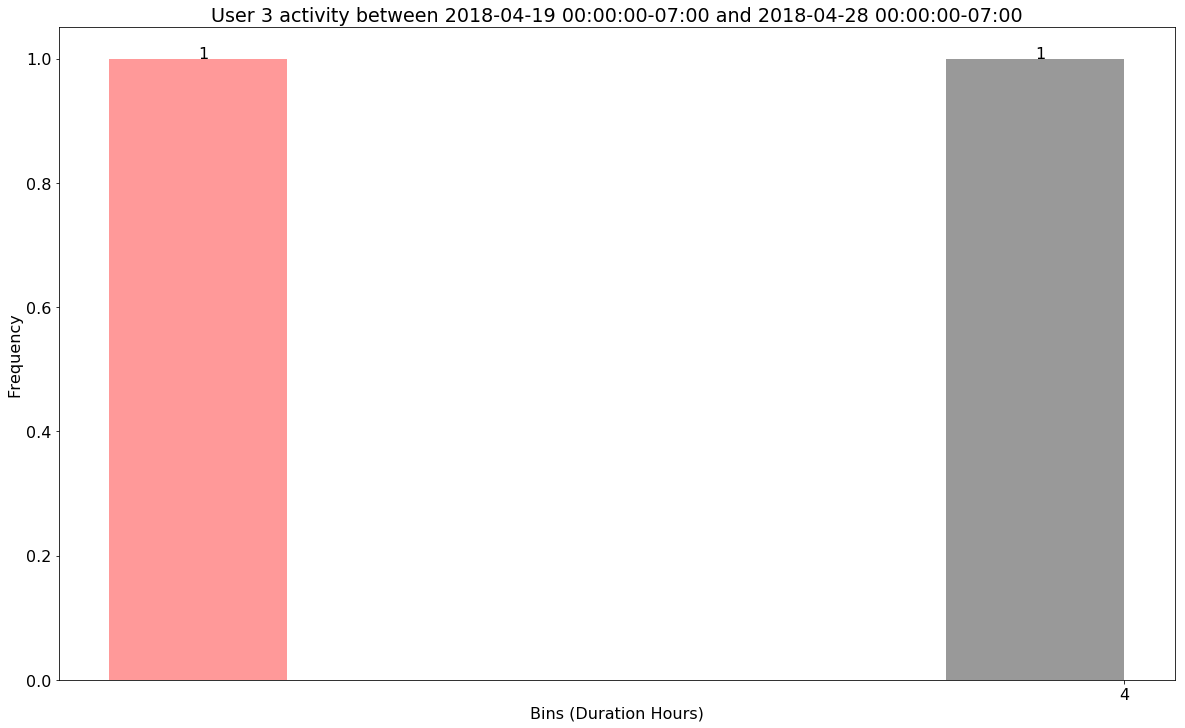

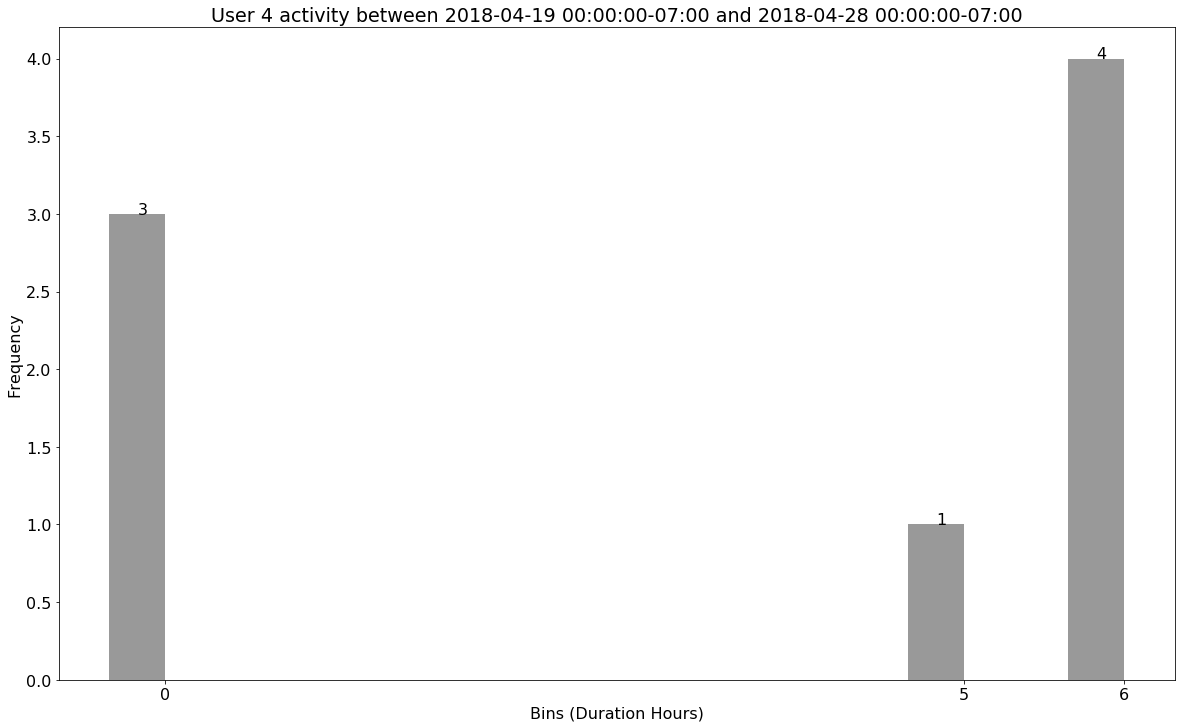

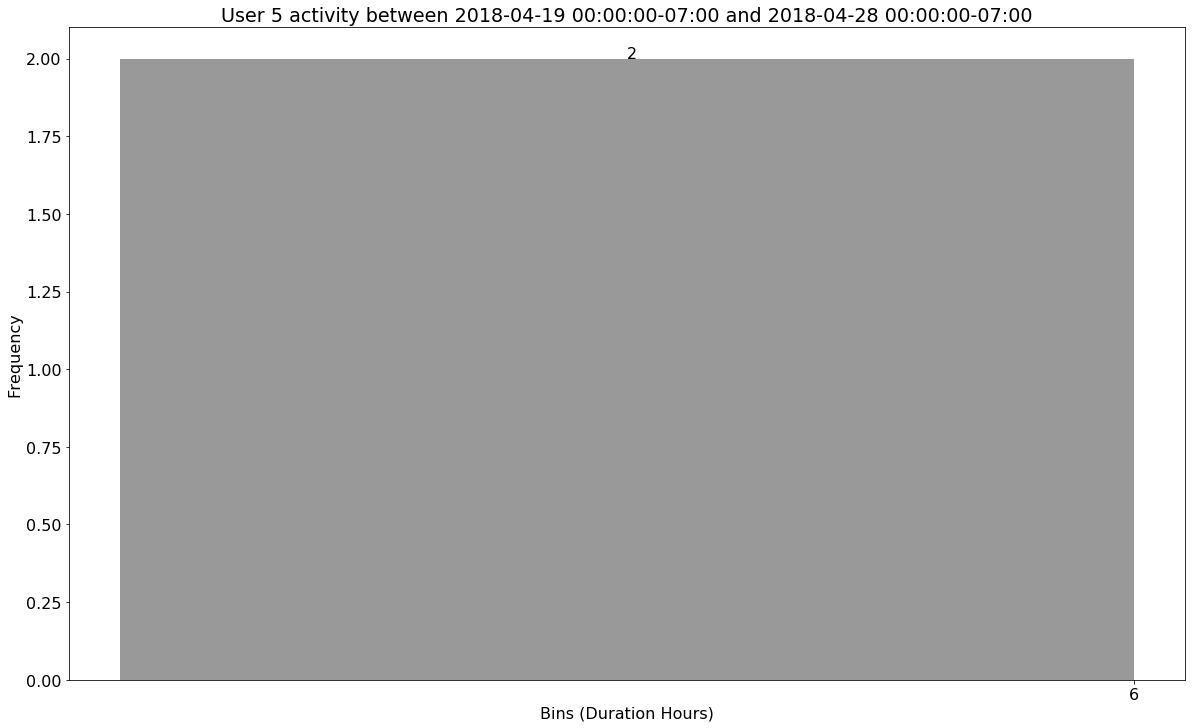

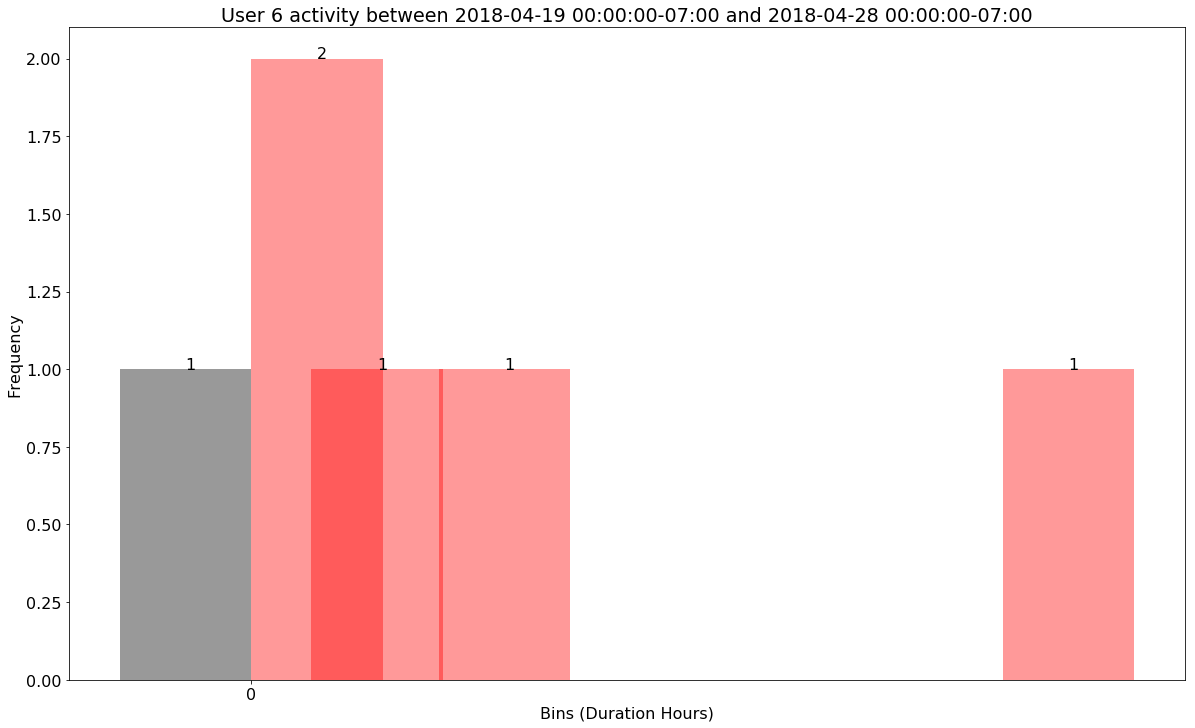

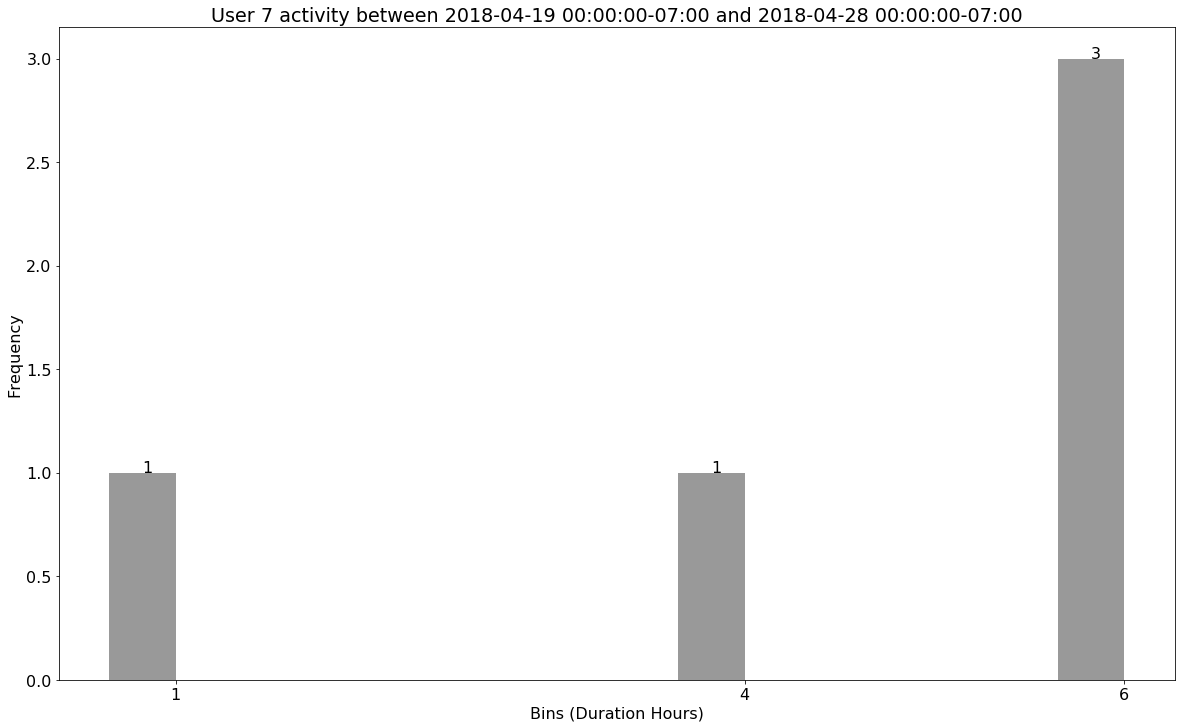

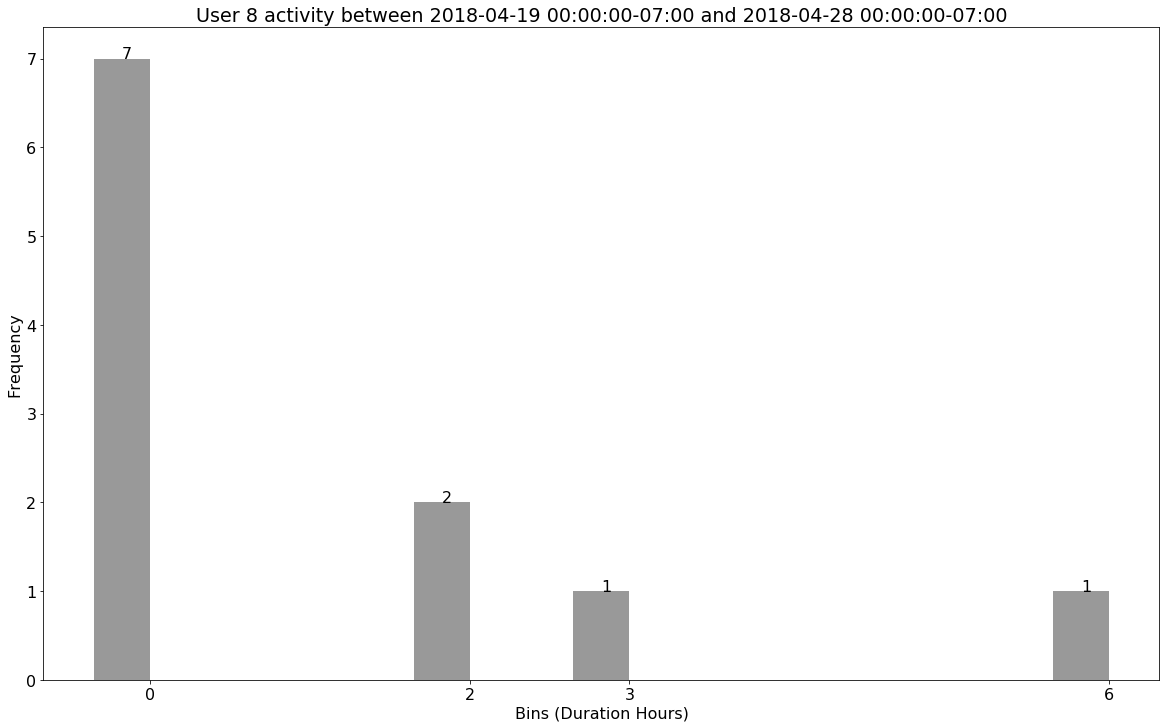

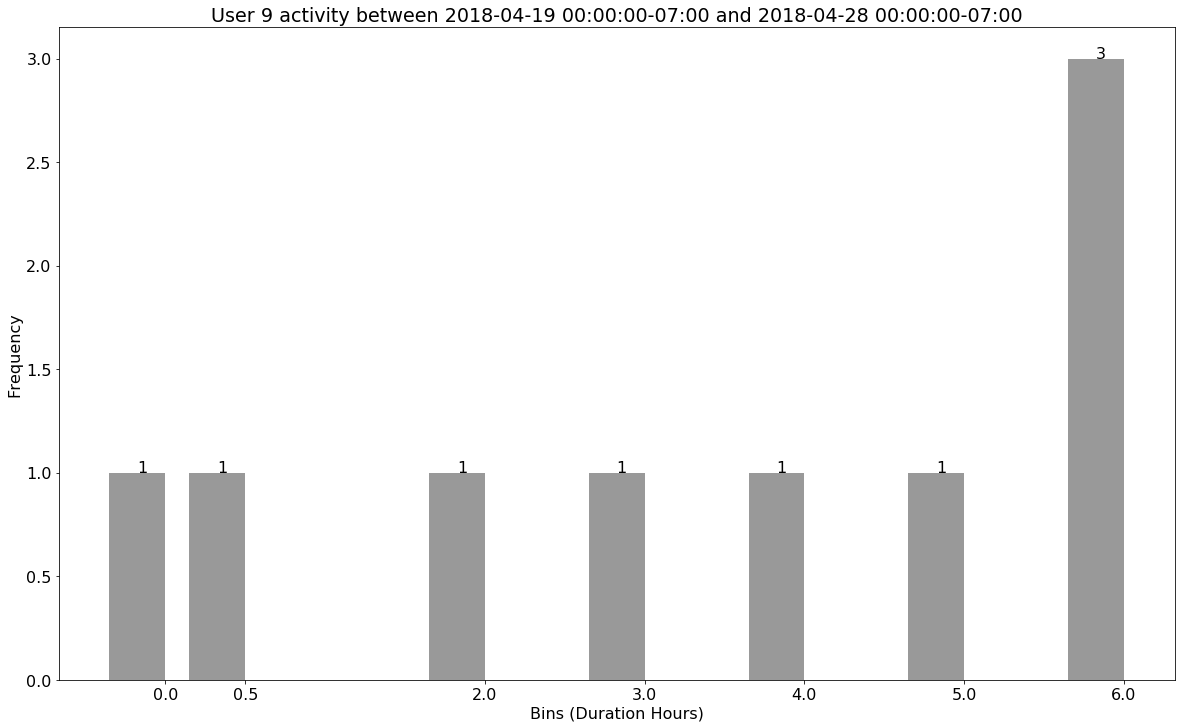

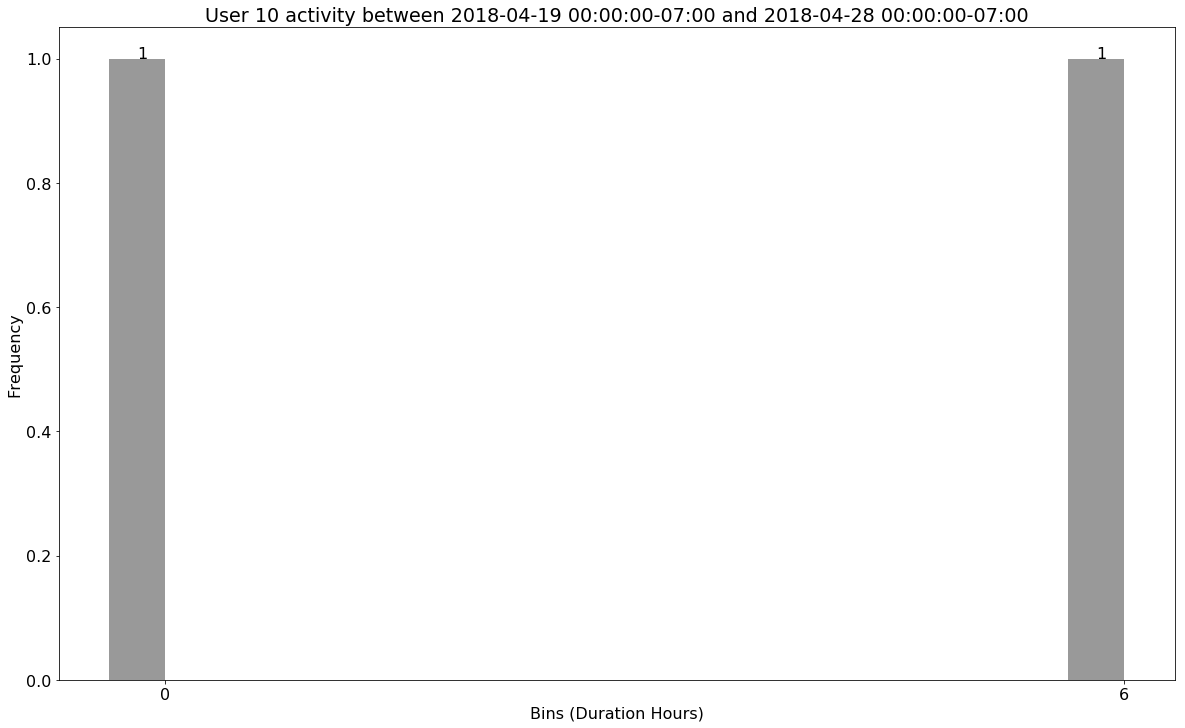

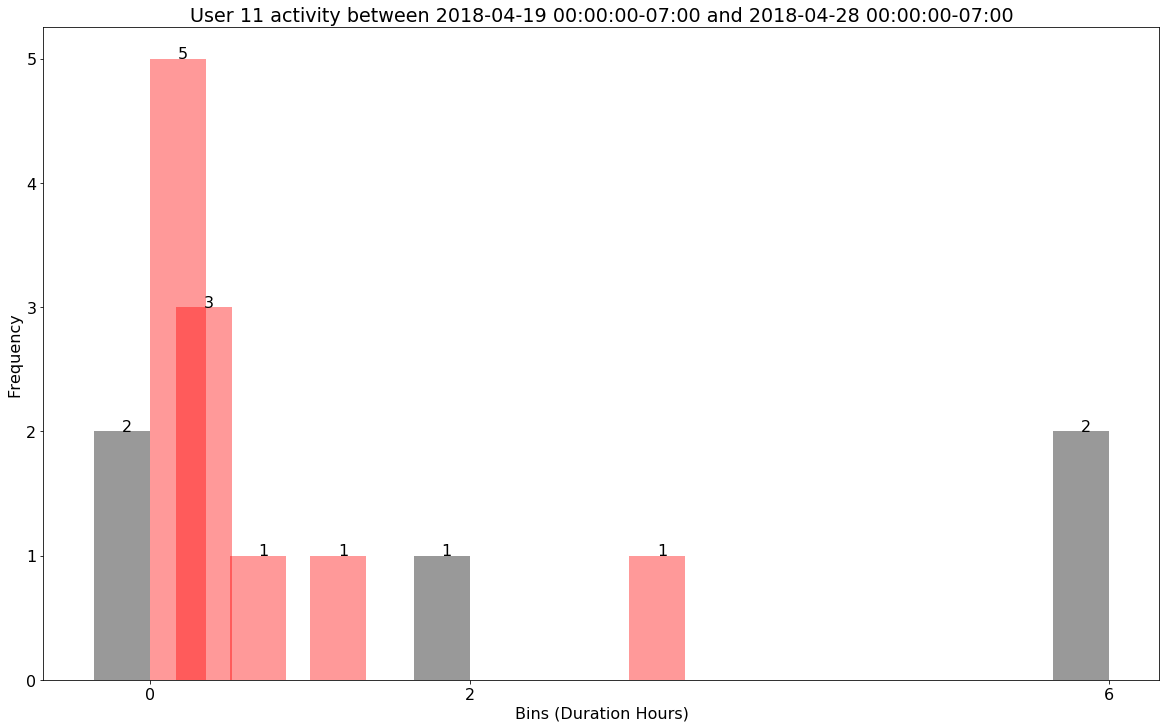

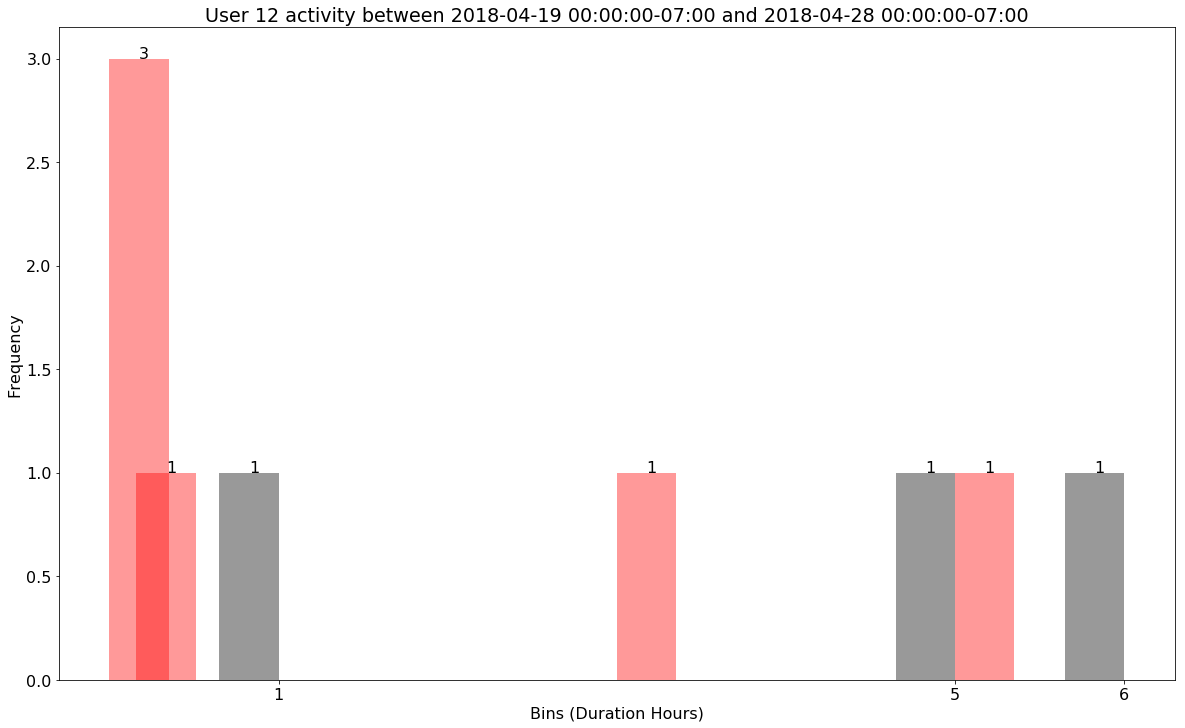

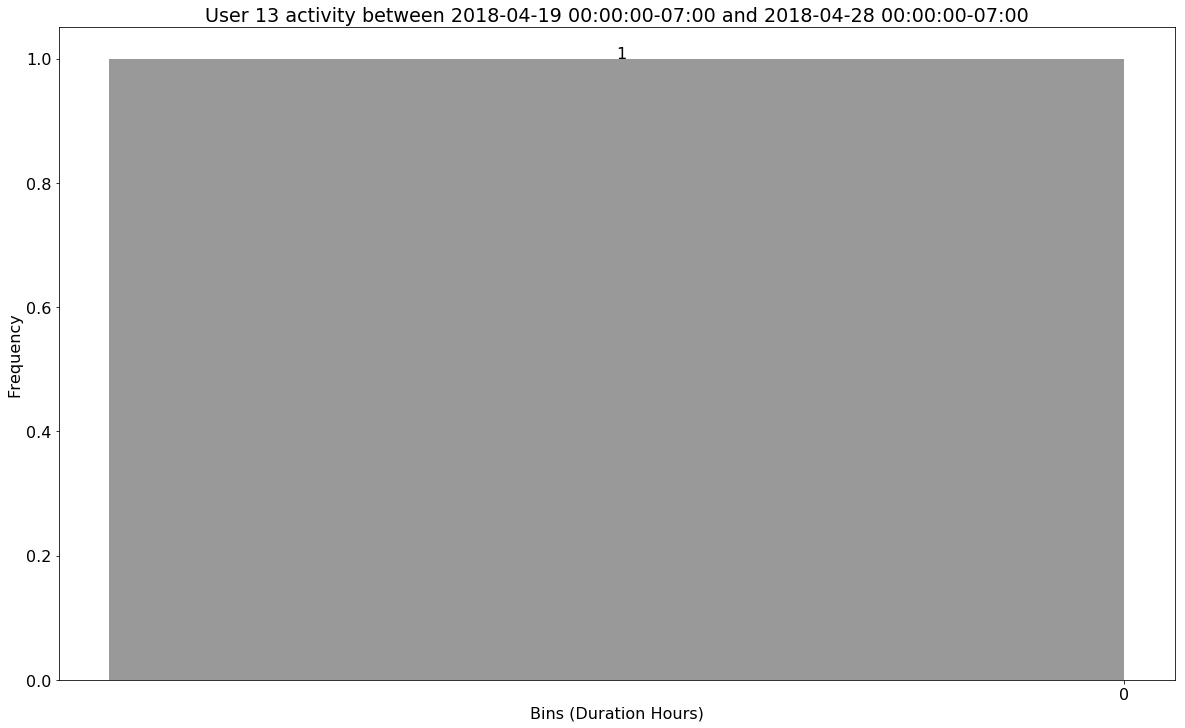

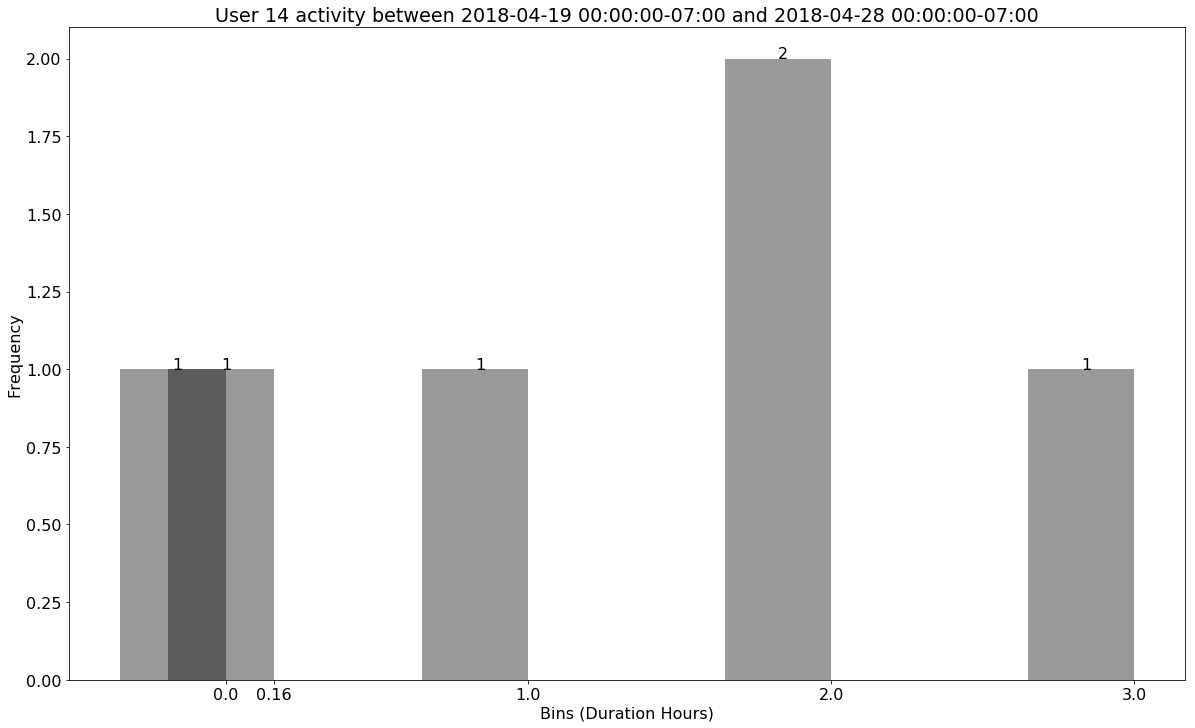

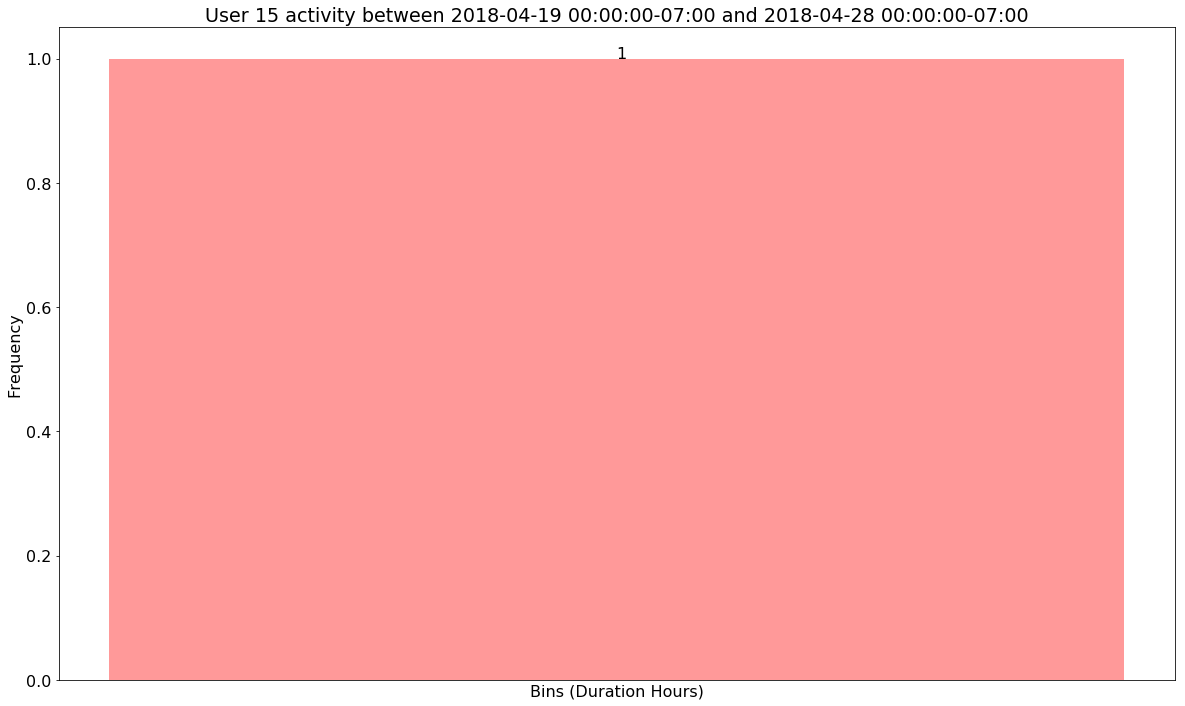

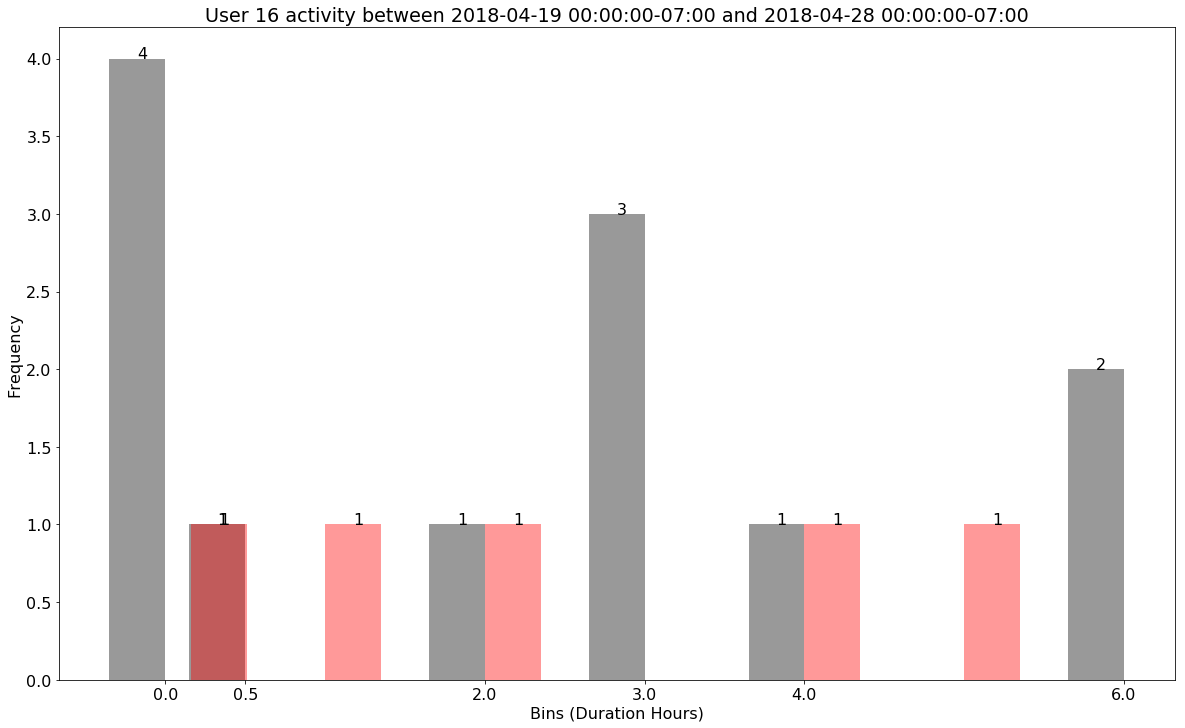

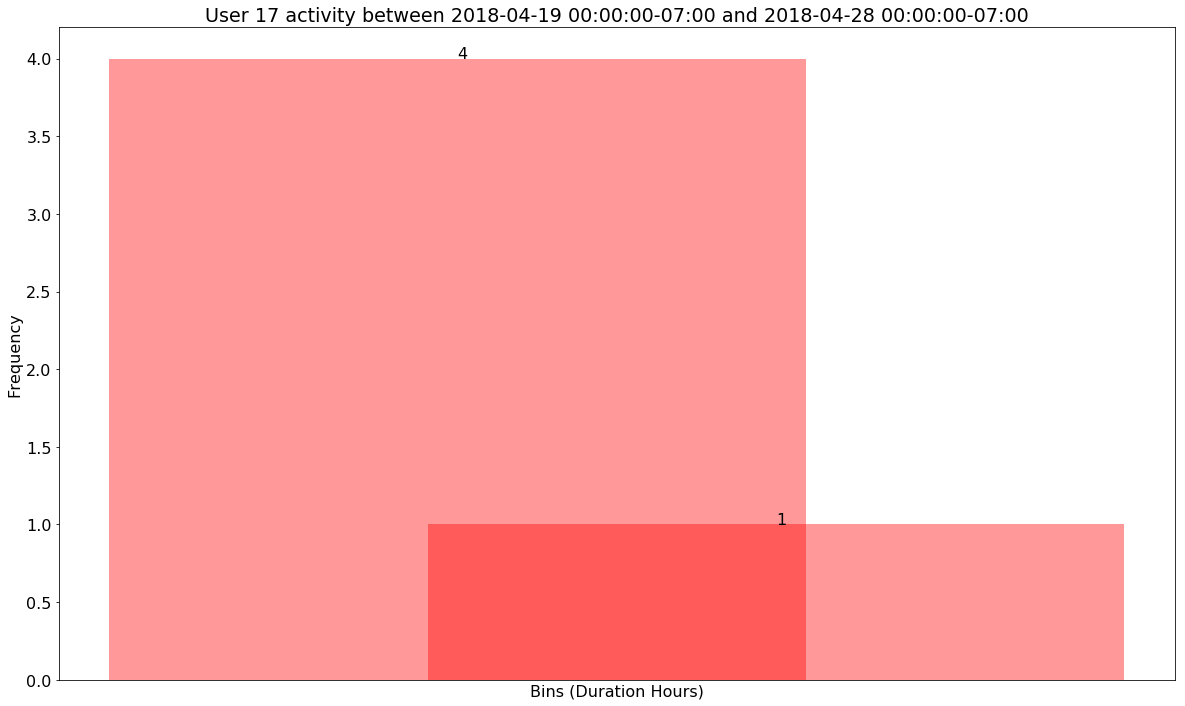

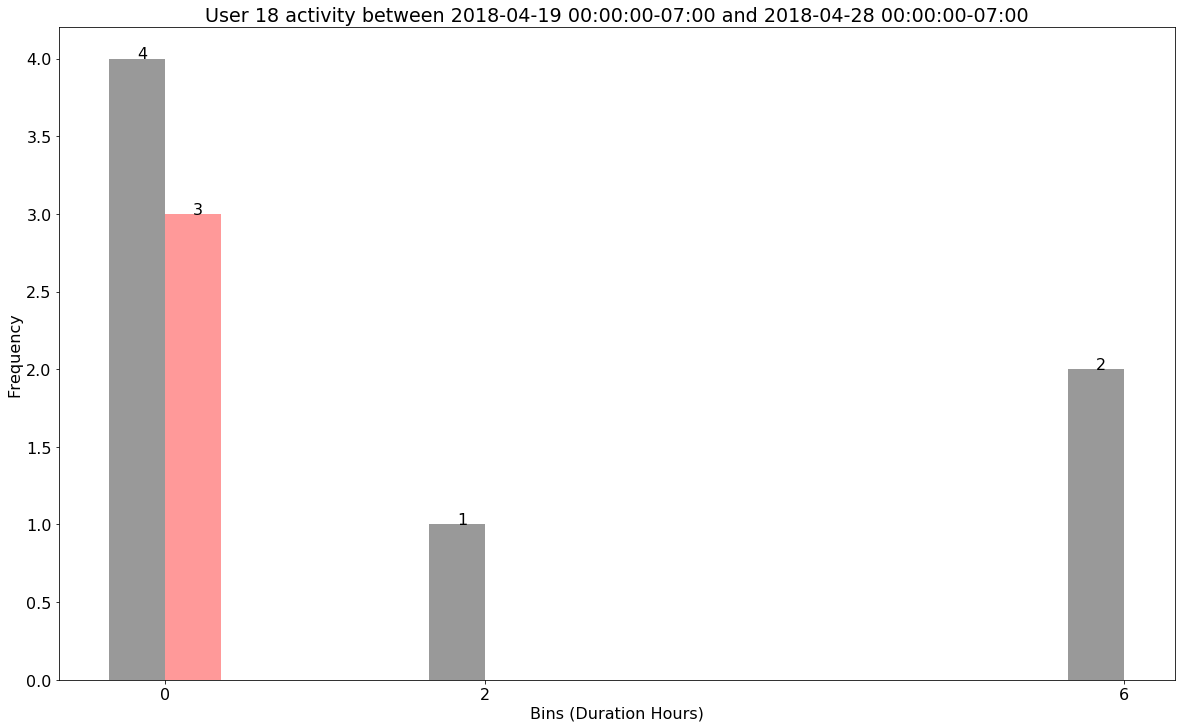

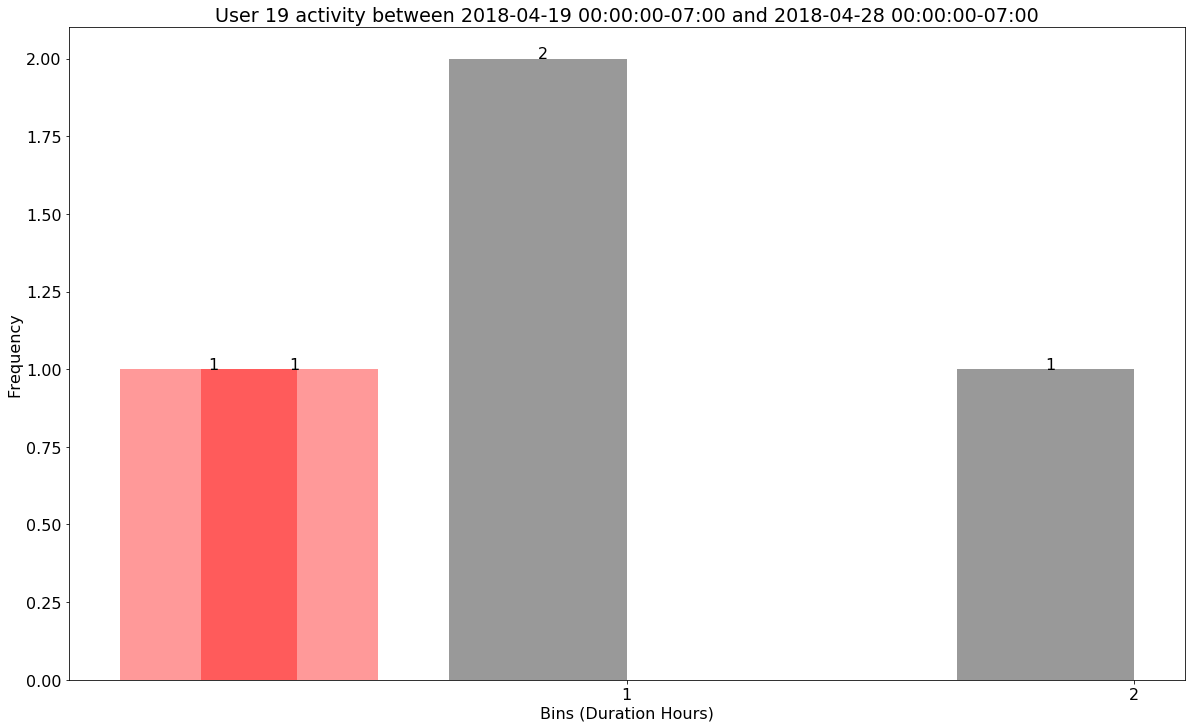

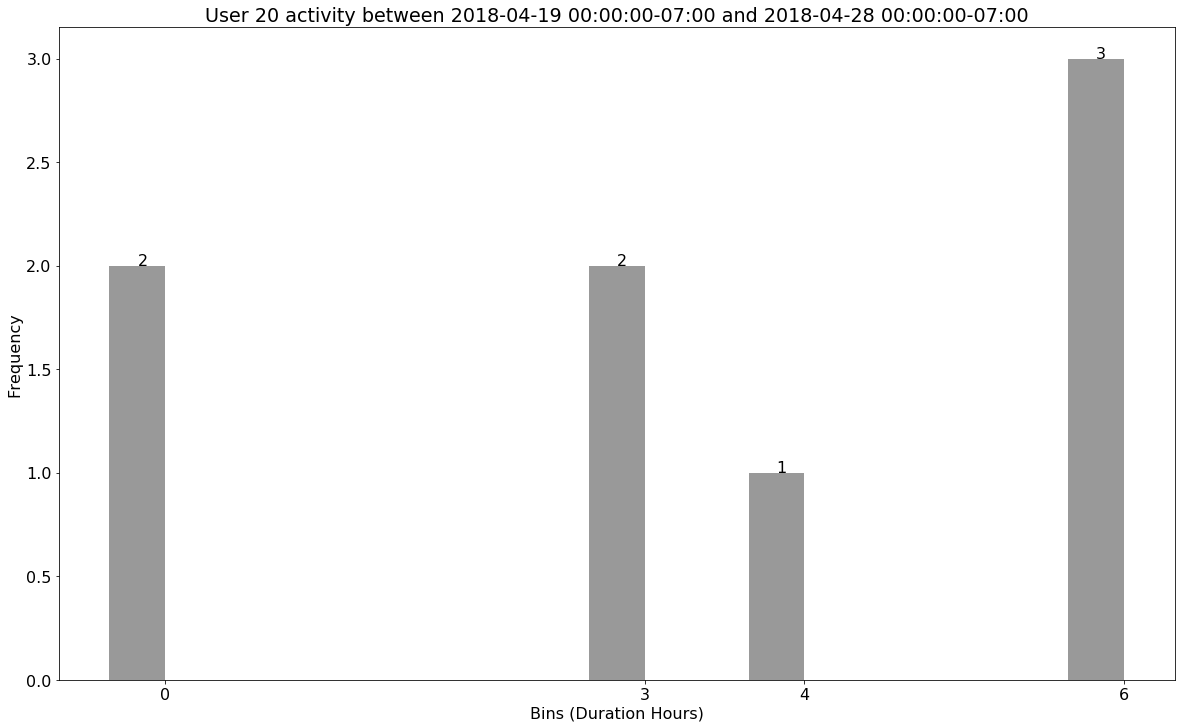

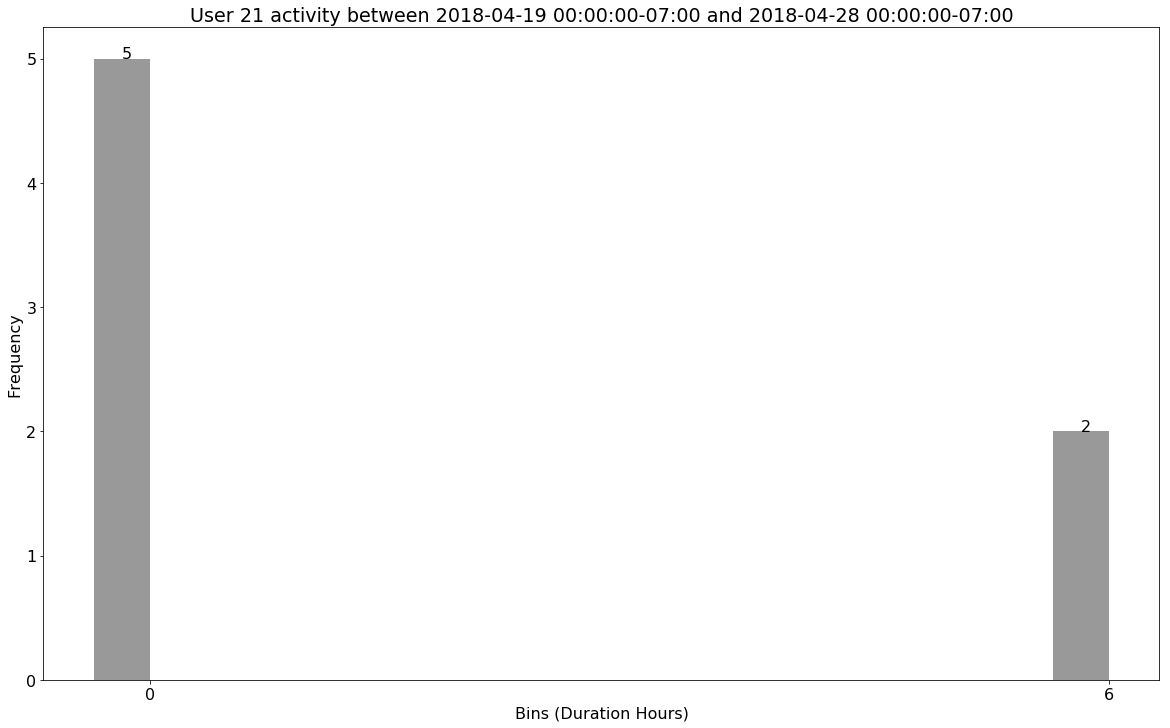

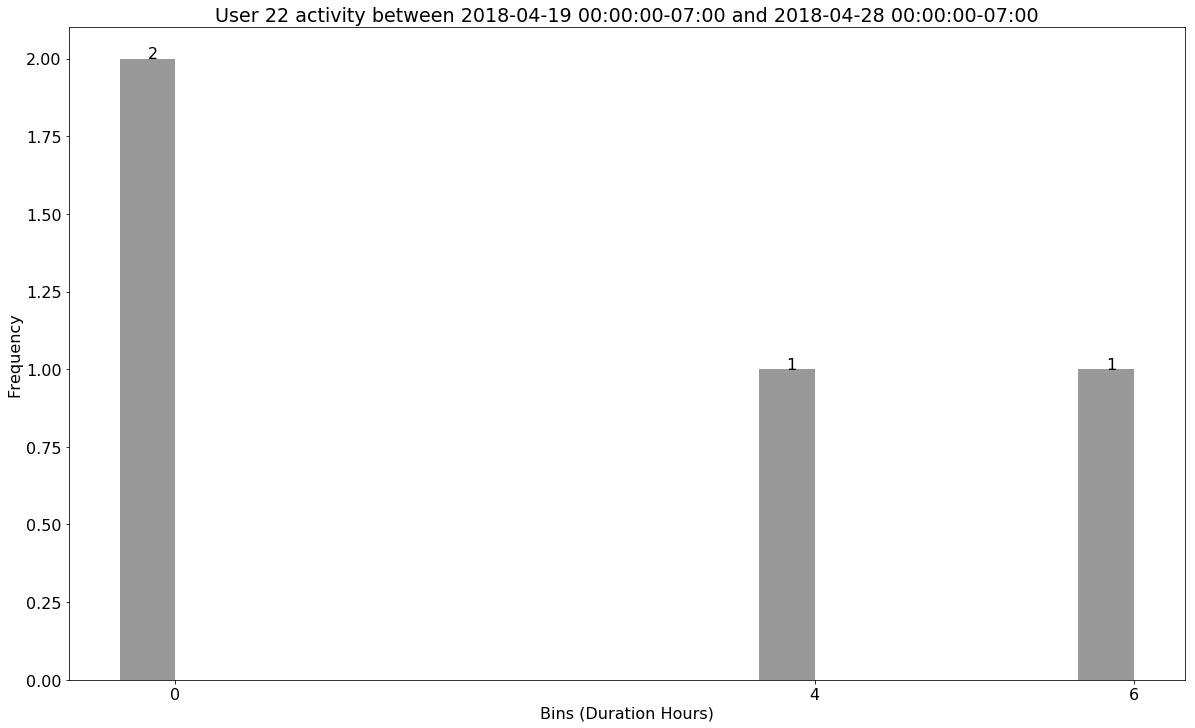

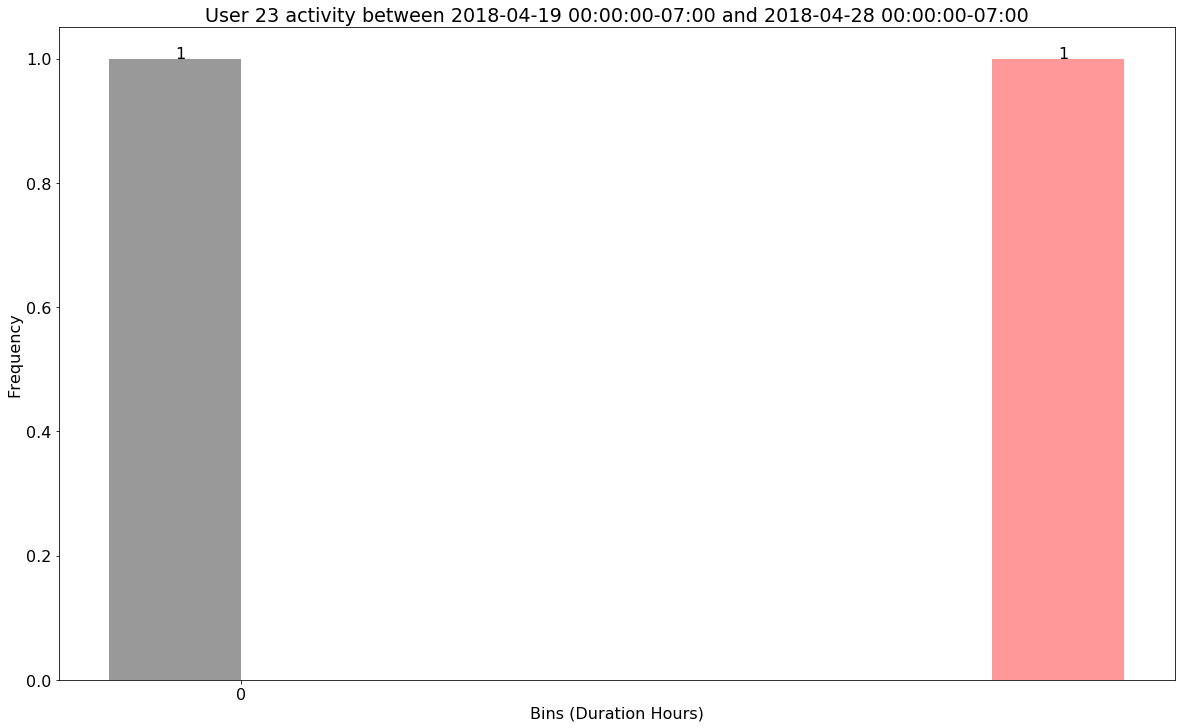

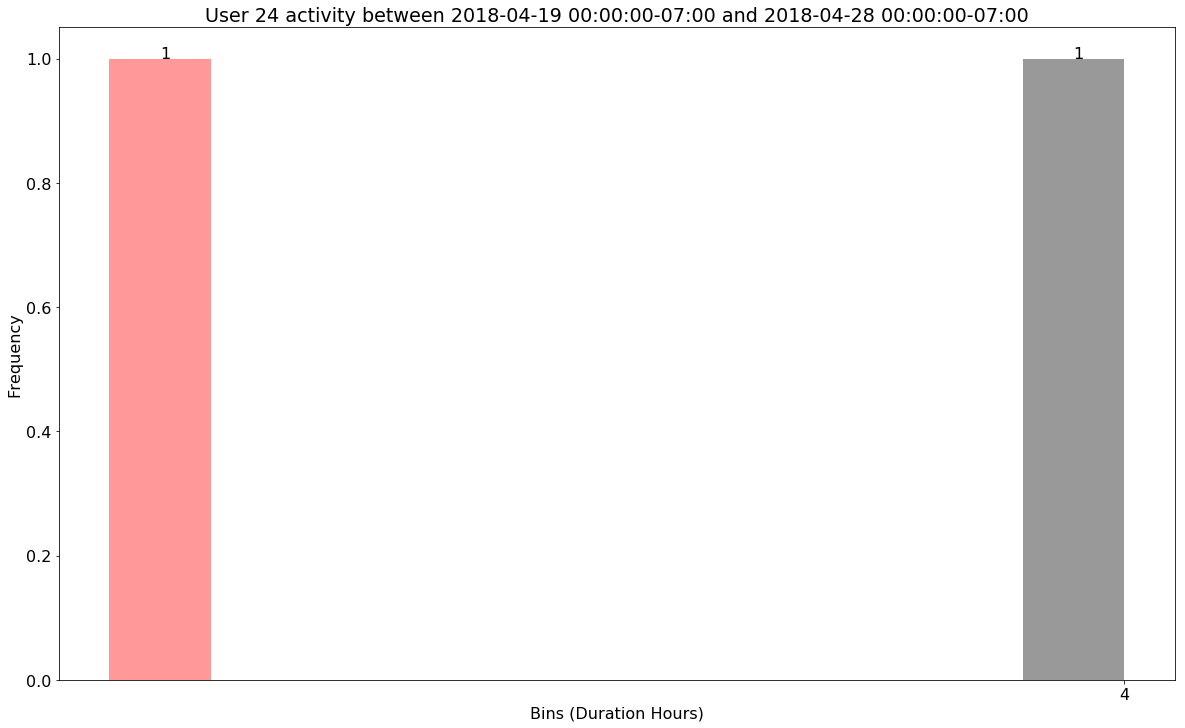

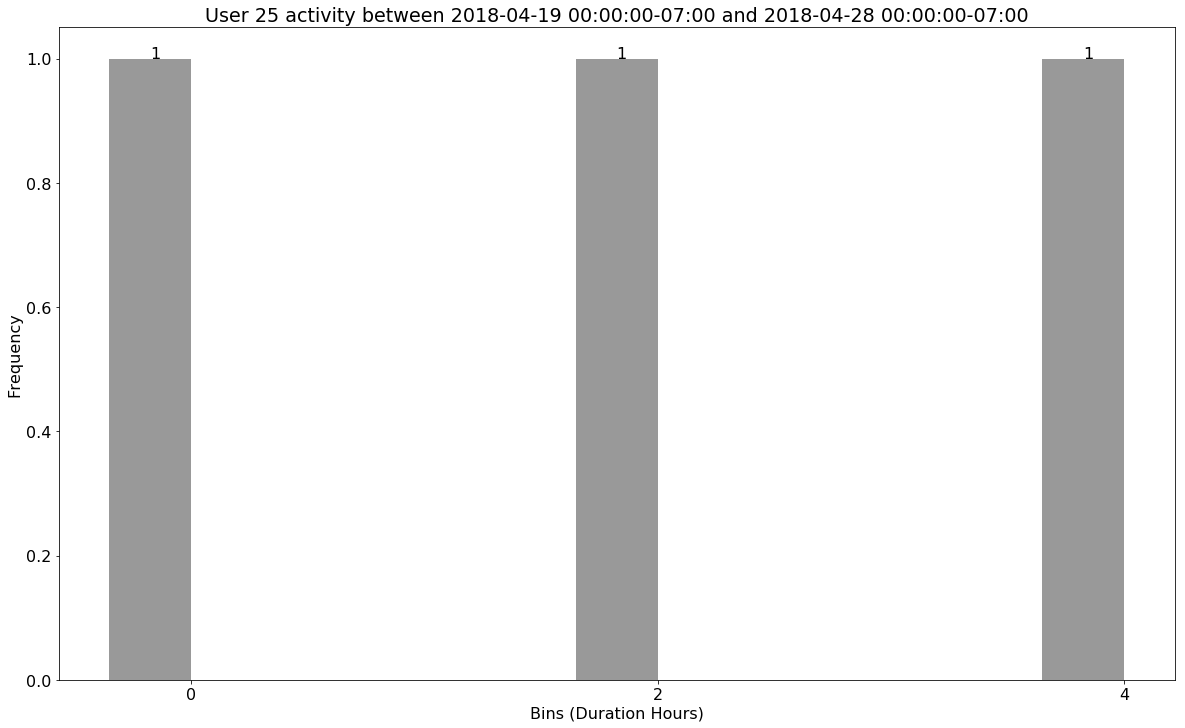

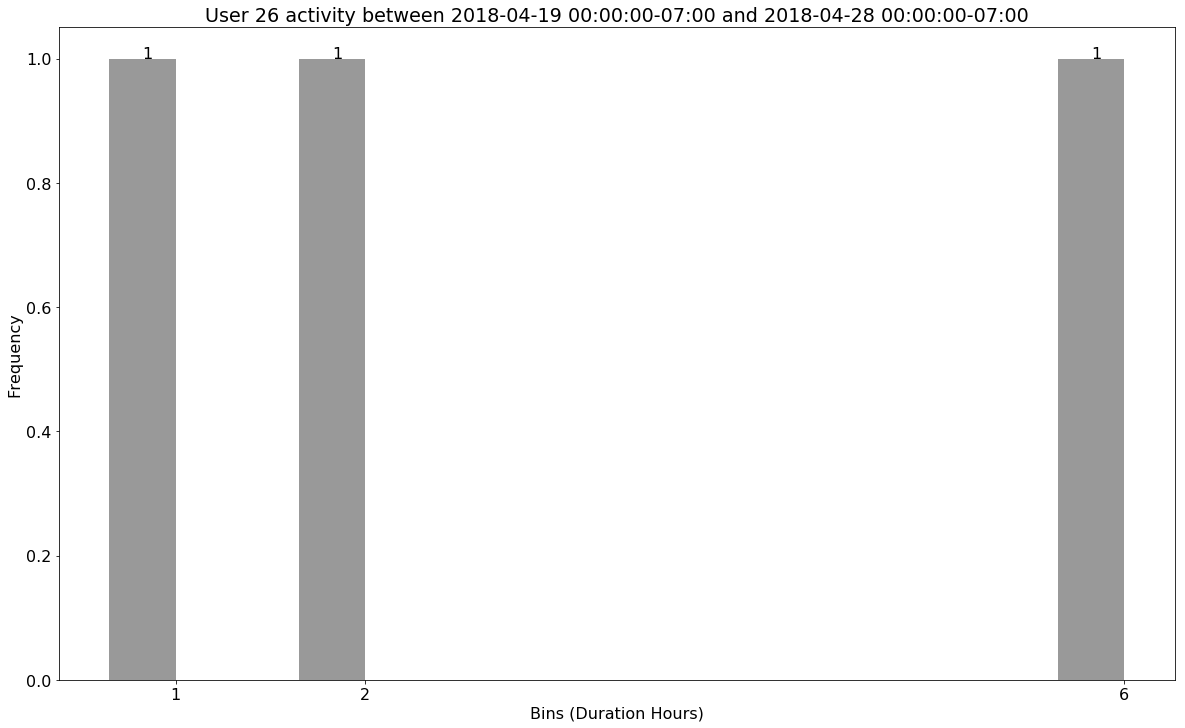

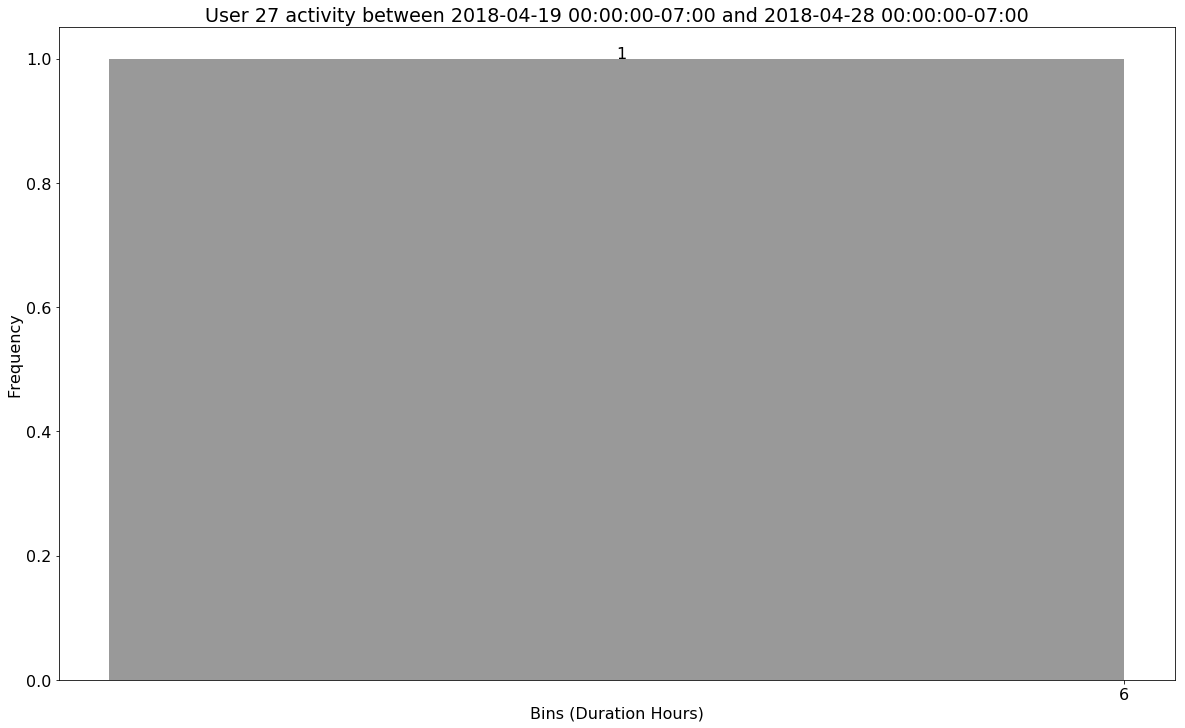

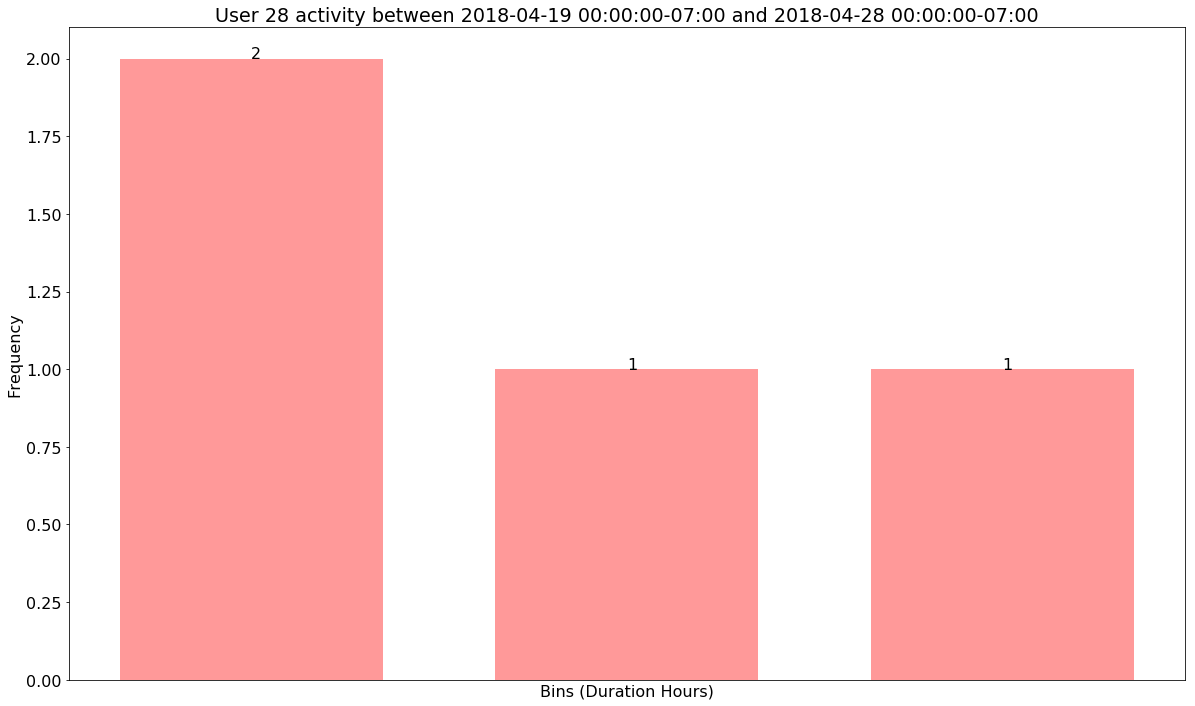

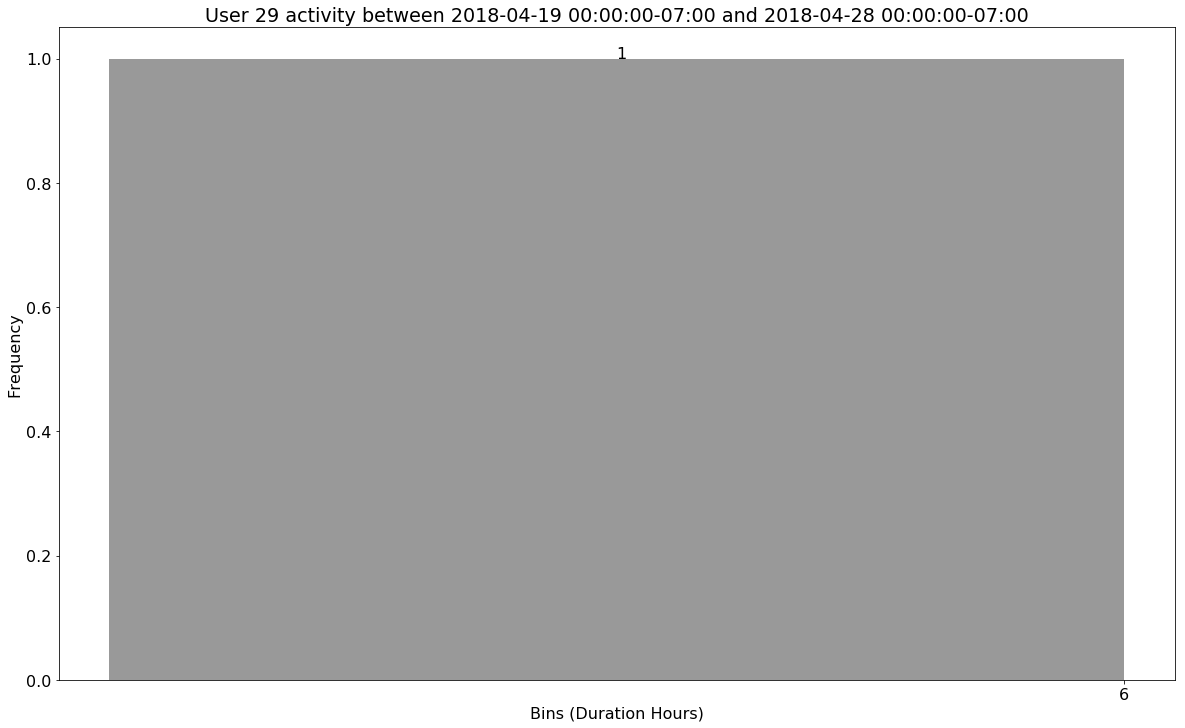

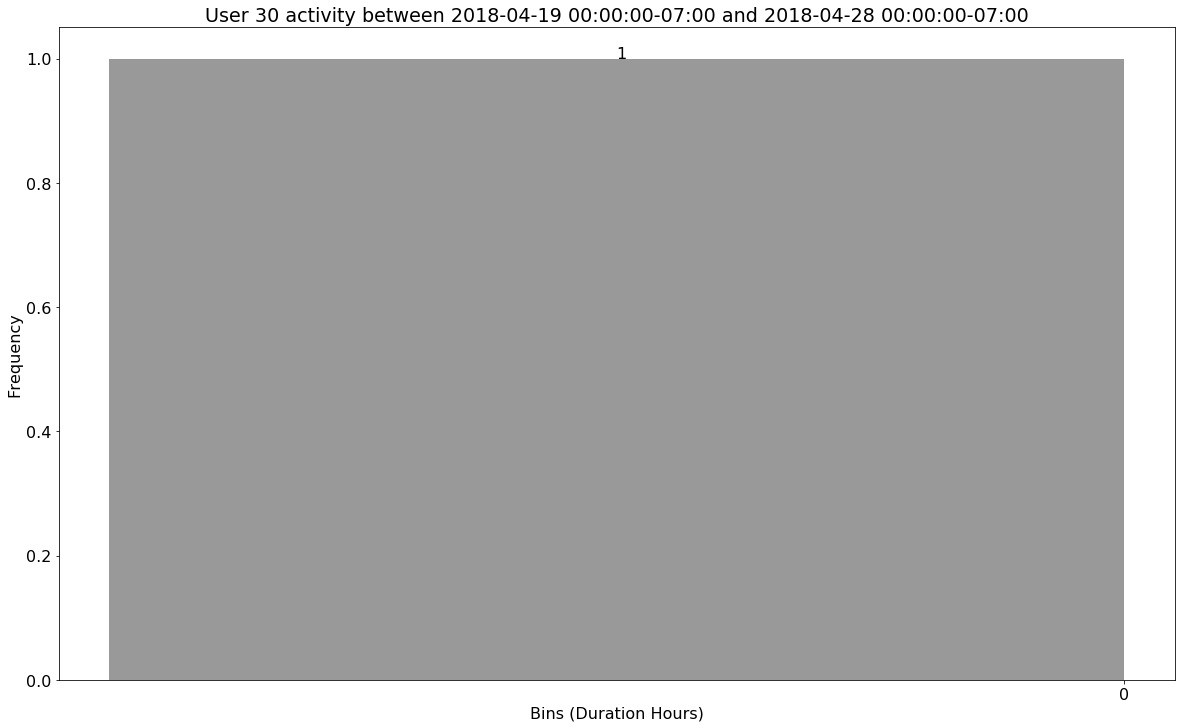

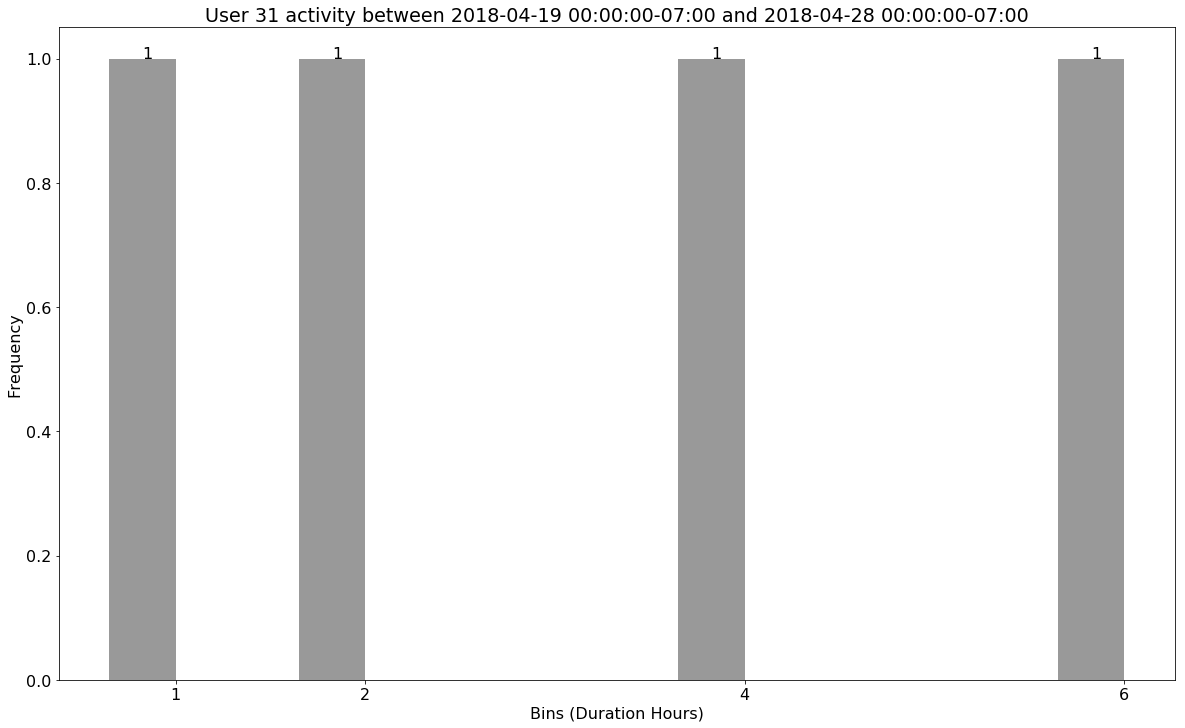

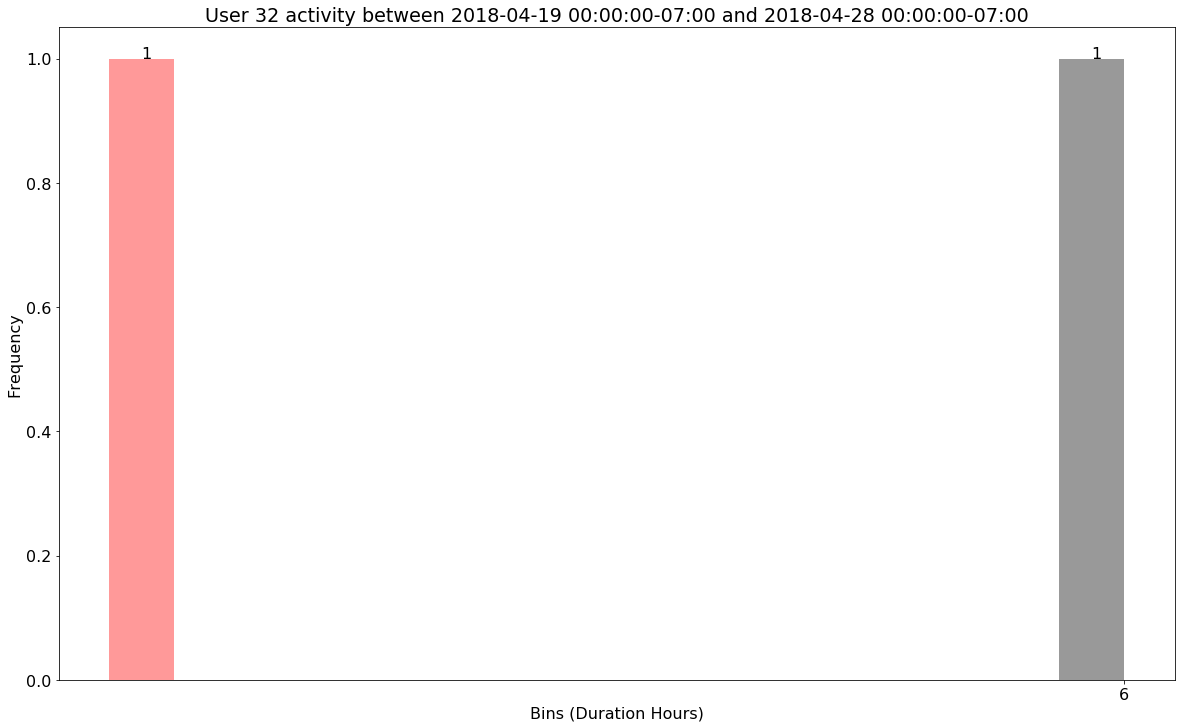

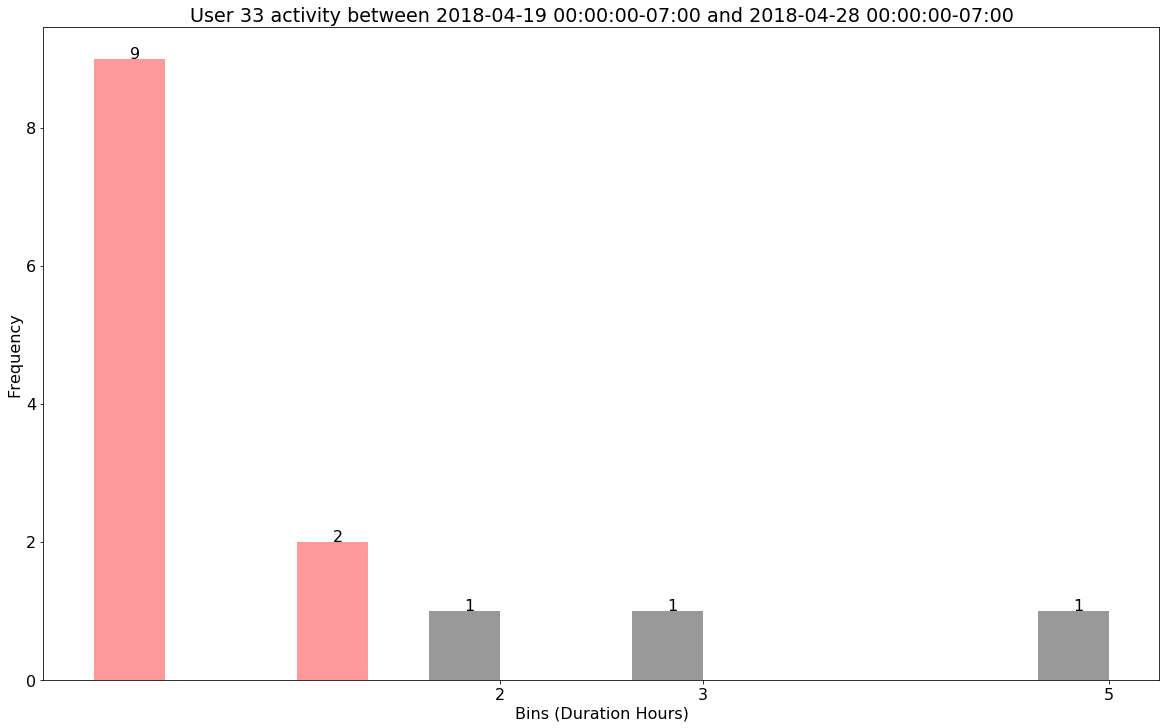

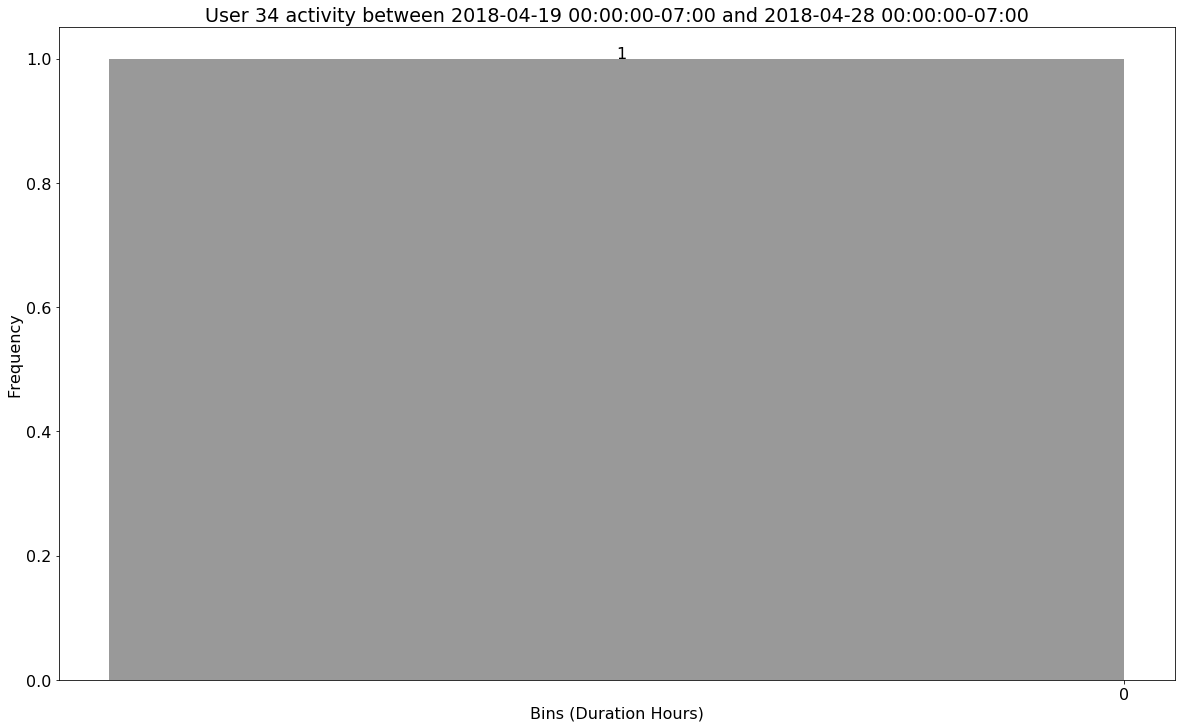

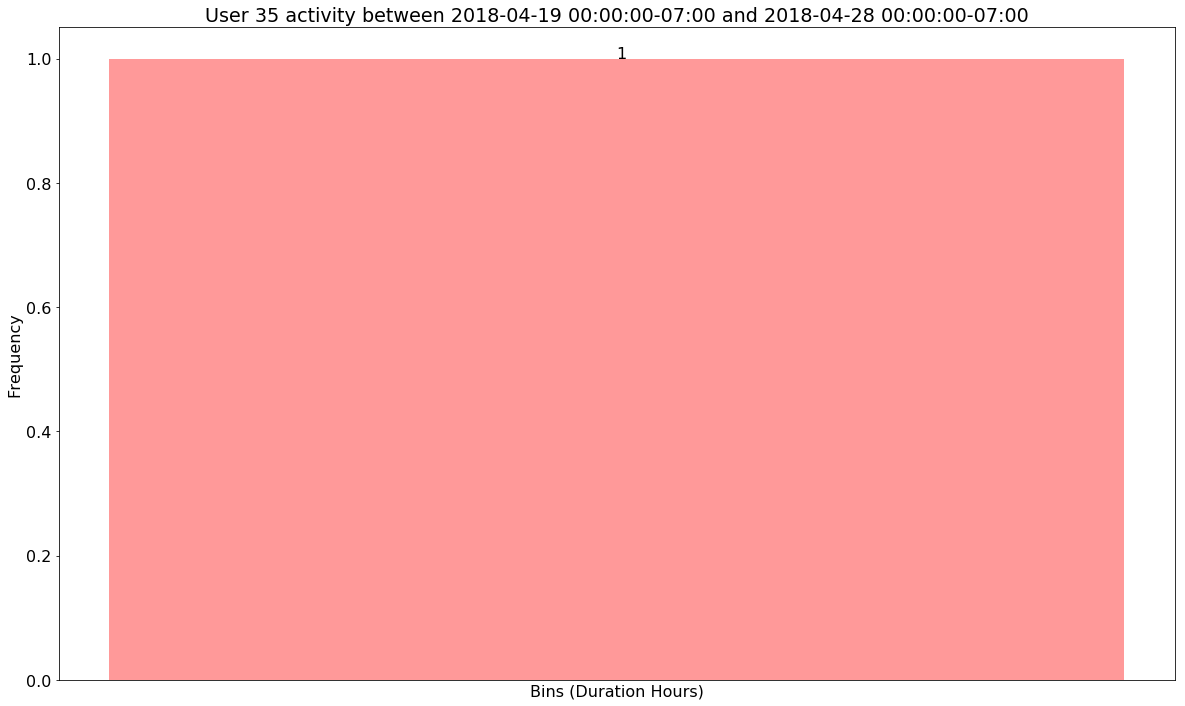

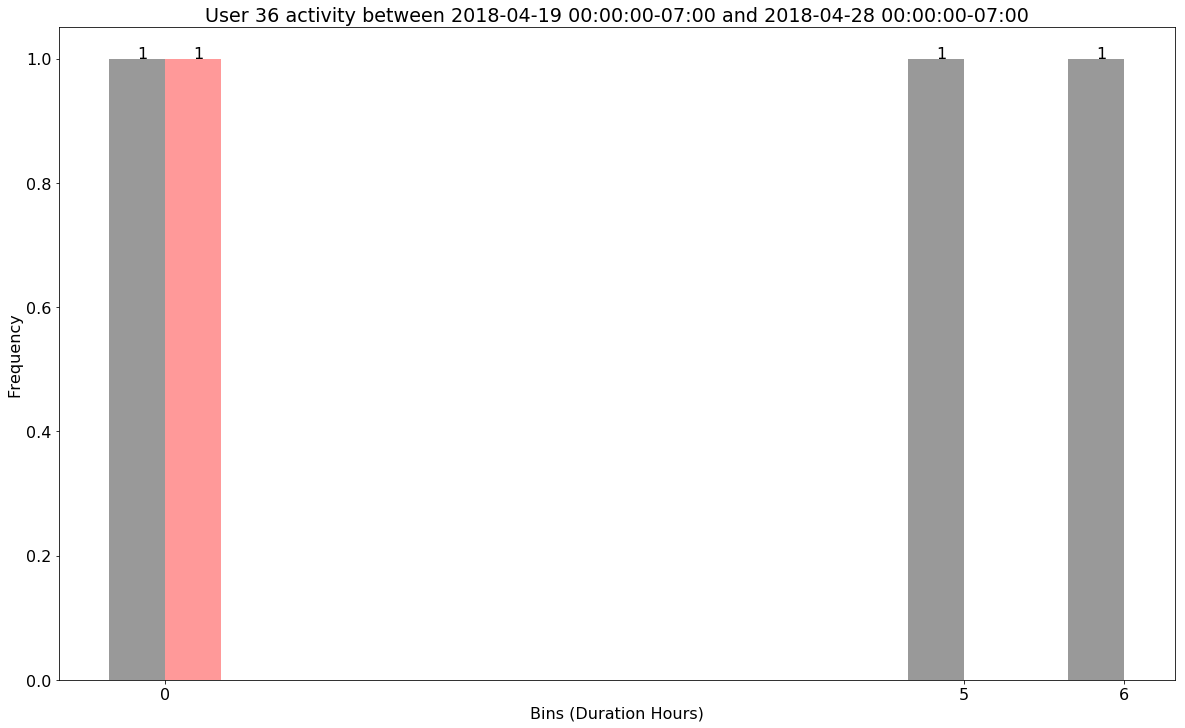

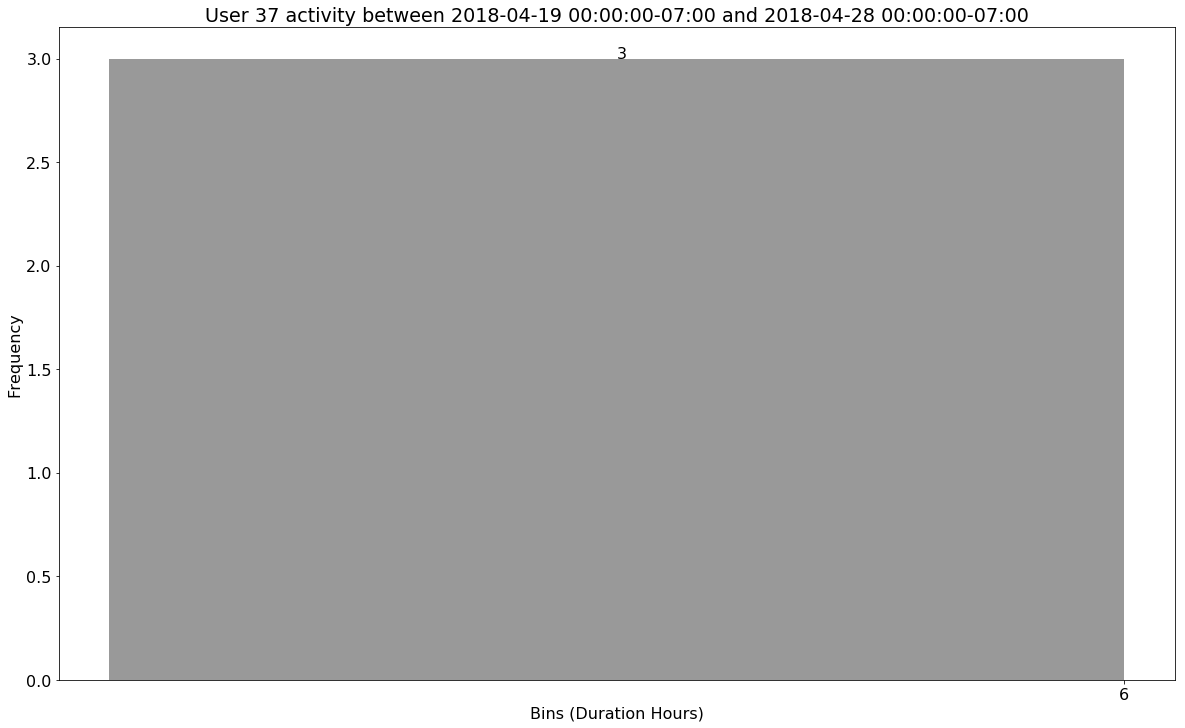

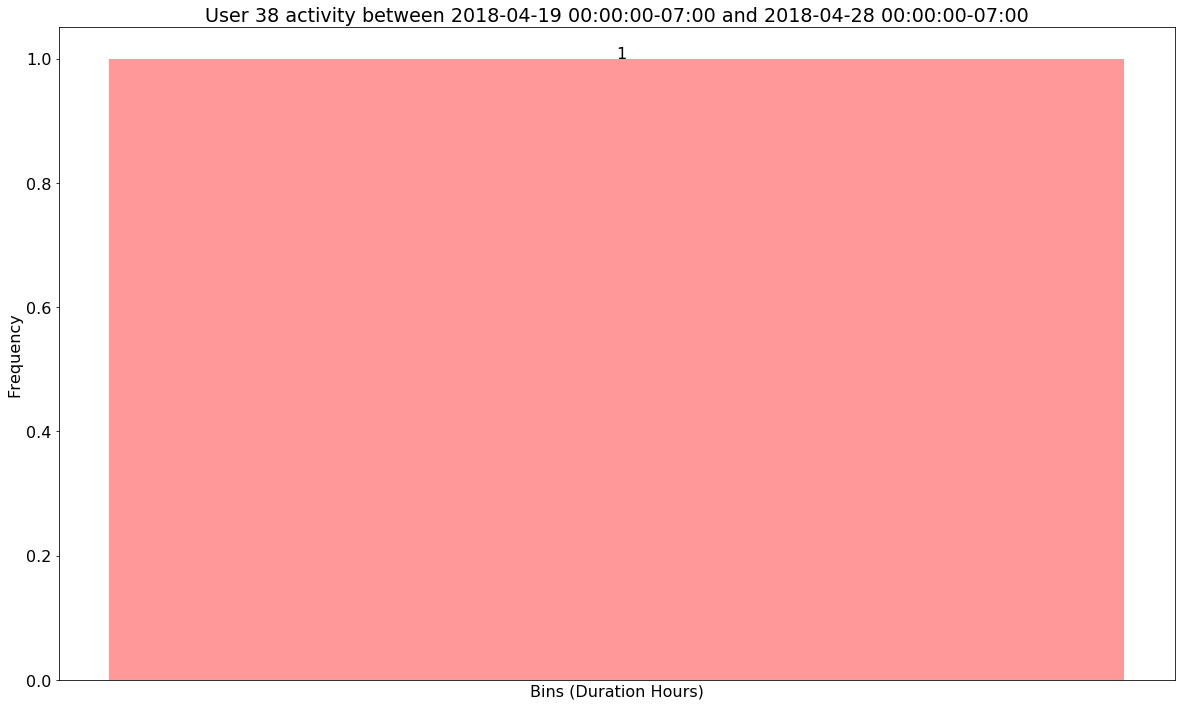

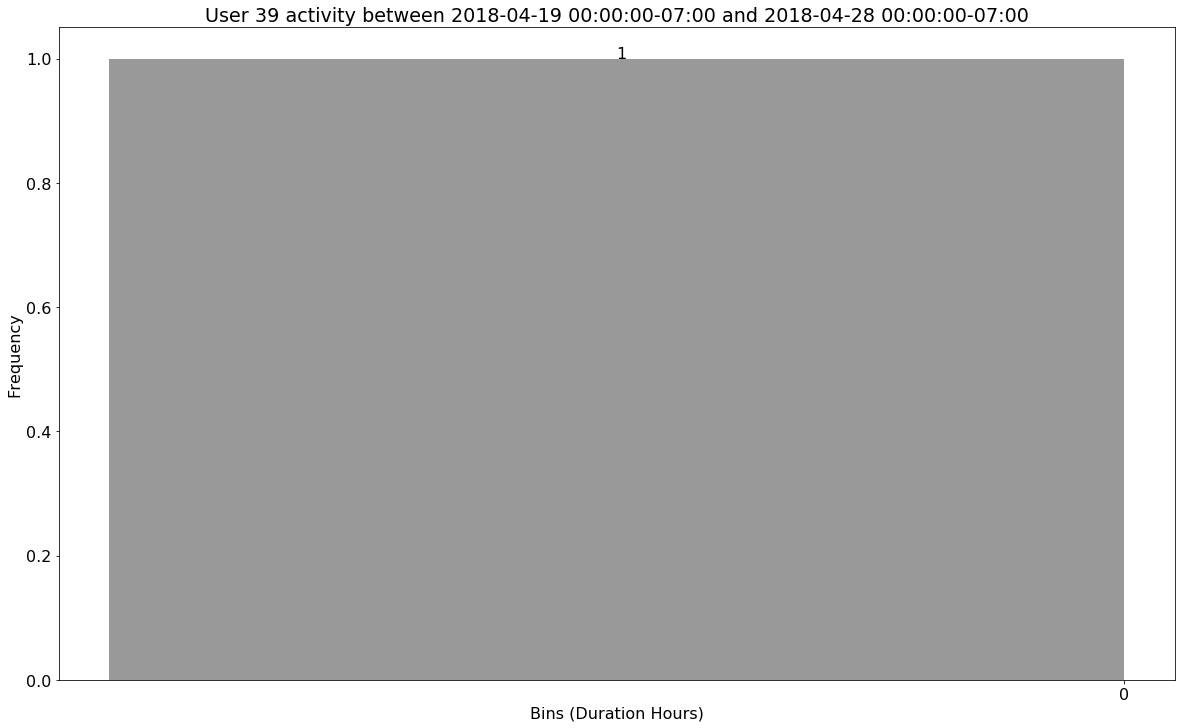

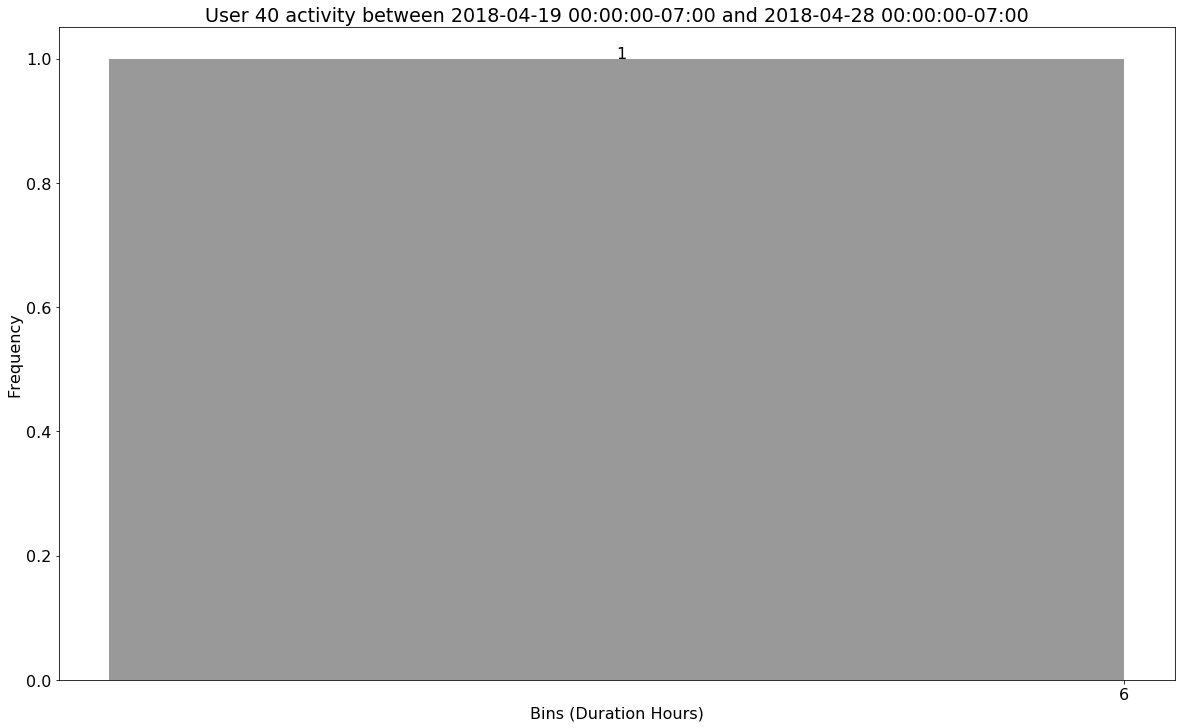

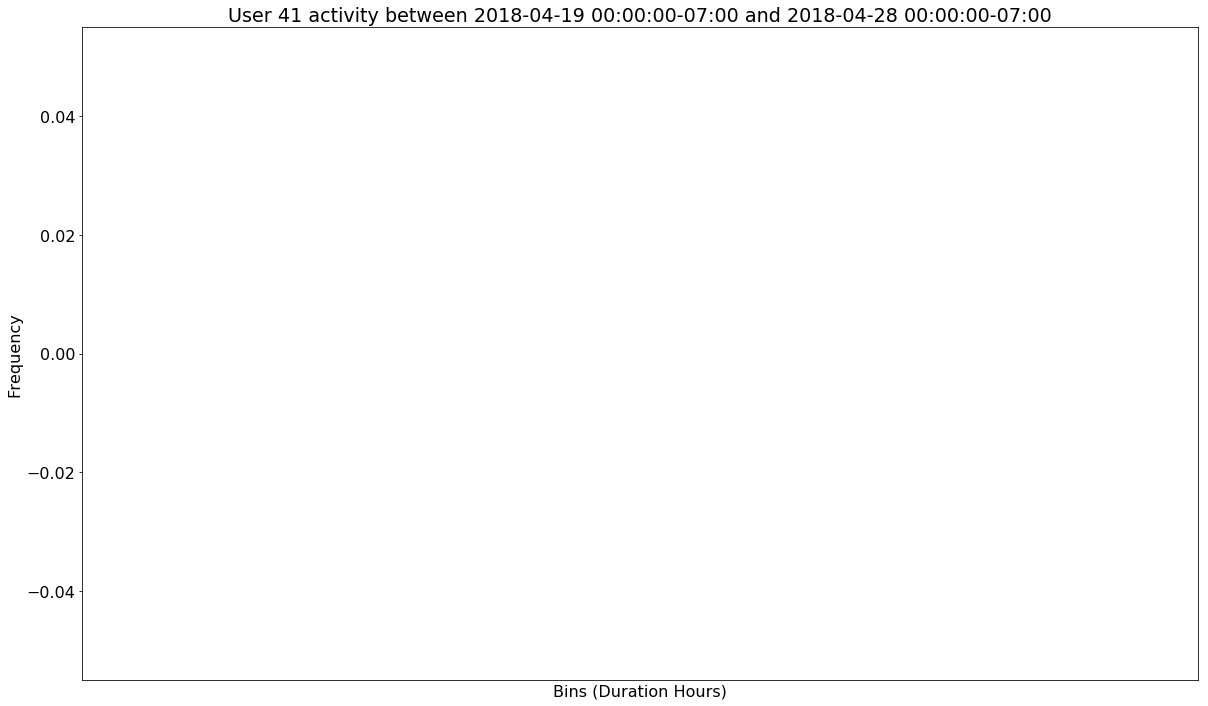

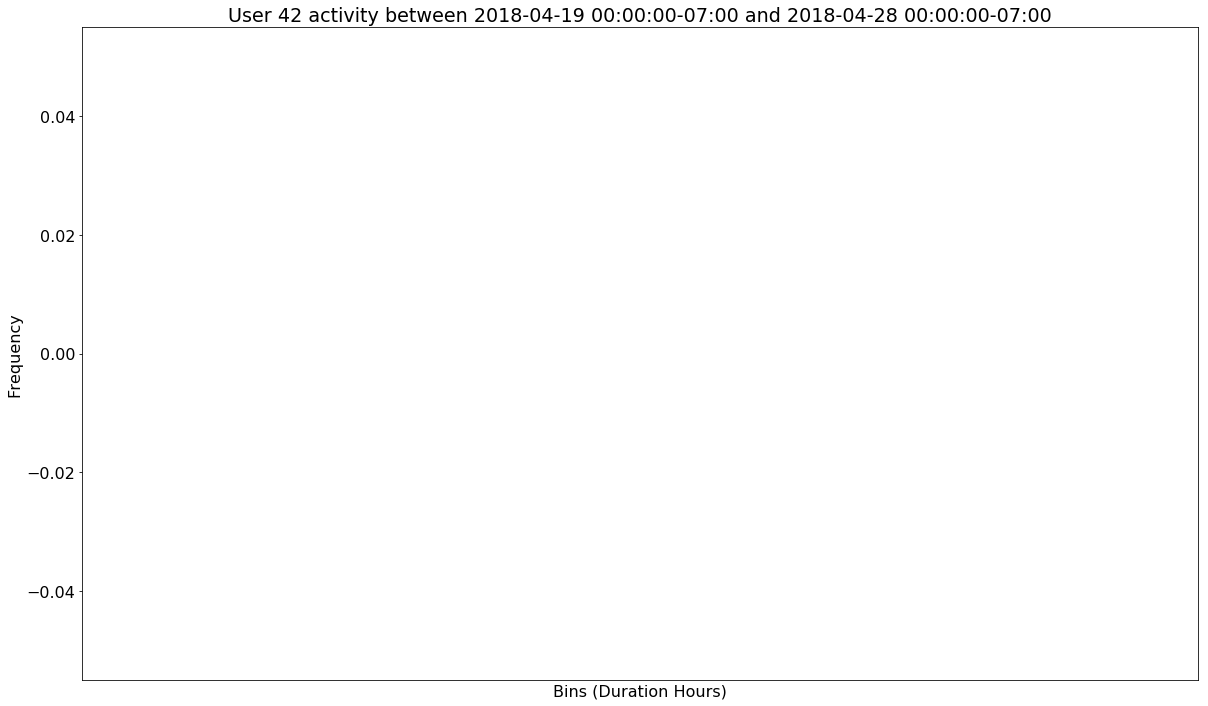

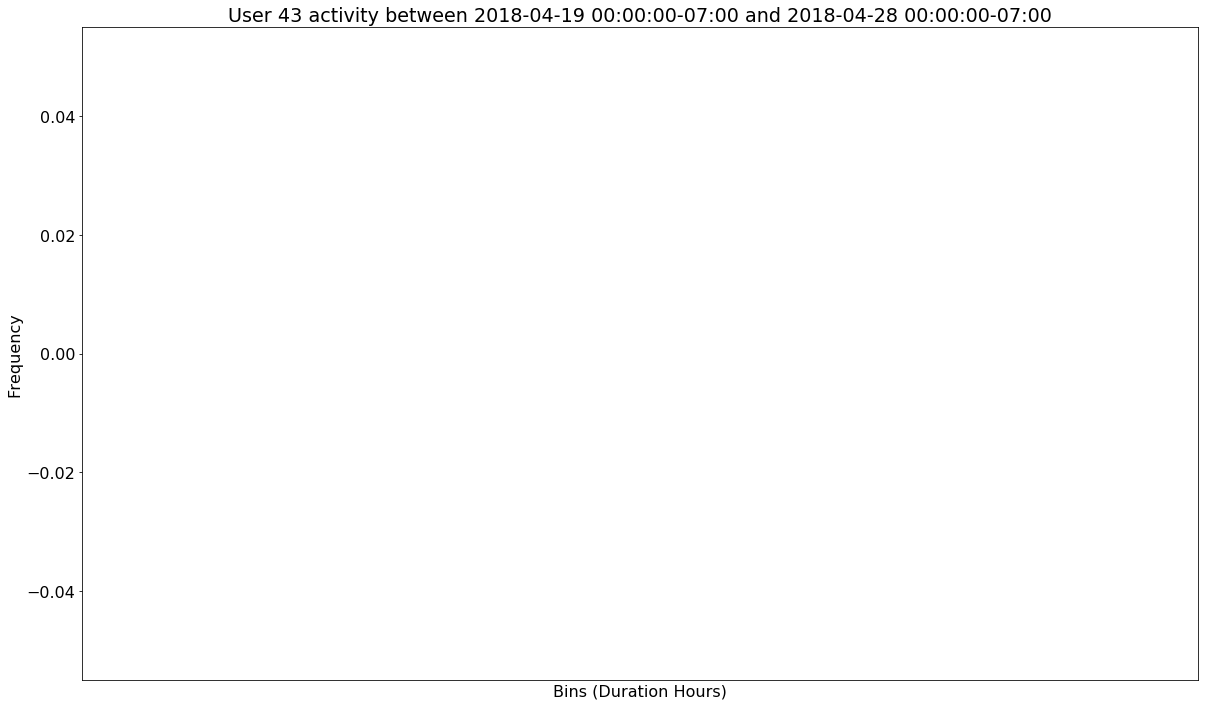

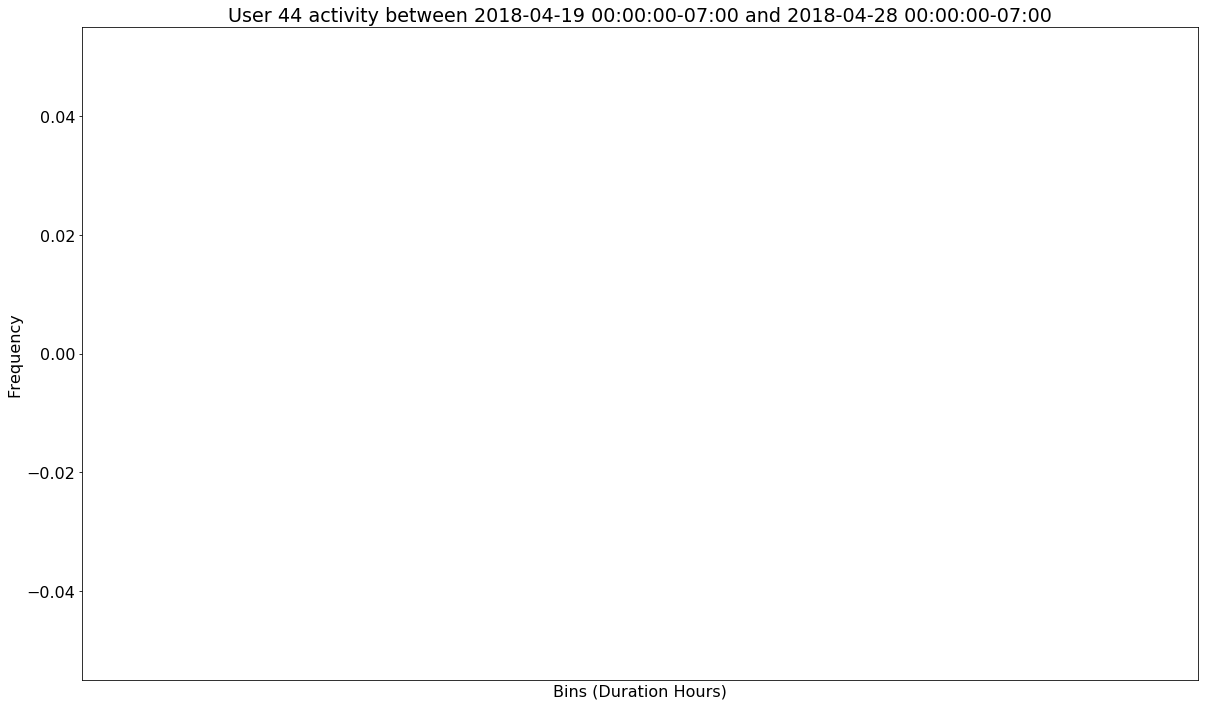

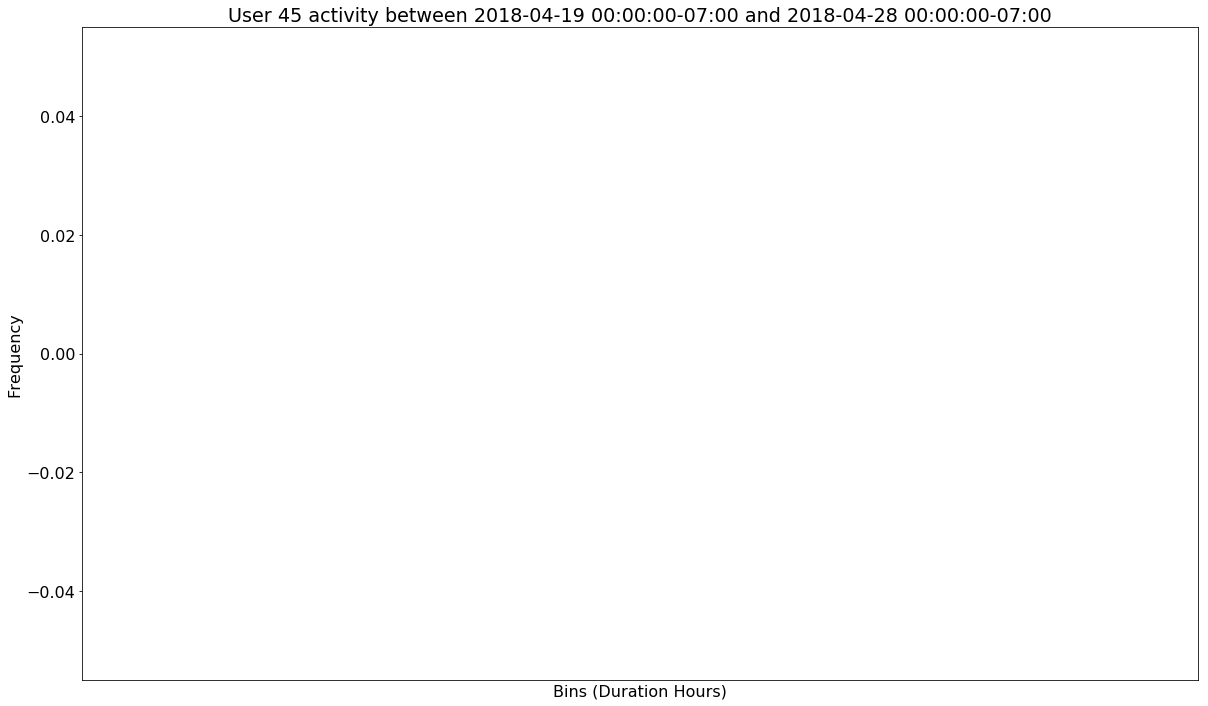

In [127]:
opacity = 0.4
bar_width = 0.35
for u_idx, user in enumerate(unique_user_list):
    #charging session duration plot
    slow_unique, slow_counts = np.unique(userUsage_dict_lowresol[user][-1], return_counts=True)
    fast_unique, fast_counts = np.unique(userUsage_dict_lowresol[user][-2], return_counts=True)

    plt.figure(10, figsize=(20,12))

    #plot both fast and slow
    plt.bar(slow_unique, slow_counts, bar_width, color='k', alpha=opacity)
    plt.bar(fast_unique+bar_width, fast_counts, bar_width, color='r', alpha=opacity)

    #set axis info
    plt.xticks(slow_unique+bar_width/2, slow_unique)
    plt.xlabel("Bins (Duration Hours)")
    plt.ylabel("Frequency")

    #add notes to bin
    for i, txt in enumerate(slow_counts):
        plt.annotate(txt, (slow_unique[i],slow_counts[i]))
    for i, txt in enumerate(fast_counts):
        plt.annotate(txt, (fast_unique[i]+bar_width,fast_counts[i]))    

    plt.title("User {} activity between {} and {}".format(str(u_idx), interestOFDate_start, interestOFDate_end))
    plt.show()
    # #plot histagram
    # plt.figure(10, figsize=(20,12))
    # normalized_slowC = slow_counts/float(sum(slow_counts))
    # plt.bar(slow_unique, normalized_slowC)
    # plt.plot(slow_unique, normalized_slowC, color = "black")
    # plt.xticks(slow_unique)
    # plt.xlabel("Bins (Duration Hours)")
    # plt.ylabel("Frequency Density over {} days".format(day_range))
    # for i, txt in enumerate(normalized_slowC):
    #     plt.annotate(np.round(txt,2), (slow_unique[i], normalized_slowC[i]))
    # plt.title("Slow AC Charging 7kW")
    # plt.show()

### User station utilization profile visualization

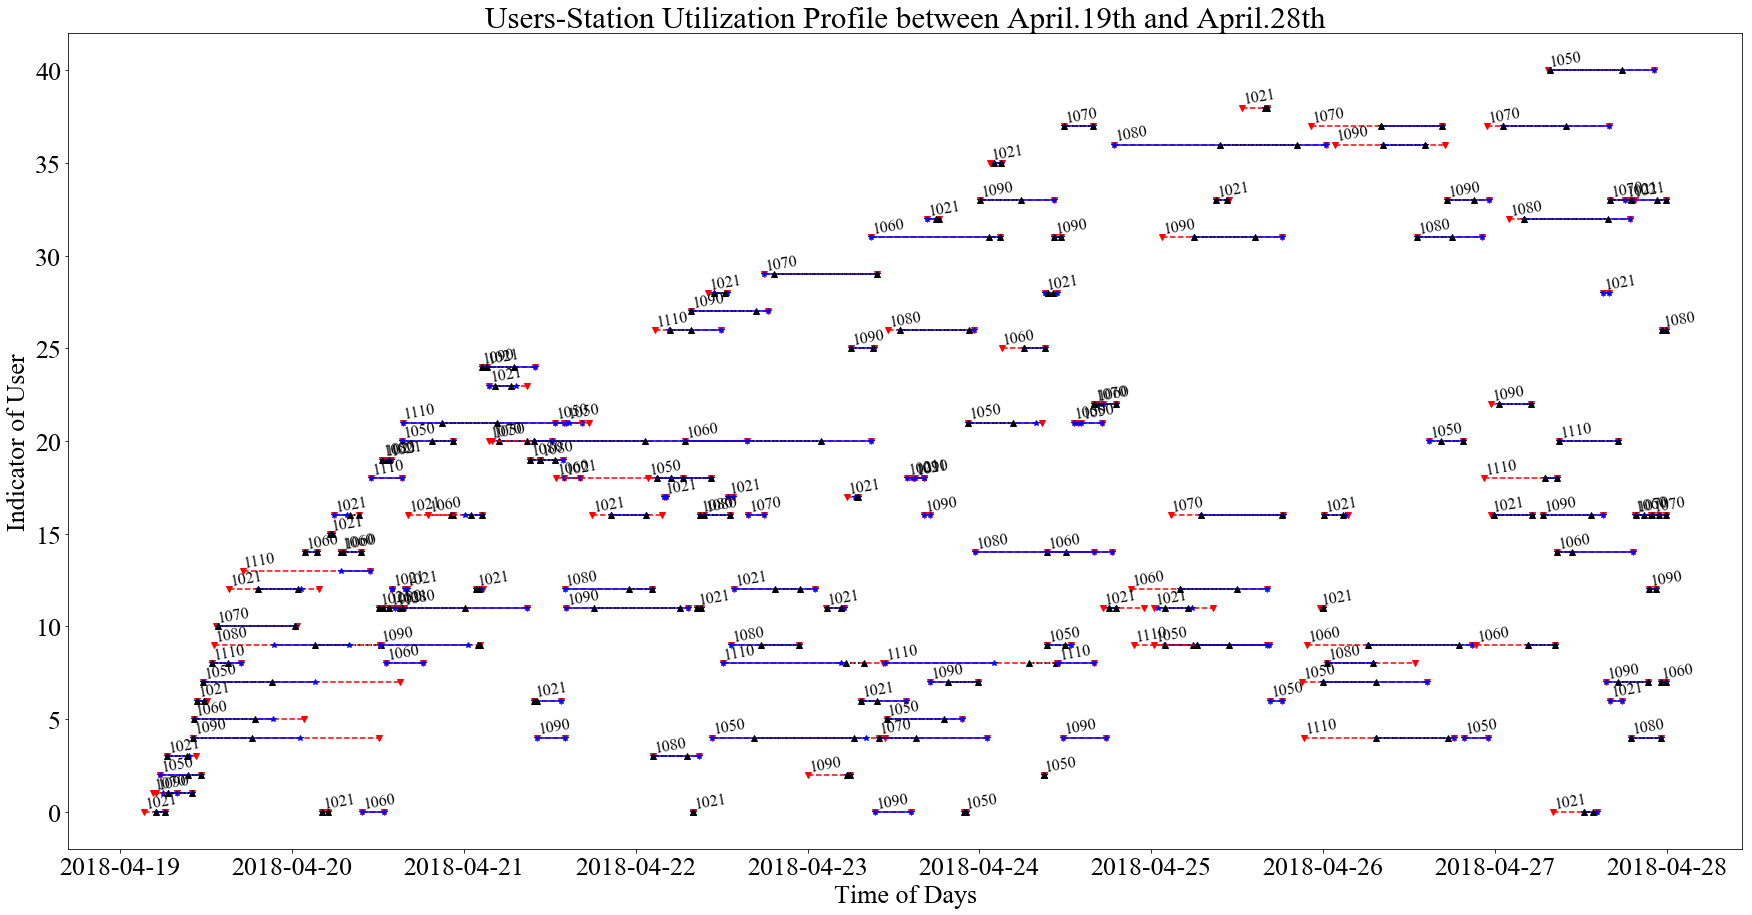

In [319]:
plt.figure(figsize=(30,15))
plt.rc("font", size = 26, family = "Times New Roman")
for user_idx, user in enumerate(unique_user_list):
    
    arrEnd_scatter_time = list()
    arrEnd_scatter_userIndedx = list()

    arrEnd_plot_time = list()
    arrEnd_plot_userIndedx = list()
    
    for idx, session in enumerate(userUsage_dict_lowresol[user]):
        zero_duration = datetime.timedelta(0)

        #session[0] is the arrival time
        #session[1] is the charging start time
        #session[2] is the charging duration
        #session[3] is the plugged in time
        #session[4] is the plugged in duration
        #session[5] is the departure time
        #session[6] is the indicator of AC/DC

        if session[4] == zero_duration:
            pass
        else:
            #arrival and departure
            plt.plot([session[0], session[5]], [user_idx]*2, "rv--")
            
            #plugged in
            if session[3]+session[4] > session[5]:
                plt.plot([session[3], session[5]], [user_idx]*2, "b*-")
            else:
                plt.plot([session[3], session[3]+session[4]], [user_idx]*2, "b*-")
#             plt.plot([session[0], session[4]], [user_idx]*2, c="b")

            #charging duration
            if session[2] != zero_duration:
                
                if session[1]+session[2] > session[5]:
                    plt.plot([session[1], session[5]], [user_idx]*2, "k^:")
                else:
                    plt.plot([session[1], session[1]+session[2]], [user_idx]*2, "k^:")
            
            plt.annotate(session[-1], (session[0], user_idx), ha="left", va="bottom", rotation=10, size=16)
            
plt.xlabel("Time of Days")
plt.ylabel("Indicator of User")
plt.title("Users-Station Utilization Profile between {2}.{0}th and {2}.{1}th".format(interestOFDate_start.day, 
                                                                           interestOFDate_end.day, 
                                                                           months[interestOFDate_start.month-1]))
# plt.savefig("Users-Station Utilization Profile.png")
plt.show()

### Arrival departure distribution visualization

In [283]:
#create pre-work, late morning, noon-early afternoon, afternoon, post-work, evening, midnight time point
pre_work_hour = 8
late_morn_hour = 10
noon_hour = 12
afternoon_hour = 17
post_work_hour = 20
midnight_hour = 24

time_boundary_list = [pre_work_hour, late_morn_hour, noon_hour, afternoon_hour, post_work_hour, midnight_hour]

#create charging duration 
sixHour = datetime.timedelta(0, 3600*6, 0)
fiveHour = datetime.timedelta(0, 3600*5, 0)
fourHour = datetime.timedelta(0, 3600*4, 0)
threeHour = datetime.timedelta(0, 3600*3, 0)
twoHour = datetime.timedelta(0, 3600*2, 0)
oneHour = datetime.timedelta(0, 3600, 0)
halfHour = datetime.timedelta(0, 1800, 0)
tenmin = datetime.timedelta(0, 600, 0)

charge_boundary_list = [tenmin, halfHour, oneHour, twoHour, threeHour, fourHour, fiveHour, sixHour]
charge_hour_list = [0, 0.5, 1, 2, 3, 4, 5, 6]

In [323]:
datetime.timedelta(0, 1800).seconds

1800

In [324]:
#a list to store all the arrival and departure time, charging duration
arrival_list = list()
departure_list = list()
charge_list = list()
connected_list = list()
energy_list = list()

for user_idx, user in enumerate(unique_user_list):

        #session[0] is the arrival time
        #session[1] is the charging start time
        #session[2] is the charging duration
        #session[3] is the plugged in time
        #session[4] is the plugged in duration
        #session[5] is the departure time
        #session[6] is the indicator of AC/DC
        
    for idx, session in enumerate(userUsage_dict_lowresol[user]):
        
        found_arr = False
        found_dep = False
        found_char = False
        found_conn = False
        
        if session[6][-1] == "1":
            #DC
            energy_list.append(session[2].seconds / 3600.0 * 40)
        else:
            #AC
            energy_list.append(session[2].seconds / 3600.0 * 7)
            
        for boundary in time_boundary_list:
            if session[0].hour < boundary and not found_arr:
                arrival_list.append(boundary)
                found_arr = True
            if session[5] is not None:
                if session[5].hour < boundary and not found_dep:
                    departure_list.append(boundary)
                    found_dep = True
        for idx, boundary in enumerate(charge_boundary_list):
#             if session[2] != zero_duration:
            if session[2] < boundary and not found_char:
                charge_list.append(charge_hour_list[idx])
                found_char = True
                
        for idx, boundary in enumerate(charge_boundary_list):
#             if session[2] != zero_duration:
            if session[4] < boundary and not found_conn:
                connected_list.append(charge_hour_list[idx])
                found_conn = True

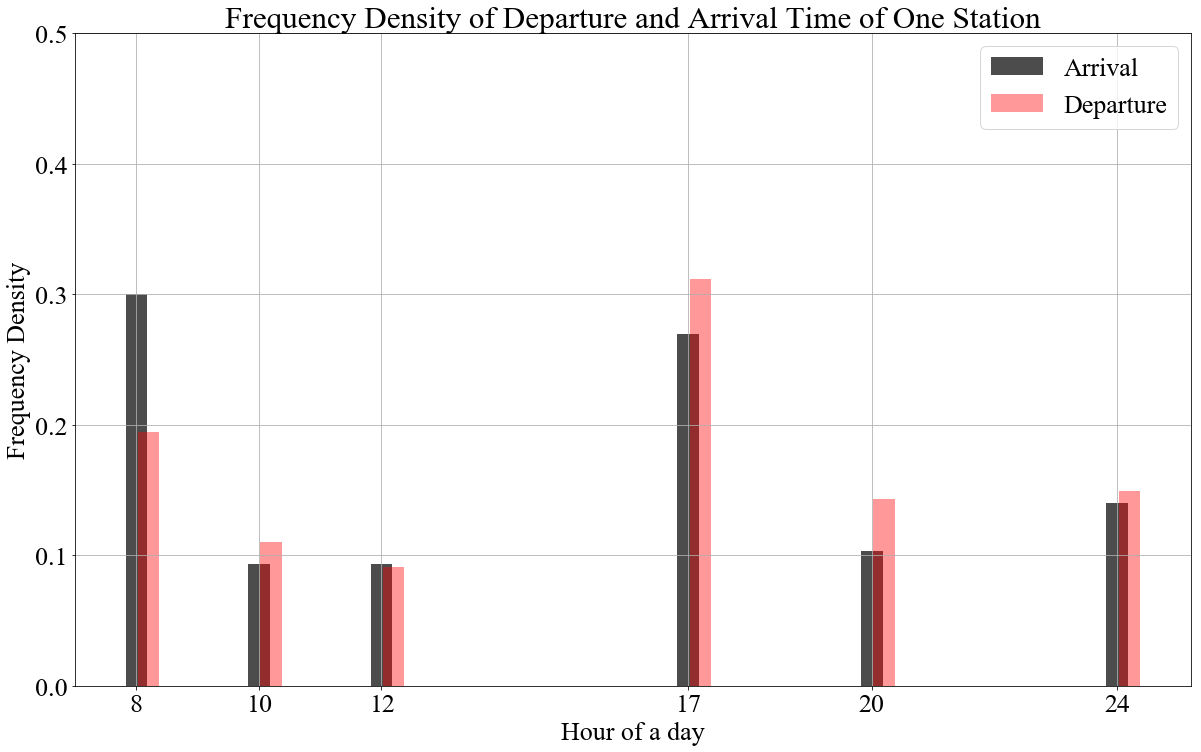

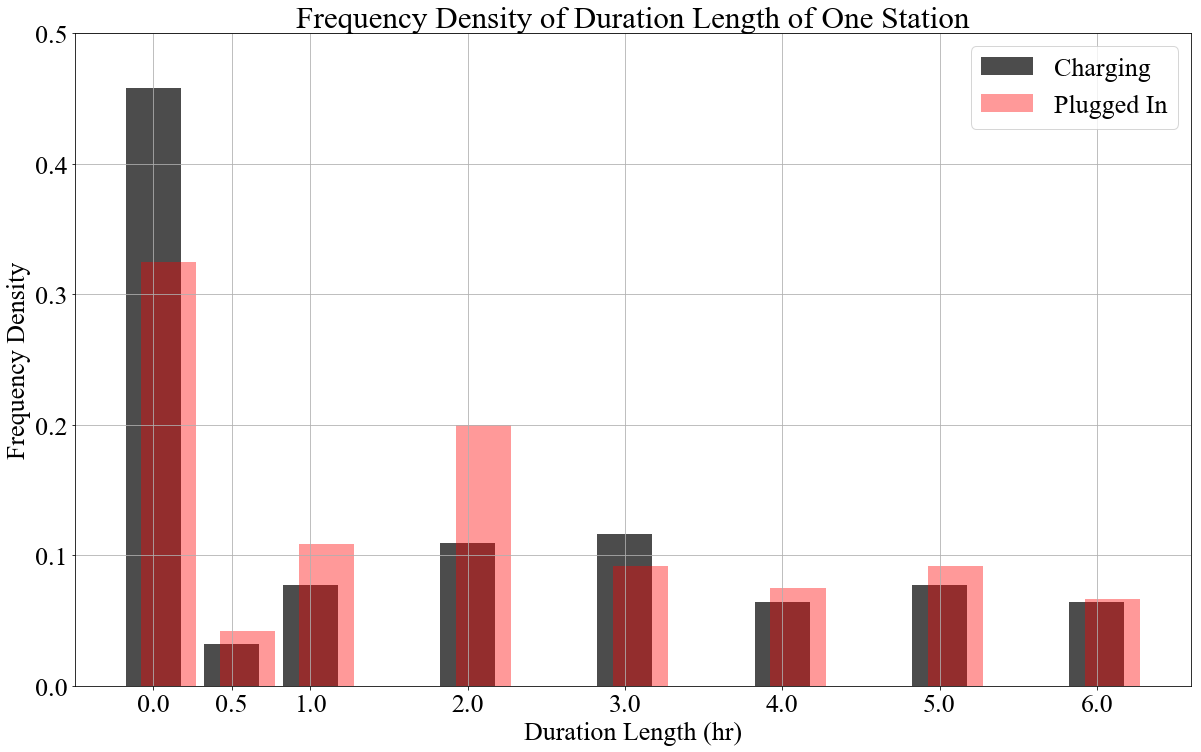

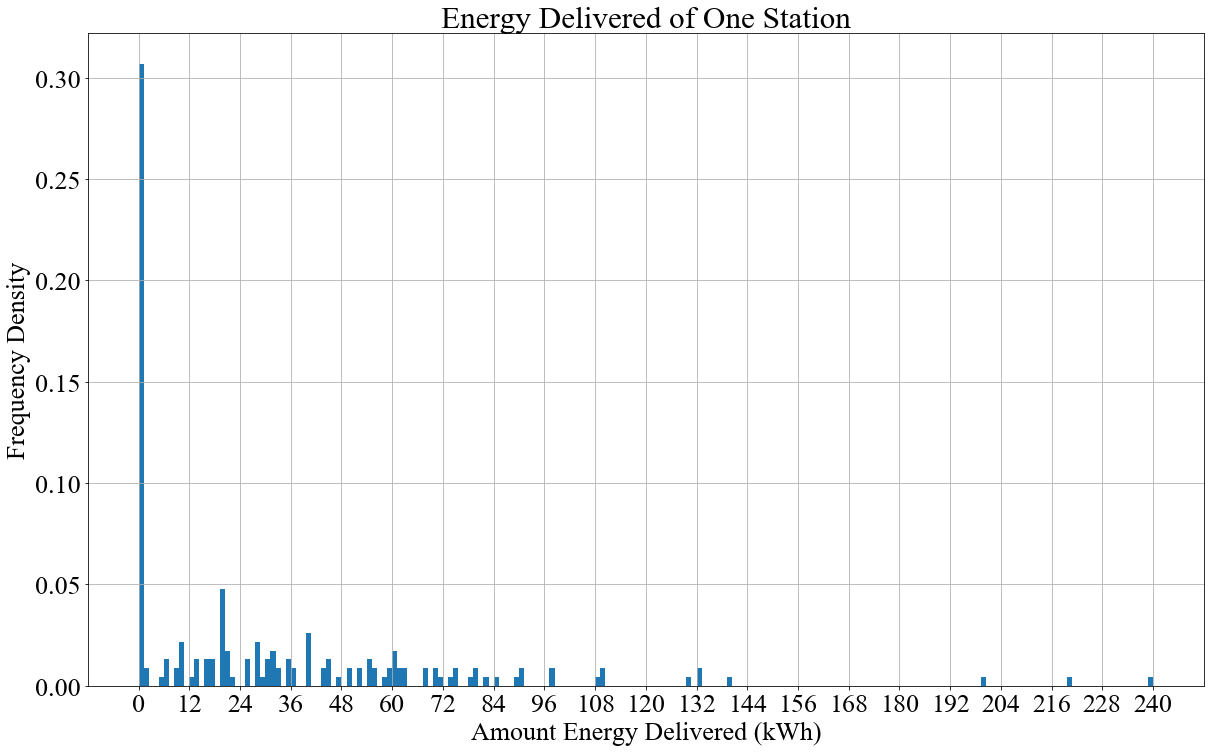

In [349]:
arrival_unique, arrival_counts = np.unique(arrival_list, return_counts=True)
depart_unique, depart_counts = np.unique(departure_list, return_counts=True)
char_unique, char_counts = np.unique(charge_list, return_counts=True)
conn_unique, conn_counts = np.unique(connected_list, return_counts=True)

#plot arrival and departure time frequency density
plt.figure(figsize=(20,12))

plt.bar(arrival_unique, arrival_counts/float(sum(arrival_counts)), bar_width, color='k', alpha=opacity+0.3, label="Arrival")
plt.bar(depart_unique+0.2, depart_counts/float(sum(depart_counts)), bar_width, color='r', alpha=opacity, label="Departure")
plt.xlabel("Hour of a day")
plt.ylabel("Frequency Density")
plt.title("Frequency Density of Departure and Arrival Time of One Station")
plt.xticks(time_boundary_list)
plt.yticks(np.linspace(0, 0.5, 6))
plt.legend()
plt.grid()
plt.show()

#plot charging and total plugged in duration frequency density
plt.figure(figsize=(20,12))

plt.bar(char_unique, char_counts/float(sum(char_counts)), bar_width, color='k', alpha=opacity+0.3, label="Charging")
plt.bar(conn_unique+0.1, conn_counts/float(sum(conn_counts)), bar_width, color='r', alpha=opacity, label="Plugged In")
plt.xlabel("Duration Length (hr)")
plt.ylabel("Frequency Density")
plt.title("Frequency Density of Duration Length of One Station")
plt.xticks(charge_hour_list)
plt.yticks(np.linspace(0, 0.5, 6))
plt.legend()
plt.grid()
plt.show()

#plot energy amount delivered
plt.figure(figsize=(20,12))

bins = plt.hist(energy_list, bins=200, normed=True)
plt.xlabel("Amount Energy Delivered (kWh)")
plt.ylabel("Frequency Density")
plt.title("Energy Delivered of One Station")
plt.xticks(bins[1][::10])
plt.grid()
plt.show()

In [339]:
bins[1]

array([   0. ,    1.2,    2.4,    3.6,    4.8,    6. ,    7.2,    8.4,
          9.6,   10.8,   12. ,   13.2,   14.4,   15.6,   16.8,   18. ,
         19.2,   20.4,   21.6,   22.8,   24. ,   25.2,   26.4,   27.6,
         28.8,   30. ,   31.2,   32.4,   33.6,   34.8,   36. ,   37.2,
         38.4,   39.6,   40.8,   42. ,   43.2,   44.4,   45.6,   46.8,
         48. ,   49.2,   50.4,   51.6,   52.8,   54. ,   55.2,   56.4,
         57.6,   58.8,   60. ,   61.2,   62.4,   63.6,   64.8,   66. ,
         67.2,   68.4,   69.6,   70.8,   72. ,   73.2,   74.4,   75.6,
         76.8,   78. ,   79.2,   80.4,   81.6,   82.8,   84. ,   85.2,
         86.4,   87.6,   88.8,   90. ,   91.2,   92.4,   93.6,   94.8,
         96. ,   97.2,   98.4,   99.6,  100.8,  102. ,  103.2,  104.4,
        105.6,  106.8,  108. ,  109.2,  110.4,  111.6,  112.8,  114. ,
        115.2,  116.4,  117.6,  118.8,  120. ,  121.2,  122.4,  123.6,
        124.8,  126. ,  127.2,  128.4,  129.6,  130.8,  132. ,  133.2,
      

In [193]:
userUsage_dict_lowresol["黄***喜"]

[(datetime.datetime(2018, 4, 20, 13, 5, 43, 401474, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
  None,
  datetime.timedelta(0),
  datetime.datetime(2018, 4, 20, 13, 5, 43, 401474, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
  datetime.timedelta(0, 31500),
  datetime.datetime(2018, 4, 20, 18, 21, 11, 489559, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
  '0'),
 (datetime.datetime(2018, 4, 26, 0, 27, 58, 581690, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
  datetime.datetime(2018, 4, 26, 0, 27, 58, 581690, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
  datetime.timedelta(0, 23400),
  datetime.datetime(2018, 4, 26, 0, 27, 58, 581690, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
  datetime.timedelta(0, 23400),
  datetime.datetime(2018, 4, 26, 12, 47, 47, 34297, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
  '0'),
 (datetime.datetime(2018, 4, 26, 0,

In [166]:
userUsage_dict["黄***喜"]

[({'statusInd': array([ 0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
           0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
           0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
           0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.9 ,
           0.9 ,  0.9 ]),
   'statusTime': array([ datetime.datetime(2018, 4, 20, 13, 5, 43, 401474, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
          datetime.datetime(2018, 4, 20, 13, 6, 37, 49905, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
          datetime.datetime(2018, 4, 20, 13, 23, 8, 991720, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
          datetime.datetime(2018, 4, 20, 13, 32, 54, 50643, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
          datetime.datetime(2018, 4, 20, 13, 35, 11, 554269, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)),
          datetime.datetime(2